# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

## Στοιχεία Ομάδας

Oμάδα Β51

Μάνκα Σύλβια Δήμητρα - 03113043

Μιάμης Χρήστος - 03113045

In [0]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn

import matplotlib
%matplotlib inline

import random


Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.0)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.23.4)
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [0]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
# make direct link for drive docs this way https://www.labnol.org/internet/direct-links-for-google-drive/28356/
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα μπορεί να βρει [εδώ](https://docs.google.com/spreadsheets/d/12AmxMqvjrc0ruNmZYTBNxvnEktbec1DRG64LW7SX4HA/edit?usp=sharing) τον μοναδικό  αριθμό της "Seed" από 1 έως 128. 

2. Το data frame `df_data_2` έχει 128 γραμμές (ομάδες) και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας από το Google Sheet.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [0]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 115

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1NkzL6rqv4DYxGY-XTKkmPqEoJ8fNbMk_"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values


titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [0]:
ID = 98
print(titles[ID])
print(categories[ID])
#print(catbins[ID])
print(corpus[ID])
print(summaries[ID])

["Australia's Own"]
['"Silent film"']
In New Guinea, a young ex-Anzac officer and his girlfriend come into conflict with a German settler, Carl, who is trying to steal the woman's right to an oil well.<ref namehttp://nla.gov.au/nla.news-article15816112 |titleThe Sydney Morning Herald |location18 December 1918 |accessdate9 |publisher=National Library of Australia}}
["In New Guinea, a young ex-Anzac officer and his girlfriend come into conflict with a German settler, Carl, who is trying to steal the woman's right to an oil well.<ref namehttp://nla.gov.au/nla.news-article15816112 |titleThe Sydney Morning Herald |location18 December 1918 |accessdate9 |publisher=National Library of Australia}}"]


# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία του Corpus - Stemming Lemmatization

Όπως διαπιστώσαμε και πειραματικά, η συνάρτηση TfidfVectorizer υποστηρίζει όλες τις μεθόδους προεπεργασίας που είδαμε στο lab_7.  Κρίνεται ωστόσο απαραίτητο να δοκιμάσουμε αν με stemming και lemmatization βελτιώνεται η επίδοση του συστήματος συστάσεων μας. Να σημειωθεί ότι πρέπει οι stopwords να αφαιρεθούν πριν το stemming και lemmatization.

Επίσης παρατηρήσαμε ότι ορισμένες ταινίες στο summary τους διαθέτουν references σε ιστοσελίδες(π.χ. <ref namehttp://nla.gov.au/nla.news-article15816112 |titleThe Sydney Morning Herald |location18 December 1918 |accessdate9 |publisher=National Library of Australia}}). Στην παρακάτω συνάρτηση αφαιρούμε όλα αυτά τα references από το corpus καθώς είναι λέξεις που δεν αναφέρονται στο περιεχόμενο των ταινιών και συνεπώς παρακωλύουν την διαδικασία προτάσεων.

Τέλος αντικαθιστούμε διάφορες συνηθισμένες συντομογραφίες με ολόκληρες τις λέξεις  οι οποίες στην συνέχεια θα αφαιρεθούν ως  stopwords.


Για να γράψουμε την παρακάτω συνάρτηση βασιστήκαμε στο άρθρο:
https://www.kaggle.com/anu0012/feature-engineering-tfidfvectorizer

In [0]:
import nltk
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def CleanText(text,stemming = False, lemmatization = False):
  txt = str(text)
  #αφαιρούμε όλες τις συντομογραφίες
  txt = txt.replace("isn't", "is not")
  txt = txt.replace("aren't", "are not")
  txt = txt.replace("ain't", "am not")
  txt = txt.replace("won't", "will not")
  txt = txt.replace("didn't", "did not")
  txt = txt.replace("shan't", "shall not")
  txt = txt.replace("haven't", "have not")
  txt = txt.replace("hadn't", "had not")
  txt = txt.replace("hasn't", "has not")
  txt = txt.replace("don't", "do not")
  txt = txt.replace("wasn't", "was not")
  txt = txt.replace("weren't", "were not")
  txt = txt.replace("doesn't", "does not")
  txt = txt.replace("'s", " is")
  txt = txt.replace("'re", " are")
  txt = txt.replace("'m", " am")
  txt = txt.replace("'d", " would")
  txt = txt.replace("'ll", " will")
  
  #αφαιρούμε όλα τα references. ξεκινάνε με '<'+'ref' και τελειώνουν με '}'+'}'
  words = []
  start=0
  stop=0
  words=nltk.word_tokenize(txt)
  for i in range(1,len(words)):
    if words[i-1]=='<' and words[i]=='ref':
      start=i-1
    if words[i-1]=='}' and words[i]=='}':
      stop=i+1
  del words[start:stop] 
  
  #ελέγχουμε αν έχει επιλεγεί να γίνει stemming ή lemmatization, φιλτράρουμε και τα stopwords πριν
  if stemming:
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    porter_stemmer = PorterStemmer()
    words = [porter_stemmer.stem(word) for word in filtered_words]
    
  if lemmatization:
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    
  txt=' '.join(word for word in words)
  return txt


In [0]:
#corpus_stemmed = []
#corpus_lem = []
corpus_clean=[]

for curr in corpus:
  #corpus_stemmed.append(CleanText(curr,stemming=True))
  #corpus_lem.append(CleanText(curr,lemmatization=True))
  corpus_clean.append(CleanText(curr))

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [0]:
my_words=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'aaron', 'abbey', 'abbie', 'abdul', 'abe', 'across', 'abel', 'abigail', 'about', 'above', 'abraham', 'abram', 'abst', 'accordance', 'according', 'act', 'actually', 'ada', 'adah', 'adalberto', 'adaline', 'adam', 'adan', 'added', 'among', 'addie', 'adela', 'adelaida', 'adelaide', 'adele', 'adelia', 'adelina', 'adeline', 'adell', 'adella', 'adelle', 'adena', 'adina', 'adj', 'adolfo', 'adolph', 'adopted', 'adria', 'adrian', 'adriana', 'adriane', 'adrianna', 'adrien', 'adrienne', 'after', 'afterwards', 'afton', 'again', 'against', 'agatha', 'agnes', 'agnus', 'agueda', 'agustina', 'ahmad', 'ahmed', 'ai', 'aida', 'besides', 'aide', 'aiko', 'aileen', 'ailene', 'aimee', 'aja', 'akilah', 'al', 'alaina', 'alaine', 'alan', 'alana', 'alane', 'alanna', 'alayna', 'alba', 'albert', 'alberta', 'albertha', 'albertina', 'albertine', 'alberto', 'albina', 'alda', 'alden', 'aldo', 'alease', 'alec', 'alecia', 'e', 'aleen', 'aleisha', 'eg', 'alejandra', 'alejandrina', 'alejandro', 'alena', 'elsewhere', 'alene', 'alesha', 'aleshia', 'alesia', 'alessandra', 'aleta', 'aletha', 'everywhere', 'alethea', 'alethia', 'alex', 'alexander', 'alexandria', 'alexia', 'alexis', 'alfonso', 'alfonzo', 'alfred', 'alfreda', 'alfredia', 'alfredo', 'ali', 'alia', 'alica', 'alice', 'alicia', 'alida', 'alina', 'alisa', 'alise', 'had', 'alisha', 'alishia', 'alisia', 'alison', 'alissa', 'alita', 'alix', 'aliza', 'all', 'alla', 'allan', 'alleen', 'allegra', 'allen', 'allena', 'allene', 'allie', 'alline', 'allison', 'allyn', 'allyson', 'alma', 'hop', 'almeda', 'almeta', 'almost', 'alona', 'alone', 'along', 'alonso', 'alonzo', 'alpha', 'alphonse', 'alphonso', 'already', 'also', 'alta', 'altagracia', 'altha', 'althea', 'although', 'alton', 'alva', 'alvaro', 'alvera', 'alverta', 'alvin', 'alvina', 'always', 'alyce', 'alycia', 'alysa', 'alyse', 'alysha', 'alysia', 'alyson', 'alyssa', 'am', 'amado', 'amal', 'amalia', 'amanda', 'amber', 'amberly', 'ambrose', 'amee', 'amelia', 'long', 'america', 'm', 'ami', 'amie', 'amiee', 'amina', 'may', 'amira', 'ammie', 'amongst', 'amos', 'might', 'amparo', 'amy', 'an', 'ana', 'anabel', 'anamaria', 'anastacia', 'anastasia', 'and', 'andera', 'anderson', 'andra', 'andre', 'na', 'andrea', 'andreas', 'andres', 'andrew', 'andria', 'andy', 'anette', 'angel', 'angela', 'angele', 'angelena', 'angeles', 'angelia', 'angelic', 'angelica', 'angelina', 'angeline', 'angelique', 'angelita', 'angella', 'angelo', 'angelyn', 'angie', 'angila', 'angla', 'angle', 'anglea', 'anh', 'anibal', 'anika', 'anisha', 'anissa', 'anita', 'anitra', 'anjanette', 'anjelica', 'ann', 'anna', 'annabel', 'annabell', 'annabelle', 'overall', 'annalee', 'annalisa', 'annamae', 'annamaria', 'annamarie', 'anne', 'anneliese', 'annelle', 'annemarie', 'put', 'annetta', 'annice', 'annie', 'rather', 'annika', 'annis', 'annmarie', 'announce', 'another', 'answered', 'anthony', 'antione', 'antionette', 'antoine', 'anton', 'antone', 'antonetta', 'antonette', 'antonia', 'antonietta', 'antonina', 'antonio', 'antony', 'antwan', 'any', 'anya', 'anyhow', 'anyone', 'anything', 'anywhere', 'apolonia', 'april', 'apryl', 'ara', 'should', 'araceli', 'aracelis', 'aracely', 'arcelia', 'archie', 'ardath', 'ardelia', 'ardell', 'ardella', 'ardelle', 'arden', 'ardis', 'ardith', 'are', 'aren', 'arent', 'aretha', 'argelia', 'argentina', 'ariana', 'arianna', 'arianne', 'arica', 'arie', 'ariel', 'arielle', 'arla', 'arlean', 'arleen', 'arlen', 'there', 'arlena', 'arlene', 'arletha', 'arletta', 'arlette', 'arlie', 'arlinda', 'arline', 'arlyne', 'armand', 'armanda', 'they', 'armandina', 'armando', 'armida', 'arminda', 'arnetta', 'arnette', 'arnita', 'arnold', 'arnoldo', 'arnulfo', 'around', 'arron', 'three', 'art', 'arthur', 'artie', 'arturo', 'arvilla', 'as', 'asa', 'asha', 'ashanti', 'ashely', 'ashlea', 'toward', 'ashlee', 'ashleigh', 'ashley', 'ashli', 'ashlie', 'ashly', 'ashlyn', 'asia', 'ask', 'unlikely', 'asked', 'asley', 'assunta', 'astrid', 'ups', 'at', 'athena', 'aubrey', 'audie', 'audra', 'audrea', 'audrey', 'audria', 'audrie', 'audry', 'august', 'augusta', 'augustina', 'augustine', 'augustus', 'aundrea', 'aura', 'aurea', 'aurelia', 'aurelio', 'aurora', 'aurore', 'austin', 'auth', 'autumn', 'ava', 'available', 'avelina', 'avery', 'avis', 'avril', 'awilda', 'ayako', 'ayana', 'ayanna', 'ayesha', 'azalee', 'azucena', 'azzie', 'b', 'babara', 'babette', 'back', 'bailey', 'bambi', 'bao', 'barabara', 'barb', 'barbara', 'barbera', 'barbie', 'barbra', 'bari', 'barney', 'barrett', 'barrie', 'bart', 'basil', 'would', 'basilia', 'be', 'bea', 'beata', 'beatrice', 'beatris', 'beatriz', 'beau', 'beaulah', 'bebe', 'became', 'because', 'becki', 'becky', 'become', 'becomes', 'becoming', 'bee', 'abby', 'been', 'before', 'beforehand', 'begin', 'beginning', 'behind', 'being', 'belen', 'belia', 'belinda', 'belkis', 'bell', 'bella', 'belle', 'below', 'ben', 'benedict', 'benita', 'benito', 'benjamin', 'bennett', 'benny', 'benton', 'berenice', 'berna', 'bernadette', 'bernadine', 'bernard', 'bernarda', 'bernardina', 'bernardine', 'bernardo', 'adrianne', 'berneice', 'adriene', 'bernice', 'bernie', 'berniece', 'bernita', 'bert', 'agripina', 'berta', 'agustin', 'bertha', 'bertie', 'bertram', 'beryl', 'beside', 'bess', 'bessie', 'best', 'beth', 'bethanie', 'aisha', 'bethann', 'akiko', 'bethany', 'bethel', 'betsey', 'bette', 'better', 'bettie', 'bettina', 'betty', 'bettyann', 'bettye', 'between', 'beula', 'beulah', 'bev', 'beverlee', 'beverley', 'beverly', 'beyond', 'bianca', 'bibi', 'bill', 'billie', 'billy', 'billye', 'aleida', 'birdie', 'birgit', 'blaine', 'blair', 'blake', 'blanca', 'blanch', 'blanche', 'blondell', 'blossom', 'blythe', 'bo', 'bobbi', 'bobbie', 'bobbye', 'alexa', 'bok', 'alexandra', 'bong', 'bonita', 'bonnie', 'bonny', 'booker', 'boris', 'both', 'boyce', 'boyd', 'brad', 'bradford', 'bradley', 'bradly', 'brady', 'brain', 'branda', 'aline', 'brande', 'brandee', 'branden', 'brandi', 'brandon', 'brandy', 'brant', 'breana', 'breann', 'breanna', 'breanne', 'bree', 'brenda', 'brendan', 'brendon', 'brenna', 'brent', 'brenton', 'bret', 'brett', 'brian', 'briana', 'brianne', 'brice', 'bridget', 'bridgett', 'bridgette', 'brigette', 'brigid', 'brigida', 'brigitte', 'brinda', 'britany', 'britney', 'britni', 'britt', 'britta', 'brittaney', 'brittani', 'brittanie', 'britteny', 'brittni', 'brittny', 'brock', 'broderick', 'bronwyn', 'brook', 'brooke', 'brooks', 'bruce', 'amada', 'bruna', 'brunilda', 'bruno', 'bryan', 'bryanna', 'bryant', 'bryce', 'brynn', 'bryon', 'bud', 'buddy', 'buena', 'buffy', 'buford', 'bula', 'bunny', 'burl', 'burma', 'burt', 'burton', 'buster', 'but', 'analisa', 'by', 'byron', 'c', 'ca', 'caitlin', 'caitlyn', 'calandra', 'caleb', 'calista', 'andree', 'callie', 'calvin', 'camelia', 'camellia', 'cameron', 'camie', 'camila', 'camilla', 'camille', 'cammy', 'can', 'candace', 'candance', 'angelika', 'candelaria', 'candi', 'candice', 'candida', 'candis', 'candy', 'candyce', 'cannot', 'cant', 'caprice', 'caption', 'cara', 'caren', 'carey', 'cari', 'anisa', 'caridad', 'carie', 'carina', 'carisa', 'anja', 'carissa', 'carita', 'carl', 'carla', 'carlee', 'carleen', 'carlena', 'carlene', 'carletta', 'carley', 'carli', 'carline', 'carlita', 'carlo', 'carlos', 'carlota', 'annett', 'carlotta', 'annette', 'carlton', 'carly', 'carlyn', 'carma', 'annita', 'carman', 'carmel', 'carmela', 'carmelia', 'carmelina', 'antoinette', 'carmelita', 'carmella', 'carmelo', 'carmen', 'carmina', 'carmine', 'carmon', 'carol', 'carola', 'carolann', 'carole', 'carolee', 'carolin', 'caroline', 'caroll', 'carolyn', 'carolyne', 'carolynn', 'caron', 'caroyln', 'carri', 'carrie', 'carrol', 'carry', 'carson', 'cary', 'caryl', 'carylon', 'caryn', 'casandra', 'casey', 'casie', 'ariane', 'casimira', 'cassandra', 'cassaundra', 'cassey', 'cassidy', 'cassie', 'cassondra', 'cassy', 'catalina', 'catarina', 'caterina', 'catharine', 'catherin', 'catherina', 'catherine', 'cathern', 'catheryn', 'cathey', 'cathi', 'cathie', 'cathleen', 'cathrine', 'cathryn', 'cathy', 'catina', 'catrice', 'catrina', 'cayla', 'cecil', 'cecila', 'cecile', 'aron', 'cecilia', 'cecille', 'cecily', 'cedric', 'cedrick', 'celena', 'celesta', 'celeste', 'celestina', 'celestine', 'celia', 'celina', 'celinda', 'celine', 'celsa', 'ceola', 'cesar', 'chad', 'ashton', 'chadwick', 'chae', 'chan', 'chana', 'asuncion', 'chance', 'chanda', 'chandra', 'chanel', 'chanell', 'chanelle', 'chang', 'chantal', 'chantay', 'chante', 'chantel', 'chantell', 'chantelle', 'chapter', 'chara', 'charis', 'charise', 'charissa', 'charisse', 'charita', 'charity', 'charla', 'charlena', 'charlene', 'charles', 'charlesetta', 'charlette', 'charley', 'charlie', 'charline', 'charlott', 'charlotte', 'charlsie', 'charlyn', 'charmaine', 'charolette', 'chase', 'chasidy', 'chasity', 'chastity', 'chau', 'chauncey', 'chaya', 'barbar', 'chelsea', 'chelsey', 'chelsie', 'cher', 'chere', 'cheree', 'cherelle', 'cheri', 'barry', 'cherie', 'barton', 'cherilyn', 'cherish', 'cherlyn', 'cherri', 'cherrie', 'cherry', 'cherryl', 'chery', 'cheryl', 'cheryle', 'cheryll', 'beckie', 'chester', 'chet', 'cheyenne', 'chi', 'chia', 'chieko', 'chin', 'china', 'ching', 'belva', 'chiquita', 'chloe', 'chong', 'chris', 'chrissy', 'christa', 'bennie', 'christal', 'christeen', 'christel', 'christen', 'christene', 'christi', 'christia', 'christian', 'christiana', 'christiane', 'christie', 'christin', 'bernetta', 'christina', 'christine', 'christinia', 'christoper', 'berry', 'christopher', 'christy', 'chrystal', 'chu', 'chuck', 'chun', 'chung', 'cicely', 'ciera', 'cierra', 'cinda', 'cinderella', 'cindi', 'cindy', 'betsy', 'cinthia', 'cira', 'clair', 'clara', 'clare', 'clarence', 'claretha', 'claretta', 'claribel', 'clarice', 'clarine', 'claris', 'clarisa', 'clarissa', 'clarita', 'billi', 'clark', 'classie', 'claud', 'claude', 'claudette', 'claudia', 'claudie', 'claudine', 'claudio', 'clay', 'clayton', 'clemencia', 'clement', 'clemente', 'clementina', 'bob', 'clementine', 'clemmie', 'bobby', 'cleo', 'bobette', 'cleopatra', 'cleora', 'cleotilde', 'cleta', 'cletus', 'cleveland', 'cliff', 'clifford', 'clifton', 'clint', 'clinton', 'clora', 'clorinda', 'clotilde', 'clyde', 'co', 'codi', 'cody', 'colby', 'coleen', 'brandie', 'coleman', 'colene', 'coletta', 'colette', 'colin', 'colleen', 'collen', 'collene', 'collette', 'collin', 'columbus', 'come', 'concepcion', 'conception', 'concetta', 'concha', 'conchita', 'connie', 'brianna', 'conrad', 'constance', 'consuela', 'consuelo', 'contessa', 'cora', 'coral', 'coralee', 'coralie', 'corazon', 'cordelia', 'cordell', 'cordia', 'cordie', 'coreen', 'corene', 'coretta', 'corey', 'brittany', 'corie', 'brittney', 'corina', 'corine', 'corinna', 'corinne', 'corliss', 'cornelia', 'cornelius', 'cornell', 'corrie', 'corrin', 'corrina', 'corrine', 'corrinne', 'cortez', 'cortney', 'could', 'couldnt', 'courtney', 'buck', 'coy', 'craig', 'creola', 'cried', 'cris', 'criselda', 'bulah', 'crissy', 'crista', 'cristal', 'cristen', 'cristi', 'cristie', 'cristin', 'cristina', 'cristine', 'cristobal', 'cristopher', 'cristy', 'cruz', 'crysta', 'crystal', 'crystle', 'cuc', 'cami', 'curt', 'curtis', 'cyndi', 'cyndy', 'cammie', 'cynthia', 'cyril', 'cyrstal', 'cyrus', 'cythia', 'd', 'dacia', 'candie', 'dagmar', 'candra', 'dagny', 'dahlia', 'daina', 'daine', 'daisey', 'daisy', 'dakota', 'dale', 'dalene', 'carin', 'dalia', 'dalila', 'dallas', 'dalton', 'damaris', 'damian', 'damien', 'damion', 'damon', 'dan', 'dana', 'danae', 'dane', 'carlie', 'danelle', 'danette', 'dani', 'danial', 'danica', 'daniel', 'daniela', 'daniele', 'daniell', 'daniella', 'danielle', 'danika', 'danille', 'danilo', 'danita', 'dann', 'danna', 'dannette', 'dannie', 'dannielle', 'danny', 'danuta', 'danyel', 'danyell', 'danyelle', 'daphine', 'dara', 'darby', 'carolina', 'darcel', 'darcey', 'darci', 'darcie', 'darcy', 'darell', 'daren', 'daria', 'darin', 'dario', 'carroll', 'darius', 'darla', 'carter', 'darleen', 'darlena', 'darlene', 'darline', 'darnell', 'daron', 'darrel', 'darrell', 'darren', 'darrick', 'darrin', 'cassi', 'darron', 'darryl', 'darwin', 'daryl', 'date', 'dave', 'david', 'davida', 'davina', 'davis', 'dawn', 'dawna', 'dawne', 'dayle', 'dayna', 'daysi', 'deadra', 'dean', 'deana', 'deandra', 'deandre', 'deandrea', 'deane', 'deangelo', 'cecelia', 'deann', 'deanna', 'deanne', 'deb', 'debbi', 'debbie', 'debbra', 'debby', 'debera', 'debi', 'debora', 'deborah', 'debra', 'debrah', 'debroah', 'dede', 'dedra', 'dee', 'deeann', 'deeanna', 'deedee', 'deena', 'deetta', 'deidra', 'deidre', 'deirdre', 'deja', 'del', 'delana', 'delbert', 'delcie', 'delena', 'delfina', 'delia', 'delicia', 'delila', 'delilah', 'delinda', 'delisa', 'dell', 'della', 'delma', 'delmar', 'delmer', 'delmy', 'delois', 'charleen', 'deloise', 'delora', 'deloras', 'delores', 'deloris', 'delorse', 'delpha', 'delphia', 'delphine', 'delsie', 'delta', 'demarcus', 'charmain', 'demetra', 'demetria', 'chas', 'demetrice', 'demetrius', 'dena', 'chassidy', 'denae', 'deneen', 'denese', 'denice', 'denis', 'denise', 'denisha', 'denita', 'denna', 'dennis', 'dennise', 'denny', 'denver', 'denyse', 'cherise', 'deon', 'cherly', 'deonna', 'derek', 'derick', 'derrick', 'deshawn', 'desirae', 'desire', 'desiree', 'despina', 'dessie', 'destiny', 'detra', 'devin', 'devon', 'devona', 'devora', 'devorah', 'dewayne', 'dewey', 'dewitt', 'dexter', 'dia', 'diamond', 'dian', 'diana', 'diane', 'diann', 'dianna', 'christena', 'dianne', 'dick', 'did', 'didnt', 'diedra', 'diedre', 'diego', 'dierdre', 'digna', 'dillon', 'dimple', 'dina', 'dinah', 'dino', 'dinorah', 'dion', 'dione', 'dionna', 'dionne', 'ciara', 'dirk', 'divina', 'dixie', 'do', 'dodie', 'does', 'cindie', 'doesnt', 'dollie', 'dolly', 'dolores', 'claire', 'doloris', 'domenic', 'domenica', 'dominga', 'domingo', 'dominic', 'dominica', 'clarinda', 'dominick', 'dominique', 'dominque', 'domitila', 'domonique', 'don', 'dona', 'donald', 'donella', 'donetta', 'donette', 'dong', 'donita', 'donn', 'donna', 'donnell', 'clelia', 'donnetta', 'donnette', 'donnie', 'donny', 'donovan', 'dont', 'donte', 'donya', 'dora', 'dorathy', 'dorcas', 'doreatha', 'doreen', 'dorene', 'doretha', 'dorethea', 'doretta', 'dori', 'doria', 'dorian', 'dorie', 'dorinda', 'dorine', 'doris', 'dorla', 'cole', 'dorotha', 'dorothea', 'dorothy', 'dorris', 'dorsey', 'dortha', 'dorthea', 'dorthey', 'dorthy', 'dot', 'dotty', 'colton', 'doug', 'douglas', 'douglass', 'dovie', 'down', 'doyle', 'dreama', 'drew', 'drucilla', 'duane', 'dudley', 'dulcie', 'dung', 'during', 'dusti', 'dustin', 'dusty', 'dwana', 'dwayne', 'dwight', 'dylan', 'each', 'earl', 'earle', 'earlean', 'cori', 'earleen', 'earlene', 'earlie', 'earline', 'earnest', 'earnestine', 'eartha', 'easter', 'eboni', 'ebonie', 'ebony', 'echo', 'ed', 'edda', 'eddie', 'cory', 'eddy', 'edelmira', 'eden', 'edgardo', 'edie', 'edith', 'edmond', 'edmund', 'edmundo', 'edna', 'edra', 'edris', 'eduardo', 'edward', 'edwardo', 'edwin', 'edyth', 'edythe', 'effie', 'efrain', 'efren', 'ehtel', 'eight', 'eighty', 'eilene', 'either', 'ela', 'eladia', 'elaina', 'elaine', 'elana', 'elane', 'elanor', 'elayne', 'elba', 'elda', 'elden', 'eldon', 'eldora', 'eldridge', 'eleanor', 'eleanora', 'eleanore', 'elease', 'elena', 'elene', 'eleni', 'elenor', 'elenora', 'eleonor', 'eleonora', 'eleonore', 'elfreda', 'elfrieda', 'elfriede', 'eli', 'elia', 'eliana', 'elias', 'dania', 'elicia', 'elida', 'elidia', 'elijah', 'elina', 'elinor', 'elinore', 'elisa', 'elisabeth', 'elise', 'eliseo', 'elisha', 'elissa', 'eliz', 'eliza', 'elizabeth', 'elizbeth', 'elizebeth', 'dante', 'elke', 'ella', 'ellamae', 'ellan', 'ellen', 'daphne', 'ellena', 'elli', 'ellie', 'elliot', 'elliott', 'ellis', 'ellsworth', 'elly', 'ellyn', 'elma', 'elmer', 'elmira', 'elmo', 'elna', 'elnora', 'elodia', 'elois', 'eloisa', 'eloise', 'elouise', 'eloy', 'elroy', 'elsa', 'else', 'elsie', 'elsy', 'elton', 'elva', 'elvera', 'elvia', 'elvie', 'elvina', 'elvira', 'elvis', 'elwanda', 'elwood', 'elyse', 'elza', 'ema', 'emanuel', 'emelda', 'emelia', 'emelina', 'emeline', 'emely', 'emerald', 'emerita', 'emerson', 'emery', 'emiko', 'emil', 'emile', 'emilee', 'emilia', 'emilie', 'emilio', 'emily', 'emma', 'emmaline', 'emmanuel', 'emmie', 'emmitt', 'emmy', 'emogene', 'emory', 'ena', 'enda', 'enedina', 'deedra', 'enid', 'enoch', 'enola', 'enough', 'enrique', 'enriqueta', 'epifania', 'delaine', 'era', 'erasmo', 'eric', 'erica', 'erich', 'erick', 'ericka', 'erik', 'erika', 'erin', 'erinn', 'erlene', 'erlinda', 'erline', 'erma', 'ermelinda', 'erminia', 'erna', 'ernest', 'ernestina', 'ernestine', 'ernesto', 'ernie', 'errol', 'ervin', 'erwin', 'eryn', 'esmeralda', 'esperanza', 'essie', 'esteban', 'estefana', 'estela', 'estell', 'estella', 'estelle', 'ester', 'esther', 'estrella', 'etc', 'etha', 'ethan', 'denisse', 'ethel', 'ethelene', 'ethelyn', 'ethyl', 'etsuko', 'etta', 'ettie', 'eufemia', 'eugena', 'eugene', 'eugenia', 'eugenie', 'eugenio', 'eula', 'eulah', 'eulalia', 'desmond', 'eun', 'euna', 'eunice', 'eura', 'eusebia', 'eusebio', 'eustolia', 'evalyn', 'evan', 'evangelina', 'evangeline', 'eve', 'evelia', 'evelin', 'evelina', 'eveline', 'evelyn', 'evelyne', 'evelynn', 'even', 'ever', 'everett', 'everette', 'every', 'everyone', 'everything', 'evette', 'evia', 'evie', 'evita', 'evon', 'evonne', 'ewa', 'except', 'exie', 'ezekiel', 'ezequiel', 'ezra', 'f', 'fabian', 'fabiola', 'fae', 'fairy', 'faith', 'fallon', 'fannie', 'fanny', 'far', 'farah', 'farrah', 'fatima', 'fatimah', 'faustina', 'faustino', 'fausto', 'fawn', 'fay', 'faye', 'fe', 'felecia', 'felica', 'felice', 'felicia', 'felicidad', 'felicita', 'felicitas', 'felipa', 'felipe', 'felisa', 'felisha', 'felix', 'felton', 'ferdinand', 'fermin', 'fermina', 'fern', 'fernanda', 'fernande', 'fernando', 'ferne', 'few', 'fidel', 'fidela', 'fidelia', 'fifty', 'filiberto', 'filomena', 'fiona', 'first', 'five', 'flavia', 'fleta', 'fletcher', 'flo', 'flor', 'flora', 'florance', 'florence', 'florencia', 'florencio', 'florene', 'dottie', 'florentina', 'florentino', 'floretta', 'floria', 'florida', 'florinda', 'florine', 'drema', 'florrie', 'flossie', 'drusilla', 'floy', 'floyd', 'dulce', 'fonda', 'duncan', 'for', 'forest', 'former', 'formerly', 'dwain', 'forrest', 'forty', 'foster', 'dyan', 'found', 'four', 'fran', 'france', 'francene', 'frances', 'francesca', 'francesco', 'franchesca', 'francie', 'francina', 'francine', 'francis', 'francisca', 'francisco', 'francoise', 'frank', 'eda', 'frankie', 'franklyn', 'fransisca', 'fred', 'freda', 'edgar', 'fredda', 'freddie', 'edison', 'freddy', 'frederic', 'frederica', 'frederick', 'fredericka', 'fredia', 'fredric', 'fredrick', 'fredricka', 'freeda', 'freeman', 'edwina', 'freida', 'frida', 'frieda', 'fritz', 'from', 'fumiko', 'eileen', 'further', 'g', 'gabriel', 'gabriela', 'gabriele', 'gabriella', 'gabrielle', 'gail', 'gala', 'gale', 'elbert', 'galen', 'galina', 'garfield', 'garland', 'garnet', 'garnett', 'garret', 'garrett', 'garry', 'gary', 'gaston', 'gavin', 'gay', 'gaye', 'elenore', 'gayla', 'gayle', 'gaylene', 'gaylord', 'gaynell', 'gearldine', 'gema', 'gemma', 'gena', 'gene', 'genesis', 'geneva', 'genevie', 'genevieve', 'elin', 'genevive', 'genia', 'genie', 'genna', 'gennie', 'genny', 'genoveva', 'geoffrey', 'georgann', 'george', 'georgeann', 'elizabet', 'georgeanna', 'georgene', 'georgetta', 'georgette', 'georgia', 'georgiana', 'georgiann', 'georgianne', 'georgina', 'georgine', 'gerald', 'geraldine', 'geraldo', 'geralyn', 'gerard', 'gerardo', 'gerda', 'geri', 'german', 'gerri', 'gerry', 'gertie', 'gertrude', 'gertrudis', 'get', 'ghislaine', 'gia', 'gianna', 'gidget', 'gigi', 'gilbert', 'gilberte', 'gilberto', 'gilda', 'gillian', 'gilma', 'gina', 'ginette', 'ginger', 'elvin', 'ginny', 'gino', 'giovanna', 'giovanni', 'gisela', 'gisele', 'giselle', 'gita', 'giuseppe', 'giuseppina', 'gladis', 'glady', 'gladys', 'glayds', 'glen', 'glenda', 'glendora', 'glenn', 'glenna', 'glennie', 'glennis', 'glinda', 'gloria', 'glory', 'glynda', 'glynis', 'go', 'golda', 'golden', 'emmett', 'goldie', 'gonzalo', 'good', 'gordon', 'got', 'grace', 'gracia', 'gracie', 'eneida', 'graciela', 'grady', 'graham', 'grant', 'granville', 'grayce', 'grazyna', 'great', 'gregg', 'gregoria', 'gregorio', 'gregory', 'greta', 'gretchen', 'gretta', 'gricelda', 'grisel', 'griselda', 'guadalupe', 'gudrun', 'guillermina', 'guillermo', 'gus', 'gussie', 'gustavo', 'guy', 'gwen', 'gwenda', 'gwendolyn', 'gwenn', 'gwyn', 'gwyneth', 'h', 'ha', 'hae', 'hai', 'esta', 'hailey', 'hal', 'haley', 'halina', 'halley', 'hallie', 'han', 'hang', 'hanh', 'hank', 'hanna', 'hannah', 'hannelore', 'hans', 'harlan', 'harland', 'harley', 'harmony', 'harold', 'harriet', 'harriett', 'harriette', 'harris', 'harrison', 'harry', 'harvey', 'has', 'hasnt', 'hassan', 'hassie', 'hattie', 'have', 'havent', 'haydee', 'eva', 'hayden', 'hayley', 'haywood', 'hazel', 'he', 'heath', 'heather', 'hector', 'hed', 'hedwig', 'hedy', 'heide', 'heidi', 'heidy', 'heike', 'helaine', 'helen', 'helena', 'helene', 'helga', 'hellen', 'hence', 'henrietta', 'henriette', 'henry', 'her', 'herb', 'herbert', 'here', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'herlinda', 'herma', 'herman', 'hermelinda', 'hermina', 'hermine', 'faviola', 'herminia', 'hers', 'herschel', 'herself', 'federico', 'hershel', 'hertha', 'hes', 'hester', 'hettie', 'hid', 'hien', 'hilaria', 'hilario', 'hilary', 'hilda', 'hildegard', 'hildred', 'hillary', 'hilma', 'hilton', 'him', 'himself', 'hipolito', 'hiroko', 'his', 'hoa', 'hobert', 'holley', 'holli', 'hollie', 'holly', 'home', 'homer', 'honey', 'hong', 'hope', 'horace', 'horacio', 'hortencia', 'hortense', 'hortensia', 'hosea', 'houston', 'how', 'howard', 'however', 'hoyt', 'hubert', 'huey', 'hugh', 'hui', 'hulda', 'humberto', 'hundred', 'hung', 'hunter', 'huong', 'hwa', 'hye', 'hyman', 'hyo', 'hyon', 'i', 'ian', 'id', 'ida', 'idalia', 'idell', 'idella', 'ie', 'iesha', 'if', 'ignacio', 'franklin', 'ike', 'ilana', 'ileana', 'ileen', 'ilene', 'iliana', 'ill', 'illa', 'ilona', 'ilse', 'iluminada', 'im', 'ima', 'imelda', 'imogene', 'in', 'inc', 'include', 'includes', 'indeed', 'index', 'india', 'indira', 'inell', 'ines', 'inez', 'information', 'inga', 'inge', 'ingeborg', 'inger', 'ingrid', 'inocencia', 'instead', 'internet', 'into', 'iola', 'iona', 'garth', 'ione', 'iraida', 'irena', 'irene', 'iris', 'irish', 'irma', 'irmgard', 'irvin', 'irving', 'gaynelle', 'is', 'isa', 'isaac', 'isabel', 'genaro', 'isabell', 'isabella', 'isadora', 'isaiah', 'isaias', 'isaura', 'isela', 'isiah', 'isidra', 'isidro', 'isis', 'ismael', 'isnt', 'isobel', 'israel', 'isreal', 'issac', 'it', 'its', 'itself', 'ivan', 'ivana', 'ive', 'georgianna', 'ivelisse', 'georgie', 'ivey', 'ivonne', 'ivory', 'ivy', 'izetta', 'izola', 'j', 'ja', 'jacalyn', 'jacelyn', 'germaine', 'jacinda', 'jacinta', 'jacinto', 'gertha', 'jackeline', 'gertrud', 'jackelyn', 'jacki', 'gertude', 'jackie', 'jacklyn', 'jackqueline', 'jackson', 'jaclyn', 'gil', 'jacob', 'jacqualine', 'jacque', 'jacquelin', 'jacqueline', 'jacquelyne', 'jacquelynn', 'jacques', 'jacquetta', 'jacqui', 'jacquie', 'jacquiline', 'jacquline', 'jacqulyn', 'jada', 'jadwiga', 'jae', 'jaime', 'jaimee', 'jaimie', 'jake', 'jaleesa', 'jalisa', 'jama', 'jamaal', 'jamal', 'jamar', 'jame', 'jamee', 'jamel', 'james', 'jamey', 'jami', 'jamie', 'jamika', 'jamila', 'jamison', 'jammie', 'jan', 'jana', 'janae', 'janay', 'jane', 'janean', 'janee', 'janeen', 'graig', 'janel', 'janell', 'janella', 'janelle', 'greg', 'janene', 'janessa', 'janet', 'janeth', 'janett', 'janetta', 'janette', 'janey', 'jani', 'janice', 'grover', 'janie', 'janina', 'janine', 'janis', 'janise', 'janita', 'jann', 'janna', 'jannet', 'jannette', 'jannie', 'january', 'janyce', 'jaqueline', 'jaquelyn', 'jared', 'jarod', 'jarred', 'jarrett', 'jarrod', 'jarvis', 'jasmin', 'jason', 'jasper', 'hana', 'jaunita', 'javier', 'jay', 'jaye', 'jayme', 'jaymie', 'jayna', 'jayne', 'jayson', 'jazmin', 'jazmine', 'jc', 'jean', 'jeana', 'jeane', 'jeanelle', 'jeanene', 'jeanett', 'jeanetta', 'jeanette', 'jeanice', 'jeanie', 'jeanine', 'jeanmarie', 'jeanna', 'jeanne', 'jeannetta', 'jeannette', 'jeannie', 'jeannine', 'jed', 'jeff', 'hee', 'jefferey', 'jefferson', 'jeffery', 'jeffie', 'jeffrey', 'jeffry', 'jen', 'jena', 'jenae', 'jene', 'jenee', 'jenell', 'jenelle', 'jenette', 'jeneva', 'heriberto', 'jeni', 'jenice', 'jenifer', 'jeniffer', 'hermila', 'jenine', 'jenise', 'jenna', 'jennefer', 'jennell', 'herta', 'jennette', 'jenni', 'jennie', 'hiedi', 'jennifer', 'jenniffer', 'jennine', 'jerald', 'jeraldine', 'hilde', 'jeramy', 'hildegarde', 'jere', 'jeremiah', 'jeri', 'jerica', 'jerilyn', 'hiram', 'jermaine', 'hisako', 'jerold', 'jerome', 'jeromy', 'jerrell', 'jerri', 'hollis', 'jerrica', 'jerrie', 'jerrod', 'jerrold', 'jerry', 'jesica', 'jess', 'jesse', 'jessenia', 'jessi', 'jessia', 'jessica', 'jessika', 'jestine', 'hsiu', 'jesus', 'hue', 'jesusa', 'jesusita', 'hugo', 'jetta', 'jettie', 'jewel', 'jewell', 'ji', 'jill', 'jillian', 'hyacinth', 'jim', 'jimmie', 'jin', 'jina', 'hyun', 'jinny', 'jo', 'joan', 'joana', 'joane', 'joann', 'ignacia', 'joanna', 'joanne', 'ila', 'joannie', 'ilda', 'joaquin', 'joaquina', 'jocelyn', 'jodee', 'jodi', 'jodie', 'jody', 'joeann', 'joel', 'joella', 'joelle', 'joellen', 'ina', 'joesph', 'joetta', 'joette', 'joey', 'johana', 'johanna', 'johanne', 'john', 'johna', 'johnathan', 'johnathon', 'johnetta', 'johnie', 'johnna', 'ira', 'johnnie', 'johnny', 'johnsie', 'irina', 'johnson', 'joi', 'joie', 'jolanda', 'joleen', 'jolene', 'irwin', 'jolie', 'joline', 'jolyn', 'jolynn', 'jon', 'isabelle', 'jona', 'jonah', 'jonas', 'jonathon', 'jone', 'jonell', 'jonelle', 'jong', 'joni', 'jonie', 'jonna', 'jonnie', 'jordan', 'jordon', 'iva', 'jorge', 'jose', 'josef', 'ivette', 'josefa', 'josefina', 'josefine', 'joselyn', 'joseph', 'josephina', 'josephine', 'josette', 'josh', 'joshua', 'josiah', 'josie', 'jack', 'joslyn', 'jospeh', 'josphine', 'josue', 'jovan', 'joy', 'joya', 'joyce', 'joycelyn', 'joye', 'juan', 'juana', 'juanita', 'jacquelyn', 'jude', 'judi', 'judie', 'judith', 'judson', 'judy', 'julee', 'julene', 'jules', 'juli', 'jade', 'julia', 'julian', 'juliana', 'juliane', 'juliann', 'julianna', 'julianne', 'julie', 'julieann', 'julienne', 'juliet', 'julieta', 'julietta', 'juliette', 'julio', 'julissa', 'julius', 'june', 'jung', 'junie', 'junior', 'junita', 'junko', 'just', 'justa', 'justina', 'justine', 'jutta', 'k', 'ka', 'kacey', 'kaci', 'kacie', 'kacy', 'kai', 'kaila', 'kaitlin', 'kaitlyn', 'kala', 'kaleigh', 'kaley', 'kali', 'kallie', 'kalyn', 'kam', 'kamala', 'janiece', 'kami', 'kamilah', 'kandace', 'kandice', 'kandis', 'kandra', 'kandy', 'kanesha', 'kanisha', 'kara', 'karan', 'kareem', 'kareen', 'karen', 'karena', 'karey', 'kari', 'karie', 'karima', 'karin', 'karina', 'jasmine', 'karine', 'karisa', 'karissa', 'karl', 'karla', 'karleen', 'karlene', 'karly', 'karlyn', 'karma', 'karmen', 'karol', 'karole', 'karoline', 'karolyn', 'karon', 'karren', 'karri', 'karrie', 'karry', 'kary', 'karyl', 'karyn', 'kasandra', 'kasha', 'kasi', 'kassandra', 'kassie', 'kate', 'katelin', 'katelyn', 'katelynn', 'katerine', 'kathaleen', 'katharina', 'katharine', 'katharyn', 'kathe', 'katheleen', 'katherin', 'katherine', 'kathern', 'kathey', 'kathi', 'kathie', 'kathleen', 'kathlene', 'kathline', 'kathlyn', 'kathrin', 'kathrine', 'kathryn', 'kathryne', 'kathy', 'kathyrn', 'kati', 'katia', 'katie', 'katlyn', 'katrice', 'katrina', 'kattie', 'katy', 'kay', 'jenny', 'kayce', 'kaycee', 'kaye', 'kayla', 'kaylee', 'jeremy', 'kayleen', 'kayleigh', 'kaylene', 'jerlene', 'kazuko', 'kecia', 'keeley', 'keely', 'keena', 'keesha', 'keiko', 'keila', 'keira', 'keisha', 'keith', 'jesenia', 'keitha', 'keli', 'kelle', 'kelley', 'kelli', 'kellie', 'kelly', 'jessie', 'kellye', 'kelsey', 'kelsi', 'kelsie', 'kelvin', 'kemberly', 'ken', 'kena', 'kenda', 'kendal', 'kendall', 'kendra', 'kendrick', 'keneth', 'jimmy', 'kenia', 'kenisha', 'kenna', 'kenneth', 'kenny', 'kent', 'kenton', 'joanie', 'kenyatta', 'kenyetta', 'kera', 'keren', 'keri', 'kermit', 'kerri', 'kerrie', 'kerry', 'kerstin', 'kesha', 'joe', 'keshia', 'keturah', 'keva', 'keven', 'kevin', 'khadijah', 'khalilah', 'kia', 'kiana', 'kiara', 'kiera', 'kiersten', 'kiesha', 'kieth', 'kim', 'kimber', 'kimberlee', 'johnette', 'kimberley', 'kimberlie', 'kimberly', 'kimbery', 'kimbra', 'kimi', 'kimiko', 'kina', 'kindra', 'king', 'kira', 'kirby', 'kirk', 'kirsten', 'kirstie', 'kirstin', 'kisha', 'kit', 'kittie', 'jonathan', 'kitty', 'kiyoko', 'kizzie', 'kizzy', 'klara', 'know', 'korey', 'kori', 'kortney', 'kory', 'kourtney', 'kraig', 'kris', 'krishna', 'krissy', 'krista', 'kristal', 'kristan', 'kristeen', 'kristel', 'kristen', 'kristi', 'kristian', 'kristie', 'kristin', 'kristina', 'kristine', 'kristofer', 'kristy', 'kristyn', 'krysta', 'jovita', 'krystal', 'krysten', 'krystin', 'krystina', 'krystle', 'krystyna', 'kum', 'kurt', 'kurtis', 'kyla', 'kyle', 'kylee', 'kylie', 'kym', 'jule', 'kymberly', 'kyoko', 'kyong', 'kyra', 'kyung', 'l', 'lacey', 'lachelle', 'laci', 'lacie', 'lacresha', 'lacy', 'ladawn', 'ladonna', 'lady', 'lael', 'lahoma', 'lai', 'laine', 'lajuana', 'lakeesha', 'lakeisha', 'lakendra', 'lakenya', 'lakesha', 'lakeshia', 'lakia', 'lakiesha', 'justin', 'lakisha', 'lakita', 'lala', 'lamonica', 'lamont', 'lan', 'lana', 'lance', 'landon', 'lane', 'lanell', 'lanelle', 'lanette', 'lani', 'lanie', 'lanita', 'lannie', 'lanny', 'lanora', 'laquanda', 'laquita', 'lara', 'larae', 'kandi', 'laraine', 'laree', 'larhonda', 'larisa', 'larissa', 'larita', 'laronda', 'larraine', 'larry', 'larue', 'lasandra', 'lashanda', 'lashandra', 'lashaun', 'lashaunda', 'lashawn', 'lashawna', 'lashay', 'lashell', 'lashon', 'lashonda', 'lashunda', 'last', 'latanya', 'latasha', 'latashia', 'later', 'latesha', 'latia', 'laticia', 'latina', 'latisha', 'latonia', 'latonya', 'latoria', 'latosha', 'latoya', 'latoyia', 'latrice', 'latricia', 'latrina', 'latrisha', 'kasey', 'latter', 'latterly', 'kasie', 'launa', 'laura', 'lauralee', 'lauran', 'laure', 'laureen', 'laurel', 'lauren', 'laurena', 'laurence', 'laurene', 'lauretta', 'laurette', 'lauri', 'katherina', 'laurice', 'laurie', 'katheryn', 'laurinda', 'laurine', 'lauryn', 'lavada', 'lavelle', 'lavenia', 'lavera', 'lavern', 'laverna', 'laverne', 'laveta', 'lavette', 'lavinia', 'lavon', 'lavona', 'lavonda', 'katina', 'lavone', 'lavonia', 'lavonna', 'lawana', 'lawanda', 'lawanna', 'lawerence', 'lawrence', 'layla', 'layne', 'lazaro', 'le', 'lea', 'leah', 'lean', 'leana', 'leandra', 'leandro', 'leann', 'keenan', 'leanna', 'leanne', 'leanora', 'least', 'leatha', 'leatrice', 'lecia', 'leda', 'leeann', 'kellee', 'leeanna', 'leeanne', 'leena', 'leesa', 'left', 'leia', 'leida', 'leif', 'leigh', 'leigha', 'leighann', 'leila', 'leilani', 'leisa', 'leisha', 'lekisha', 'lela', 'lelah', 'leland', 'lelia', 'lemuel', 'len', 'kennith', 'lena', 'lenard', 'lenita', 'kenya', 'lenna', 'lennie', 'lenny', 'lenora', 'lenore', 'leo', 'leola', 'leoma', 'leon', 'leona', 'leonard', 'leonarda', 'leonardo', 'leone', 'leonel', 'leonia', 'leonida', 'leonie', 'leonila', 'leonor', 'leonora', 'leonore', 'leontine', 'leopoldo', 'leora', 'kiley', 'leota', 'lera', 'kimberely', 'leroy', 'les', 'kimberli', 'lesa', 'lesha', 'lesia', 'leslee', 'lesley', 'lesli', 'leslie', 'less', 'lessie', 'kip', 'lester', 'let', 'leta', 'letha', 'leticia', 'letisha', 'letitia', 'lets', 'lettie', 'letty', 'levi', 'lewis', 'lezlie', 'li', 'lia', 'liana', 'liane', 'lianne', 'libbie', 'libby', 'liberty', 'librada', 'lida', 'lidia', 'lien', 'lieselotte', 'ligia', 'like', 'likely', 'lila', 'lili', 'lilia', 'lilian', 'liliana', 'lilla', 'kristle', 'lilli', 'kristopher', 'lillia', 'lilliam', 'lillian', 'lilliana', 'lillie', 'lilly', 'lily', 'lin', 'lina', 'lincoln', 'linda', 'lindsay', 'lindsey', 'lindsy', 'lindy', 'line', 'linette', 'ling', 'linh', 'links', 'linn', 'linnea', 'linnie', 'lino', 'linsey', 'linwood', 'lionel', 'lisa', 'lisabeth', 'lisandra', 'lisbeth', 'lise', 'lisette', 'lisha', 'laila', 'lissa', 'lissette', 'lita', 'livia', 'liz', 'liza', 'lizabeth', 'lizbeth', 'lizeth', 'lizette', 'lizzette', 'lizzie', 'll', 'lamar', 'lloyd', 'loan', 'logan', 'loida', 'lois', 'lola', 'lolita', 'loma', 'lon', 'lona', 'lang', 'londa', 'loni', 'lonna', 'lonnie', 'lonny', 'lora', 'loraine', 'loralee', 'lore', 'lorean', 'loree', 'loreen', 'lorelei', 'loren', 'lorena', 'lorene', 'lorenza', 'lorenzo', 'loreta', 'loretta', 'lorette', 'lori', 'loria', 'loriann', 'lorie', 'lorilee', 'lashawnda', 'lorinda', 'loris', 'lorita', 'lorna', 'lorraine', 'lasonya', 'lorretta', 'latarsha', 'lorri', 'lorriane', 'lorrie', 'lorrine', 'lory', 'lottie', 'lou', 'louanne', 'louella', 'louetta', 'louie', 'louis', 'louisa', 'louise', 'loura', 'lourdes', 'lourie', 'love', 'lovella', 'lovetta', 'lovie', 'lowell', 'loyce', 'loyd', 'ltd', 'lu', 'luana', 'luann', 'luanna', 'luanne', 'luba', 'lucas', 'luci', 'lucia', 'luciano', 'lucie', 'lucien', 'lucienne', 'lucila', 'lucilla', 'lucille', 'lucina', 'lucio', 'lucius', 'lucrecia', 'lavina', 'lucretia', 'lucy', 'ludie', 'ludivina', 'luella', 'luetta', 'luigi', 'lavonne', 'luis', 'luisa', 'luise', 'luke', 'lula', 'lulu', 'luna', 'lupe', 'lupita', 'lura', 'lurlene', 'lurline', 'luther', 'luvenia', 'luz', 'lyda', 'lydia', 'lyla', 'lyle', 'lyman', 'lyn', 'lynda', 'lyndia', 'lee', 'lyndon', 'lyndsay', 'lyndsey', 'lynell', 'lynelle', 'lynette', 'lynn', 'lynna', 'lynne', 'lynnette', 'lynsey', 'lynwood', 'mabel', 'mabelle', 'mable', 'mac', 'machelle', 'macie', 'mack', 'mackenzie', 'macy', 'madalene', 'madaline', 'madalyn', 'maddie', 'made', 'madelaine', 'madeleine', 'madelene', 'madeline', 'madelyn', 'madge', 'madie', 'madison', 'madlyn', 'madonna', 'mae', 'maegan', 'mafalda', 'magali', 'magaly', 'magan', 'magaret', 'magda', 'magdalen', 'magdalena', 'magdalene', 'magen', 'maggie', 'magnolia', 'mahalia', 'mai', 'maia', 'maida', 'maile', 'maira', 'maire', 'maisha', 'maisie', 'major', 'majorie', 'make', 'makeda', 'makes', 'malcolm', 'malcom', 'malena', 'malia', 'malik', 'malika', 'malinda', 'malisa', 'lexie', 'malissa', 'malka', 'mallie', 'mallory', 'malorie', 'mamie', 'mammie', 'man', 'mana', 'manda', 'mandi', 'mandie', 'mandy', 'manie', 'manual', 'manuel', 'manuela', 'many', 'maple', 'mara', 'maragaret', 'maragret', 'maranda', 'marc', 'marcel', 'marcela', 'marcelina', 'marceline', 'marcelino', 'marcell', 'marcella', 'marcelle', 'marcellus', 'marcelo', 'marcene', 'marchelle', 'marcia', 'marcie', 'marcos', 'marcus', 'marcy', 'maren', 'marg', 'margareta', 'margarett', 'margaretta', 'margarette', 'margarita', 'margarite', 'margarito', 'margart', 'margene', 'margeret', 'margert', 'margery', 'marget', 'margherita', 'margie', 'margit', 'margo', 'margorie', 'margret', 'margrett', 'marguerita', 'marguerite', 'margurite', 'margy', 'marhta', 'mari', 'maria', 'loise', 'mariah', 'mariam', 'marian', 'mariana', 'marianela', 'mariann', 'marianna', 'marianne', 'mariano', 'maribel', 'maribeth', 'marica', 'maricela', 'maricruz', 'marie', 'mariel', 'mariela', 'mariella', 'marietta', 'mariette', 'mariko', 'marilee', 'marilou', 'marilu', 'marilyn', 'marilynn', 'marin', 'marina', 'marinda', 'marine', 'mario', 'marion', 'lorina', 'maris', 'lorine', 'marisa', 'marisela', 'marisha', 'marisol', 'marissa', 'marita', 'maritza', 'marivel', 'marjory', 'mark', 'marketta', 'markita', 'louann', 'markus', 'marla', 'marlana', 'marleen', 'marlen', 'marlena', 'marlene', 'marlin', 'marline', 'marlo', 'louvenia', 'marlon', 'marlyn', 'marlys', 'marna', 'marni', 'marnie', 'marquerite', 'marquetta', 'marquis', 'marquita', 'marquitta', 'marry', 'marsha', 'marshall', 'marth', 'martha', 'luciana', 'marti', 'martin', 'martina', 'martine', 'marty', 'lucile', 'marva', 'marvel', 'marvella', 'lucinda', 'marvin', 'marvis', 'marx', 'mary', 'marya', 'maryalice', 'maryam', 'lue', 'maryann', 'maryanna', 'maryanne', 'marybelle', 'marybeth', 'maryellen', 'maryetta', 'maryjane', 'maryjo', 'maryland', 'marylee', 'marylin', 'maryln', 'marylou', 'marylouise', 'marylyn', 'marylynn', 'maryrose', 'masako', 'mason', 'matha', 'mathew', 'mathilda', 'mathilde', 'matilda', 'matilde', 'matt', 'matthew', 'mattie', 'maud', 'maude', 'lynetta', 'maudie', 'maura', 'maureen', 'maurice', 'mauricio', 'maurine', 'maurita', 'ma', 'mauro', 'mavis', 'max', 'maxie', 'maxima', 'maximina', 'maximo', 'maxine', 'maxwell', 'maya', 'maybe', 'maybell', 'maybelle', 'maye', 'mayme', 'maynard', 'mayola', 'mayra', 'mazie', 'mckenzie', 'mckinley', 'me', 'meagan', 'meaghan', 'meantime', 'meanwhile', 'mechelle', 'meda', 'mee', 'meg', 'megan', 'meggan', 'meghan', 'meghann', 'mei', 'mel', 'melaine', 'melani', 'melania', 'melanie', 'melany', 'melba', 'melda', 'melia', 'melida', 'melina', 'melinda', 'melisa', 'melissa', 'melissia', 'melita', 'mellie', 'mellisa', 'mellissa', 'melodee', 'melodi', 'melodie', 'melody', 'melonie', 'melony', 'melva', 'malvina', 'melvin', 'melvina', 'mendy', 'mercedes', 'mercedez', 'mercy', 'meredith', 'meri', 'merideth', 'meridith', 'merilyn', 'merissa', 'merle', 'mao', 'merlene', 'merlin', 'merlyn', 'merna', 'merri', 'merrie', 'merrilee', 'merrill', 'marcelene', 'merry', 'mertie', 'mervin', 'meryl', 'meta', 'mi', 'mia', 'mica', 'micaela', 'micah', 'marci', 'michael', 'michaela', 'marco', 'michaele', 'michal', 'michale', 'mardell', 'micheal', 'michel', 'margaret', 'michele', 'margarete', 'michelina', 'micheline', 'michell', 'michelle', 'michiko', 'mickey', 'micki', 'marge', 'mickie', 'miesha', 'migdalia', 'mignon', 'miguelina', 'mika', 'mikaela', 'mike', 'mikel', 'miki', 'margot', 'mikki', 'milagro', 'milagros', 'milan', 'milda', 'mildred', 'miles', 'milford', 'milissa', 'millard', 'millie', 'million', 'milly', 'milo', 'milton', 'mimi', 'min', 'mina', 'minda', 'mindi', 'mindy', 'minerva', 'ming', 'minh', 'minna', 'minnie', 'minta', 'marielle', 'miquel', 'mira', 'miranda', 'mireille', 'mireya', 'miriam', 'mirian', 'mirna', 'mirta', 'mirtha', 'misha', 'miss', 'missy', 'misti', 'mistie', 'misty', 'mitch', 'mitchel', 'mitchell', 'mitsue', 'mitsuko', 'mittie', 'marjorie', 'mitzi', 'mitzie', 'miyoko', 'modesto', 'mohamed', 'mohammad', 'mohammed', 'moira', 'mollie', 'molly', 'moment', 'mona', 'monet', 'monica', 'monika', 'monique', 'monnie', 'monroe', 'monserrate', 'monte', 'monty', 'moon', 'mora', 'more', 'moreover', 'morgan', 'moriah', 'morris', 'marta', 'morton', 'mose', 'moses', 'moshe', 'most', 'mostly', 'mozell', 'mozella', 'mozelle', 'mr', 'mrs', 'much', 'mui', 'muoi', 'murray', 'must', 'my', 'myesha', 'myles', 'myong', 'myra', 'myrl', 'myrle', 'myrna', 'myron', 'myrta', 'myrtie', 'myrtle', 'myself', 'myung', 'n', 'nada', 'nadene', 'nadia', 'naida', 'nakesha', 'nakia', 'nakisha', 'nakita', 'nam', 'namely', 'nan', 'nana', 'nancee', 'nancey', 'nanci', 'nancie', 'nancy', 'nanette', 'nannette', 'nannie', 'naoma', 'naomi', 'napoleon', 'narcisa', 'natacha', 'natalia', 'natalie', 'natalya', 'natasha', 'natashia', 'nathalie', 'nathanael', 'nathanial', 'natisha', 'natividad', 'natosha', 'neal', 'near', 'necole', 'ned', 'neda', 'nedra', 'neely', 'neida', 'neil', 'neither', 'nelda', 'nelia', 'nelida', 'nell', 'nella', 'nelle', 'nellie', 'nelly', 'nelson', 'nena', 'nenita', 'neoma', 'neomi', 'nereida', 'nerissa', 'nery', 'nestor', 'neta', 'nettie', 'neva', 'nevada', 'never', 'nevertheless', 'neville', 'new', 'newton', 'next', 'nga', 'ngan', 'ngoc', 'nguyet', 'nia', 'nichelle', 'nichol', 'nicholas', 'nichole', 'melynda', 'nicholle', 'nick', 'nicki', 'nickie', 'nickole', 'nicky', 'nicol', 'nicola', 'nicolas', 'nicolasa', 'nicole', 'nicolette', 'nicolle', 'nida', 'nidia', 'niesha', 'nieves', 'nigel', 'niki', 'nikia', 'nikita', 'nikki', 'nikole', 'nila', 'nilda', 'nilsa', 'nina', 'nine', 'ninety', 'micha', 'ninfa', 'nisha', 'nita', 'no', 'noah', 'noble', 'nobody', 'nobuko', 'noe', 'noel', 'noelia', 'noella', 'noelle', 'noemi', 'nola', 'nolan', 'noma', 'nona', 'none', 'miguel', 'nonetheless', 'noone', 'nor', 'nora', 'norah', 'norbert', 'norberto', 'mila', 'noreen', 'noriko', 'norine', 'norma', 'norman', 'normand', 'not', 'nothing', 'nova', 'millicent', 'novella', 'now', 'nowhere', 'nu', 'nubia', 'numbers', 'nydia', 'nyla', 'o', 'obdulia', 'ocie', 'octavia', 'octavio', 'oda', 'odelia', 'odell', 'odessa', 'odette', 'odilia', 'odis', 'mirella', 'of', 'ofelia', 'off', 'often', 'oh', 'ola', 'olen', 'olene', 'oleta', 'olevia', 'olga', 'olimpia', 'olin', 'olinda', 'oliva', 'olive', 'oliver', 'olivia', 'ollie', 'olympia', 'oma', 'modesta', 'omar', 'omega', 'omer', 'omitted', 'on', 'moises', 'ona', 'once', 'one', 'oneida', 'ones', 'onie', 'onita', 'only', 'onto', 'opal', 'ophelia', 'or', 'oralee', 'oralia', 'ord', 'oren', 'oretha', 'orlando', 'orpha', 'orval', 'orville', 'oscar', 'ossie', 'osvaldo', 'oswaldo', 'otelia', 'muriel', 'otha', 'other', 'others', 'otherwise', 'otilia', 'otis', 'myriam', 'otto', 'ouida', 'our', 'ours', 'ourselves', 'myrtice', 'out', 'myrtis', 'over', 'owen', 'own', 'ozell', 'ozella', 'ozie', 'nadine', 'p', 'pa', 'pablo', 'page', 'pages', 'paige', 'palma', 'palmer', 'palmira', 'pamala', 'pamela', 'pamelia', 'pamella', 'pamila', 'pamula', 'pansy', 'paola', 'paris', 'parker', 'part', 'parthenia', 'particia', 'pasquale', 'pasty', 'pat', 'patience', 'nathan', 'patria', 'patrica', 'nathaniel', 'patrice', 'patricia', 'patrina', 'patsy', 'patti', 'pattie', 'patty', 'paula', 'paulene', 'paulette', 'pauline', 'paulita', 'paz', 'pearl', 'pearle', 'pearlene', 'pearlie', 'pearline', 'pearly', 'pedro', 'peg', 'peggie', 'peggy', 'pei', 'penelope', 'penney', 'penni', 'pennie', 'penny', 'per', 'percy', 'perhaps', 'perla', 'perry', 'pete', 'peter', 'petra', 'petrina', 'petronila', 'phebe', 'phil', 'philip', 'phillip', 'phillis', 'philomena', 'phung', 'phuong', 'nickolas', 'phylicia', 'phylis', 'phyliss', 'pia', 'piedad', 'pierre', 'ping', 'pinkie', 'piper', 'pok', 'polly', 'porfirio', 'porsche', 'porsha', 'porter', 'portia', 'pp', 'precious', 'preston', 'pricilla', 'prince', 'princess', 'priscila', 'priscilla', 'proud', 'providencia', 'prudence', 'q', 'qiana', 'queen', 'queenie', 'quentin', 'quiana', 'quincy', 'quinn', 'nohemi', 'quintin', 'quinton', 'quyen', 'r', 'rachael', 'rachal', 'racheal', 'rachel', 'rachele', 'norene', 'rachell', 'rachelle', 'racquel', 'rae', 'raeann', 'norris', 'raelene', 'rafael', 'rafaela', 'raguel', 'raina', 'raisa', 'raleigh', 'ralph', 'ramiro', 'ramon', 'ramona', 'ramonita', 'ran', 'rana', 'ranae', 'randa', 'randal', 'randall', 'randee', 'ok', 'randi', 'randolph', 'ranee', 'raphael', 'raquel', 'rashad', 'rasheeda', 'rashida', 'raul', 'raven', 'ray', 'raye', 'rayford', 'raymon', 'raymond', 'raymonde', 'raymundo', 'rayna', 're', 'rea', 'reagan', 'reatha', 'reba', 'rebbeca', 'rebbecca', 'ora', 'rebeca', 'rebecca', 'rebecka', 'rebekah', 'recent', 'recently', 'reed', 'reena', 'ref', 'refs', 'refugia', 'refugio', 'regan', 'regena', 'regenia', 'reggie', 'regina', 'reginald', 'regine', 'reginia', 'reid', 'reiko', 'reina', 'reinaldo', 'reita', 'related', 'rema', 'remedios', 'remona', 'pam', 'rena', 'renaldo', 'renata', 'renate', 'renato', 'renay', 'pandora', 'renda', 'renea', 'renetta', 'renita', 'replied', 'research', 'ressie', 'reta', 'retha', 'retta', 'reuben', 'reva', 'rex', 'reyes', 'patrick', 'reyna', 'reynaldo', 'rhea', 'rheba', 'rhett', 'paul', 'rhiannon', 'rhoda', 'pauletta', 'rhona', 'paulina', 'rhonda', 'ria', 'ricardo', 'rich', 'richard', 'richelle', 'richie', 'rick', 'rickey', 'ricki', 'rickie', 'ricky', 'rico', 'rigoberto', 'rikki', 'riley', 'rima', 'rina', 'risa', 'rita', 'rivka', 'robbi', 'robbie', 'robby', 'robbyn', 'robena', 'robert', 'roberta', 'roberto', 'robin', 'robt', 'robyn', 'rocco', 'phoebe', 'rochel', 'rochell', 'rochelle', 'rocio', 'rocky', 'phyllis', 'rod', 'roderick', 'rodger', 'pilar', 'rodney', 'rodolfo', 'rodrick', 'rodrigo', 'rogelio', 'roger', 'roland', 'rolanda', 'rolande', 'rolando', 'rolf', 'rolland', 'roma', 'romaine', 'roman', 'romana', 'romelia', 'romeo', 'romona', 'pura', 'ron', 'rona', 'ronald', 'roni', 'ronna', 'ronni', 'ronnie', 'ronny', 'roosevelt', 'rory', 'rosa', 'rosalba', 'rosalee', 'rosalia', 'rosalie', 'rosalind', 'rosalinda', 'rosaline', 'rosalva', 'rosalyn', 'rosamaria', 'rosamond', 'rosana', 'rosann', 'rosanna', 'rosanne', 'rosaria', 'rosario', 'rosaura', 'roscoe', 'rose', 'roseann', 'roseanna', 'roseanne', 'roselee', 'roselia', 'roseline', 'rosella', 'randell', 'roselle', 'roselyn', 'randy', 'rosemarie', 'rosemary', 'rosena', 'rosenda', 'rosendo', 'rosetta', 'rosette', 'rosia', 'rosie', 'rosina', 'rosio', 'raylene', 'roslyn', 'ross', 'rossana', 'rossie', 'rosy', 'rowena', 'roxana', 'reanna', 'roxane', 'roxann', 'roxanna', 'roxanne', 'roxie', 'roy', 'royal', 'royce', 'reda', 'rozanne', 'rozella', 'ruben', 'rubi', 'rubie', 'rubin', 'rubye', 'rudolf', 'rudolph', 'rudy', 'rueben', 'rufina', 'rufus', 'run', 'rupert', 'russel', 'russell', 'rusty', 'ruth', 'rutha', 'ruthann', 'renae', 'ruthanne', 'ruthe', 'ruthie', 'ryan', 'ryann', 's', 'rene', 'sabina', 'renee', 'sabine', 'sabra', 'renna', 'sabrina', 'sacha', 'sachiko', 'sade', 'sadie', 'sadye', 'sage', 'rey', 'said', 'sal', 'reynalda', 'salena', 'salina', 'salley', 'sallie', 'sally', 'salome', 'salvador', 'salvatore', 'sam', 'ricarda', 'samantha', 'samara', 'samatha', 'same', 'samella', 'samira', 'sammie', 'sammy', 'samual', 'samuel', 'sana', 'sanda', 'sandee', 'sandi', 'sandie', 'sandra', 'sandy', 'sanford', 'riva', 'sang', 'rob', 'sanjuana', 'sanjuanita', 'robbin', 'sanora', 'santa', 'santana', 'santiago', 'santo', 'santos', 'sara', 'sarah', 'sarai', 'saran', 'sari', 'sarina', 'sarita', 'sasha', 'saturnina', 'sau', 'saul', 'saundra', 'savanna', 'say', 'scarlet', 'scarlett', 'scot', 'scott', 'scottie', 'scotty', 'sean', 'search', 'season', 'sebastian', 'sebrina', 'sec', 'section', 'see', 'seem', 'seema', 'seemed', 'seeming', 'seems', 'ronda', 'selena', 'selene', 'selina', 'selma', 'sena', 'senaida', 'september', 'serafina', 'serena', 'sergio', 'serina', 'serita', 'rosalina', 'server', 'seth', 'seven', 'seventy', 'several', 'seymour', 'sha', 'shad', 'shae', 'shaina', 'shakia', 'shakita', 'shala', 'shalanda', 'shall', 'shalon', 'shalonda', 'shameka', 'shamika', 'shan', 'shana', 'shanae', 'shanda', 'shandi', 'shandra', 'shane', 'shaneka', 'shanel', 'shanell', 'shanelle', 'shanice', 'shanika', 'shaniqua', 'shanita', 'shannan', 'shannon', 'rosita', 'shanon', 'shanta', 'shantae', 'shantay', 'shante', 'shantel', 'shantell', 'shantelle', 'shanti', 'shaquana', 'shaquita', 'shara', 'roxy', 'sharan', 'sharda', 'sharee', 'sharell', 'sharen', 'shari', 'sharice', 'sharie', 'sharika', 'ruby', 'sharilyn', 'sharla', 'sharleen', 'sharlene', 'sharmaine', 'sharolyn', 'sharon', 'sharri', 'russ', 'sharyl', 'sharyn', 'shasta', 'shaun', 'shauna', 'shaunda', 'shaunna', 'shaunta', 'shaunte', 'shavon', 'shavonda', 'shavonne', 'shawana', 'shawanda', 'shawanna', 'shawn', 'shawnda', 'shawnee', 'shawnna', 'shawnta', 'shay', 'shayla', 'shayna', 'shayne', 'she', 'shea', 'sheba', 'shed', 'sheena', 'sheila', 'sheilah', 'shela', 'shelba', 'shelby', 'sheldon', 'shelia', 'shell', 'shella', 'shelley', 'shelli', 'shellie', 'shelly', 'shemeka', 'shemika', 'shena', 'shenika', 'shenita', 'shenna', 'shera', 'sheree', 'sherell', 'sheri', 'sherice', 'sheridan', 'sherie', 'santina', 'sherika', 'sherill', 'sherilyn', 'sherise', 'sherita', 'sherlene', 'sherley', 'sherly', 'sherlyn', 'sherman', 'sheron', 'sherrell', 'sherri', 'sherrie', 'sherril', 'savannah', 'sherrill', 'sherron', 'sherry', 'sherryl', 'sherwood', 'shery', 'sheryl', 'sheryll', 'shes', 'shiela', 'shila', 'shiloh', 'shin', 'shira', 'shirely', 'shirl', 'shirlee', 'shirleen', 'shirlene', 'shirley', 'shirly', 'shizue', 'shizuko', 'shon', 'shona', 'setsuko', 'shonda', 'shondra', 'shonna', 'shonta', 'shoshana', 'shu', 'shakira', 'shyla', 'sibyl', 'sid', 'sidney', 'sierra', 'signe', 'sigrid', 'silas', 'silva', 'silvana', 'silvia', 'sima', 'simon', 'simona', 'simone', 'simonne', 'sina', 'since', 'shani', 'sindy', 'siobhan', 'sirena', 'siu', 'shanna', 'six', 'sixty', 'skye', 'slyvia', 'so', 'socorro', 'sofia', 'soila', 'sol', 'solange', 'soledad', 'solomon', 'some', 'somehow', 'someone', 'somer', 'something', 'sometime', 'sometimes', 'somewhere', 'sommer', 'son', 'sona', 'sharita', 'sondra', 'song', 'sonia', 'sonja', 'sonny', 'sonya', 'sharonda', 'soo', 'sharron', 'sook', 'soon', 'sophia', 'sophie', 'soraya', 'sparkle', 'spencer', 'spring', 'stacee', 'stacey', 'staci', 'stacia', 'stacie', 'stacy', 'stanford', 'shawna', 'stanley', 'stanton', 'star', 'starla', 'starr', 'stefan', 'stefani', 'stefania', 'stefanie', 'stefany', 'steffanie', 'stella', 'stepanie', 'stephan', 'stephane', 'stephani', 'stephania', 'stephanie', 'stephen', 'stephenie', 'stephine', 'stephnie', 'sterling', 'shelton', 'steve', 'steven', 'stevie', 'stewart', 'still', 'stop', 'stormy', 'stuart', 'suanne', 'such', 'sudie', 'sue', 'sueann', 'suellen', 'suk', 'sulema', 'sumiko', 'summer', 'sun', 'sunday', 'sung', 'sunni', 'sunny', 'sunshine', 'susan', 'susana', 'susann', 'susanna', 'susannah', 'susanne', 'susie', 'susy', 'suzan', 'suzann', 'suzanna', 'suzanne', 'suzette', 'suzi', 'suzy', 'svetlana', 'sybil', 'syble', 'sydney', 'sylvester', 'sylvia', 'sylvie', 'synthia', 'syreeta', 't', 'ta', 'tabetha', 'tabitha', 'tad', 'tai', 'taina', 'taisha', 'tajuana', 'takako', 'taking', 'takisha', 'talia', 'talisha', 'talitha', 'tama', 'tamar', 'tamara', 'tamatha', 'tambra', 'tameika', 'tameka', 'tamekia', 'tamela', 'tamera', 'tamesha', 'tami', 'tamica', 'tamie', 'tamiko', 'tamisha', 'sixta', 'tammara', 'tammera', 'tammi', 'tammie', 'tammy', 'tana', 'tandra', 'tandy', 'taneka', 'tanesha', 'tangela', 'tania', 'tanika', 'tanja', 'tanna', 'tanner', 'tara', 'tarah', 'taren', 'tarra', 'tarsha', 'taryn', 'tasha', 'tashia', 'tashina', 'tasia', 'tatiana', 'tatum', 'tatyana', 'taunya', 'tawana', 'tawanda', 'tawanna', 'tawna', 'tawnya', 'stan', 'taylor', 'tayna', 'ted', 'teddy', 'tegan', 'tell', 'stasia', 'telma', 'temeka', 'temika', 'tempie', 'temple', 'ten', 'tena', 'tenesha', 'stephaine', 'tenisha', 'tennie', 'tennille', 'teodora', 'teodoro', 'stephany', 'teofila', 'tequila', 'tera', 'tereasa', 'terence', 'teresa', 'teresia', 'teresita', 'teressa', 'teri', 'terica', 'su', 'terina', 'terisa', 'terra', 'terrance', 'terrell', 'terrence', 'terresa', 'terri', 'terrie', 'terrilyn', 'terry', 'tesha', 'tessa', 'tessie', 'thad', 'thaddeus', 'thalia', 'than', 'thanh', 'thao', 'that', 'thatll', 'thats', 'thatve', 'the', 'theda', 'their', 'thelma', 'them', 'suzie', 'themselves', 'then', 'thence', 'theo', 'theodora', 'theodore', 'theola', 'thereafter', 'thereby', 'thered', 'therefore', 'tabatha', 'therein', 'therell', 'therere', 'theres', 'theresa', 'therese', 'theressa', 'thereupon', 'thereve', 'theron', 'thersa', 'these', 'tam', 'theyd', 'tamala', 'theyll', 'theyre', 'theyve', 'thi', 'thing', 'think', 'thirty', 'this', 'thomas', 'thomasena', 'thomasina', 'thomasine', 'thora', 'tamika', 'those', 'though', 'thought', 'thousand', 'thresa', 'through', 'throughout', 'tamra', 'thru', 'thu', 'thurman', 'thus', 'thuy', 'tia', 'tiana', 'tianna', 'tanisha', 'tiara', 'tien', 'tiera', 'tanya', 'tierra', 'tiesha', 'tifany', 'tari', 'tiffaney', 'tiffani', 'tiffanie', 'tiffany', 'tiffiny', 'tijuana', 'til', 'tilda', 'till', 'tillie', 'tim', 'timika', 'timmy', 'timothy', 'tina', 'tawny', 'tinisha', 'tiny', 'tip', 'tisa', 'tish', 'teena', 'tisha', 'teisha', 'titus', 'to', 'tobi', 'tobias', 'tobie', 'toby', 'toccara', 'tod', 'together', 'toi', 'told', 'tom', 'tomas', 'tomasa', 'tomeka', 'tomi', 'tomika', 'tomiko', 'terese', 'tommie', 'tommy', 'tommye', 'tomoko', 'tona', 'tonda', 'tonette', 'toney', 'tonia', 'tonie', 'tonisha', 'tonita', 'tonja', 'tony', 'tonya', 'too', 'tora', 'tess', 'tori', 'torie', 'torri', 'torrie', 'tory', 'tosha', 'toshia', 'thea', 'toshiko', 'tova', 'towanda', 'towards', 'toya', 'tracee', 'traci', 'tracie', 'theresia', 'tracy', 'tran', 'trang', 'travis', 'treasa', 'treena', 'trena', 'trent', 'trenton', 'tresa', 'tressa', 'tressie', 'treva', 'trevor', 'trey', 'tricia', 'trillion', 'trina', 'trinh', 'trinidad', 'trinity', 'trisha', 'trista', 'tristan', 'troy', 'trudi', 'trudie', 'trudy', 'trula', 'truman', 'try', 'tu', 'tuan', 'tula', 'tuyet', 'twana', 'twanda', 'twanna', 'twenty', 'twila', 'two', 'twyla', 'ty', 'tyesha', 'tyisha', 'tyler', 'tynisha', 'todd', 'tyra', 'tyree', 'tyron', 'tyrone', 'tyson', 'u', 'ulrike', 'ulysses', 'un', 'una', 'under', 'unless', 'unlike', 'until', 'unto', 'up', 'toni', 'upon', 'ursula', 'us', 'used', 'usha', 'using', 'ute', 'v', 'vada', 'val', 'valarie', 'valda', 'valencia', 'valene', 'valentin', 'valentina', 'valentine', 'valeri', 'valeria', 'valerie', 'tracey', 'valery', 'valorie', 'valrie', 'van', 'vanda', 'vanesa', 'vanessa', 'vanetta', 'vania', 'vanita', 'vanna', 'vannesa', 'vannessa', 'vashti', 'vasiliki', 'vaughn', 've', 'veda', 'velda', 'velia', 'vella', 'velma', 'trish', 'velva', 'velvet', 'vena', 'venessa', 'venetta', 'venice', 'venita', 'vennie', 'venus', 'veola', 'vera', 'verda', 'verdell', 'verdie', 'verena', 'vergie', 'verla', 'verlene', 'verlie', 'verline', 'vern', 'verna', 'vernell', 'vernetta', 'vernia', 'tyrell', 'vernice', 'vernie', 'vernita', 'ula', 'vernon', 'verona', 'veronica', 'veronika', 'veronique', 'versie', 'vertie', 'very', 'vesta', 'veta', 'vi', 'via', 'vicenta', 'vicente', 'vickey', 'vickie', 'vicky', 'victor', 'victoria', 'vida', 'vallie', 'viki', 'vikki', 'vilma', 'vance', 'vina', 'vince', 'vincent', 'vincenza', 'vincenzo', 'vinita', 'vinnie', 'viola', 'violet', 'violeta', 'violette', 'virgen', 'virgie', 'virgil', 'virgilio', 'virgina', 'virginia', 'vita', 'vito', 'viva', 'vivan', 'vivian', 'viviana', 'vivien', 'vivienne', 'vol', 'vols', 'von', 'voncile', 'vonda', 'vonnie', 'vs', 'w', 'wade', 'wai', 'waldo', 'walker', 'wallace', 'wally', 'walter', 'walton', 'waltraud', 'wan', 'wanda', 'waneta', 'wanetta', 'wanita', 'ward', 'warner', 'warren', 'was', 'wasnt', 'wava', 'way', 'waylon', 'wayne', 'we', 'wed', 'vicki', 'wei', 'weldon', 'well', 'wen', 'victorina', 'wendell', 'wendi', 'wendie', 'wendolyn', 'wendy', 'wenona', 'went', 'were', 'werent', 'werner', 'wes', 'wesley', 'weston', 'weve', 'what', 'whatever', 'whatll', 'whats', 'whatve', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'whitley', 'whitney', 'who', 'whod', 'whoever', 'whole', 'wholl', 'whom', 'whomever', 'whos', 'whose', 'why', 'wilber', 'wilbert', 'wilbur', 'wilburn', 'wilda', 'wiley', 'wilford', 'wilfred', 'wilfredo', 'wilhelmina', 'wilhemina', 'will', 'willa', 'willard', 'willena', 'willene', 'willetta', 'willette', 'willia', 'william', 'williams', 'willian', 'willie', 'williemae', 'willis', 'willodean', 'willow', 'willy', 'wilma', 'wilmer', 'wilson', 'wilton', 'windy', 'winford', 'winfred', 'winifred', 'winnie', 'winnifred', 'winona', 'winston', 'winter', 'with', 'within', 'without', 'wm', 'wonda', 'wont', 'woodrow', 'words', 'wouldnt', 'wyatt', 'wynell', 'wynona', 'x', 'xavier', 'xenia', 'xiao', 'xiomara', 'xochitl', 'xuan', 'y', 'yadira', 'yaeko', 'yael', 'yahaira', 'yajaira', 'yan', 'yang', 'yanira', 'yasmin', 'yasmine', 'yasuko', 'yee', 'yelena', 'yen', 'yer', 'yes', 'yesenia', 'yessenia', 'yet', 'yetta', 'yevette', 'yi', 'ying', 'yoko', 'yolanda', 'yolande', 'yolando', 'yolonda', 'yon', 'yong', 'yoshie', 'yoshiko', 'you', 'youd', 'youlanda', 'youll', 'young', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'yu', 'yuette', 'yuk', 'yuki', 'yukiko', 'yuko', 'yulanda', 'yun', 'yung', 'yuonne', 'yuri', 'yuriko', 'yvette', 'yvone', 'yvonne', 'z', 'zachariah', 'zachary', 'zachery', 'zack', 'zackary', 'zada', 'zaida', 'zana', 'zandra', 'zane', 'zelda', 'zella', 'zelma', 'zena', 'zenaida', 'zenia', 'zenobia', 'zetta', 'zina', 'zita', 'zoe', 'zofia', 'zoila', 'zola', 'zona', 'zonia', 'zora', 'zoraida', 'zula', 'zulema', 'zulma', 'film', 'plot','story','movie']

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(min_df=2,stop_words='english')


vectorizer = TfidfVectorizer(stop_words=my_words,min_df=5)
vectorizer.fit(corpus_clean)
#vectorizer.fit(corpus_stemmed)

print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())

corpus_tf_idf = vectorizer.transform(corpus_clean)
#corpus_tf_idf = vectorizer.transform(corpus_stemmed)
#corpus_tf_idf = vectorizer.transform(corp)



11997
['00', '000', '01', '06', '07', '10', '100', '1000', '11', '12', '12th', '13', '13th', '14', '14th', '15', '16', '17', '18', '1849', '18th', '19', '1900s', '1910', '1912', '1914', '1915', '1916', '1920', '1920s', '1928', '1930', '1930s', '1933', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1948', '1949', '1950s', '1955', '1956', '1957', '1958', '1959', '1960s', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1988', '1989', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '20s', '20th', '21', '21st', '22', '23', '24', '25', '250', '26', '27', '28', '29', '2nd', '30', '300', '3

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1jL4gRag_LHbVCYIt5XVJ53iJPb6RZWi02rT5mPXiqEU/edit?usp=sharing) των ασκήσεων.


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [0]:
def content_recommender(target_movie, max_recommendations):
  
    print('Title:'+str(titles[target_movie])+str(target_movie))
    print('Categories:'+str(categories[target_movie]))
    print('Summary:')
    print(summaries[target_movie])
    print('\n')

    similarity = cosine_similarity(corpus_tf_idf[target_movie], corpus_tf_idf)
   
    indices_arr = similarity.argsort()
    indices=indices_arr[0].tolist()
    indices.reverse()
    cnt=1
    print('------------Here are some recommendations-----------\n')   
  
    #ξεκινάμε από j=1 για να μην τυπώσουμε την ίδια την ταινία
    for j in range(1,max_recommendations+1):
        i=indices[j]
        print(similarity[0][i])
        print(str(cnt)+') Title:'+str(titles[i]))
        print('Categories:'+str(categories[i]))
        print('Summary:')
        print(summaries[i])
        print('\n')
        cnt=cnt+1
    return
    


In [0]:
#movies_to_check = random.sample(range(0, 4999), 20)
movies_to_check=[1519,4548,3995,2753,3887,3628,4027,4275,2906]
#movies_to_check=[2898,2631,2647,1977,988,3980,2622,3895,2860,3762,2543,483,2036,3963,2998,3748,4990,982,1140,135,3501,4729,1856,3543,1893,737,4259,4636]
max_recommendations = 7
for target_movie in movies_to_check:
    content_recommender(target_movie,max_recommendations)

Title:['Our Very Own']1519
Categories:['"Drama"']
Summary:
['Los Angeles teenager Gail Macaulay is going steady with deliveryman Chuck, a relationship that sparks jeaolusy in her younger sister Joan. When Joan needs her birth certificate in order to obtain summer employment, her mother Lois tells her to look in a box in her dresser, where the girl discovers Gail\'s adoption papers. That evening, at Gail\'s 18th birthday party, Joan flirts with Chuck, and when her angry sister confronts her, Joan reveals the truth about her background. The following morning, Lois tells Gail her biological father was killed in an accident before she was born, but her mother, Gert Lynch, is alive. Gail persuades Lois to have their lawyer arrange a meeting with her birth mother, but Lois decides to visit Gert in her Long Beach home first. Gert is thrilled to see photographs of Gail but is loath to let her second husband Jim know she has a child, so Lois arranges a meeting the following evening, when Jim wi

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται. Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

## Διαδικασία Βελτιστοποίησης

H αρχική μας προσέγγιση για να βελτιστοποιήσουμε την συνάρτηση: TdfidfVectorizer ήταν:

1.  θα αφαιρέσουμε όλες τις αγγλικές stop words προσθέτοντας την παράμετρο stop_words='english'
2.  θα αφαιρέσουμε λέξεις που εμφανίζονται σε πολύ λίγες περιγραφές, καθώς θεωρούνται ασήμαντες, μέσω της παραμέτους min_df.
3.   θα αφαιρέσουμε λέξεις που εμφανίζονται σε πολύ μεγάλο ποσοστό των κειμένων, καθώς πάλι δεν περιέχουν ουσιαστική πληροφορία, μέσω της παραμέτρου max_df.

Με μερικές δοκιμές παρατηρήσαμε κάποια προβλήματα.

### Reference links
Το πρώτο προβληματικό πράγμα που παρατηρήσαμε που οδηγούσαν το σύστημα σε μη ικανοποιητικές προτάσεις ήταν η ύπαρξη references με την μορφή link σε ορισμένες περιγραφές. Αυτό το αντιμετωπίσαμε στο στάδιο προεπεξεργασίας στην συνάρτηση CleanText. 

### Stopwords
Στην συνέχεια θέσαμε στην tdfidfvectorizer stopword='english' και αρχίσαμε να πειραματιζόμαστε με τις παραμέτρους min_df και max_df αλλά αυτό που παρατηρήσαμε είναι ότι σε πολλές περιπτώσεις οι προτάσεις επηρεαζόντουσαν σε μεγάλο βαθμό από τα ονόματα των πρωταγωνιστών που εμφανίζονταν στα summaries. Για τον λόγο αυτό ψάξαμε και βρήκαμε μία expanded stopwords list(http://www.matthewjockers.net/macroanalysisbook/expanded-stopwords-list/) την οποία περάσαμε στην tdfidfvectorizer με την μορφη dictionary. Στην λίστα αυτή προσθέσαμε επιπλέον κάποιες λέξεις (π.χ film, plot) και αντικαταστήσαμε την default english stopwords list.


### Παράμετρος max_df

Αφού καταλήξαμε στη δικιά μας λίστα με stopwords, είχαμε 45568 συνολικά λέξεις.
Χρησιμοποιήσαμε το κατώφλι max_df σε μορφή ποσοστού και πήραμε τα παρακάτω αποτελέσματα:


| max_df | words |
|--------|-------|
| 0.3    | 45568 |
| 0.2    | 45555 |
| 0.1    | 45482 |

Για να ελέγξουμε τις λέξεις που αφαιρέθηκαν με max_df=0.2, θέσαμε στην συνάρτηση min_df=0.2 και με την εντολή
print(vectorizer.get_feature_names())

['away', 'day', 'family', 'father', 'find', 'finds', 'goes', 'help', 'life', 'take', 'takes', 'tells', 'time']

min_df=0.1
['arrives', 'asks', 'attempts', 'away', 'begins', 'brother', 'car', 'city', 'comes', 'daughter', 'day', 'dead', 'death', 'decides', 'discovers', 'end', 'ends', 'escape', 'eventually', 'falls', 'family', 'father', 'fight', 'finally', 'find', 'finds', 'friend', 'friends', 'gets', 'girl', 'gives', 'goes', 'going', 'group', 'having', 'head', 'help', 'house', 'husband', 'kill', 'killed', 'leave', 'leaves', 'leaving', 'life', 'lives', 'local', 'married', 'meet', 'meets', 'men', 'money', 'mother', 'named', 'night', 'old', 'order', 'people', 'place', 'police', 'refuses', 'return', 'returns', 'reveals', 'room', 'runs', 'school', 'sees', 'set', 'starts', 'take', 'takes', 'tells', 'time', 'town', 'tries', 'turns', 'wants', 'wife', 'woman', 'work', 'world', 'year', 'years']

διαπιστώσαμε ότι αφαιρούνται λέξεις οι οποιές είναι σημαντικές για το περιεχόμενο των ταινιών(όπως money,family,school,kill,husband)

Συνεπώς αποφασίσαμε να μην χρησιμοποιήσουμε την παράμετρο αυτή για να μειώσουμε τις διαστάσεις του vector space model.

### Παράμετρος min_df

Είναι προφανές ότι όποια λέξη εμφανίζεται μόνο σε ένα κείμενο δεν έχει καμία χρησιμότητα. Συνεπώς το min_df θα είναι σίγουρα μεγαλύτερο από 2.

Για διάφορες τιμές του min_df πήραμε:

| min_df | words |
|--------|-------|
| 1      | 45568 |
| 2      | 22714 |
| 3      | 17030 |
| 4      | 14025 |
| 5      | 11997 |
| 6      | 10616 |
| 7      | 9578  |



Ρίχνοντας μία ματιά στις λέξεις που αφαιρούνται με min_df=5 παρατηρούμε ότι υπάρχουν κάποιες χρήσιμες λέξεις.

Προφανώς υπάρχει trade-off μεταξύ της μείωσης των διαστάσεων του vector space model και των της ποιότητας των προτάσεων. Επιλέγουμε να χρησιμοποιήσουμε min_df=5

## Παραδείγματα

 Παρακάτω δίνουμε μερικά παραδείγματα ταινιών με τις αντίστοιχες προτάσεις. 
Όλες οι παρακάτω ταινίες είναι θρίλερ με ζόμπι. Οι λέξεις που υπάρχουν σε αυτές είναι: bite, dead, kill, zombie, escape

Title:['House of the Dead']2647
Categories:['"Thriller",  "Horror",  "World cinema",  "Action/Adventure",  "Zombie Film",  "Action",  "Teen"']
Summary:
['The film begins with Simon  and Greg  planning to take a boat to an island rave party. They meet up with Alicia , Karma  and Cynthia . Karma has a crush on Simon, Simon has a crush on Alicia and Cynthia is Greg\'s girlfriend. When they arrive at the dock, they find the boat to take them to the island has already left. They hitch a ride instead with Victor Kirk  and his first mate Salish . A cop named Jordan Casper  tries to stop them since Kirk is a smuggler, but they leave anyway. Arriving at the island party site they find it a deserted mess. Alicia, Karma and Simon start searching for the others leaving Cynthia and Greg behind. The two start to making out in a tent, but Greg leaves to urinate. Left alone, Cynthia is killed by a group of zombies. Meanwhile, the others find an old house. Inside, they find Rudy , Liberty  and Hugh  who tell them zombies attacked the rave, killing everyone. The six go back to the rave site to get the others. Meanwhile, Salish is killed while walking through the forest. Everyone else meets up at the rave site. Cynthia shows up but she\'s become a zombie. She kills Hugh but is shot by Casper. They develop a plan to leave the island using Kirk\'s boat. But they find Kirk\'s boat overrun by zombies. Casper and Greg leave the group to go find help, but Greg is killed. Kirk later takes the group to a hidden box of guns. Once everyone is armed, they head back to the house. The front of the house is filled with zombies. Liberty and Casper are killed in the ensuing fight while the rest manage to make it inside. Kirk hears Salish whistling outside. He goes out and finds Salish as a zombie. Kirk then commits suicide by blowing himself up, opening the front of the house. The remaining four lock themselves in a lab, but the zombies break in. Karma finds a hatch in the floor. She, Alicia and Rudy climb down while Simon shoots a barrel of gun powder, blowing up the house, a lot of zombies, and himself. They find themselves in a series of tunnels. Making their way through the tunnels, Karma is killed by zombies as she holds them off so Rudy and Alicia flee. They\'re later captured by a man named Castillo "wearing Greg\'s face as a mask" who injected himself with immortality serum many years ago, creating the first zombie. Alicia and Rudy escape, blowing the tunnels up in the process, but they\'re followed by Castillo. Alicia gets into a sword duel with Castillo and he stabs her in the heart. Rudy decapitates Castillo, thinking the fight is over. But Castillo is still alive and his headless body begins to strangle Rudy. Alicia, who is barely alive, crushes the Castillo\'s head under her feet, finally stopping him. She then seems to die. Later, Rudy and Alicia are seen being rescued by a team of federal agents. Rudy reveals his last name to be Curien . The ending narration reveals that Rudy gave Alicia the immortality serum and that is why she is alive.']


------------Here are some recommendations-----------

1) Title:['Burial Ground: The Nights of Terror']
Categories:['"Thriller",  "Zombie Film",  "Horror",  "World cinema"']
Summary:
["A scientist studying an ancient crypt near a grand mansion accidentally unleashes an evil curse. The curse reanimates the dead buried in the area and the zombies devour the scientist. Three couples and the son of one of the women arrive at the mansion at the scientist's invitation. The zombies rise from their graves to pursue the seven visitors and the mansion's two servants. At the first Plot of the movie, The professor was studying the old graveyard near the mansion but he did not know he disturbed the unknown forces and make the zombies rise. Evelyn and Nicholas were having a honeymoon, when Micheal saw them. Janet wants to leave the mansion when Mark tries to stop her. The group have a breakfast. Meanwhile the maid and the caretaker was in the house and the power supply cut short, Janet and Mark was outside, Mark taking pictures of Janet, and the two have fun, but they are caught by a zombie, Janet was almost bitten but she was spared when Mark knocks down the zombie, the two runs back. Evelyn, Nicholas and Micheal are in the old mausoleum where they are attacked by the zombies, Nicolas shoots the zombies, allowing Evelyn and Micheal to run but he is eaten by the zombies. Leslie and James were having sex at the garden when the tomb stone at the top of them opens releasing the zombie, and a large group of zombies attack them. Then Leslie stumbles down and James keeps pulling her to run and they run back to the mansion, meanwhile Janet's foot was trapped in a booby trap while running, and a large group of zombies attack them again, but Mark manages to kill some zombies but he was strangled by a zombie, while Leslie and James was running, they hear Janet scream, the two manage to kill the zombies by hitting them with a large stone pile, the group encounter more zombies along the way. Evelyn and Micheal try to run back and were trapped, and a zombie finds them, but Leslie manages to kill it by throwing paint with gas on it then she burned the zombie, but sees another one and does it again, the two manage to find a way out and reunited with the four others, and they run back to the mansion. When the group finally made it inside, they closed all the doors and windows, the zombies were destroying the mansion to get inside, and the group barricaded themselves inside. Kathryn was walking around the corridors checking the rooms and she saw an open window, when she tried to close it, a zombie throw a large nail pile on her hands, she was trapped and screaming, and the zombies get a large grass ripper and decapitated her head, her head falls on the ground and the zombies ate it. James found the headless corpse of Kathryn, and throws it outside but the hands of it was still trapped, but the zombies hurdled and grabs it and eat Kathryn's body. The zombies get some defenses and try to destroy the house, but they get away when James manages to kill some of them. One of the zombie climbs up. Leslie is curing Janet's foot, she gets down to find some medicine, while walking on the corridor a zombie crashes the glass of the window and caught Leslie's hair, the zombie pulls her head on the glass Shatters, and the glass pieces hit her face and the zombie rips off the part of her scalp. George finds Janet alone and helps her to get up, they go to the library. The zombies keep destroying the walls to get in. The zombies saw Janet, She runs back and stumbled down and grabs a spear stabbing some zombies attacking her. Mark, James and George finds her and kills the zombies, Evelyn and Micheal arrives too and watches them kill the zombies. Evelyn saw another zombie climbing on the window and she gets a machete and chops its hand, but when another zombie enters the room it goes on Micheal's front, she immediately decapitates the zombie's head. The group tries to escape the mansion. Evelyn and Micheal have a short moment talking about what happened, but Micheal sexually hugs his mother and tries to hold her legs,it shows what he visually saw awhile ago. Evelyn feels uncomfortable and slaps Micheal, She said it was wrong because he is her son and he is very young to do that. Micheal was walking around when he saw Leslie. He calls her but she does not talk, and she rises up, and she turns out to be a zombie. Janet was in the balcony when she saw the hurd zombies attacking again. Evelyn searches for Micheal, while walking, she saw a blood along the open window, and blood along the corridor, she follows the blood trail, and saw Leslie killed Micheal eating his dismembered arm, and she attacks Leslie, strangling the zombiefied Leslie and continually hits her head on the bath tub. The zombies finally destroyed the main door where Mark, James, Janet and George were standing, the group runs back and hides upstairs and barricaded themselves again. when the zombies are gone, they go outside the room and found the hysterical Evelyn, James runs back and found the dead bodies of Micheal and Leslie. they run to get outside but George was Separated and saw the professor, who is turned out to be a zombie, and he attacks George, biting his neck, and rips off his internal organs. Mark and James hear his dying scream and found out the professor eating his organs. Its almost sunrise when they get out of the mansion, they spend the night on the nearby part of the mansion. The boys woke up Janet and Evelyn but Janet is giving up, and hysterically cries. while walking on the meadow, they saw a nearby Monastery and a monk. They ring the bell and nothing answered. they try to come in, James investigates and follows a monk on a room and found out some of them, but he was schoked to found that they turned into a zombie, they place him on the top of the table and ate him. The three followed James' voice and found out the zombies eating him, Janet and Evelyn screams in terror and the three flee outside, and the dead monks followed them. Now the zombified James rises up. They are running along the road when they saw an abandoned house in construction, they barricaded themselves inside. They climb upstairs and found out another zombie, forcing them to come down and found out that the doors they barricaded are full of zombies trying to get inside. The girls try to block the gate, while Mark fights the zombie. Mark manages to push the zombie down, when they try to climb upstairs, again they saw Micheal, Evelyn was so happy and hugs him. But Micheal grabs her breast and bites it, ripping one of her breasts, she screams. The zombies now destroys the gate and more zombies came from upstairs eating Evelyn, they grab Mark, and puts him on the wood cutter. the zombies cornered Janet who is hiding downstairs, and as the scenes fades, the zombies put their hands on Janet's head while she screams in terror. as the credits roll, an unknown fate was revealed to both Janet and Mark.  * Karin Well Janet * Gianluigi Chirizzi Mark  * Simone Mattioli James * Antonella Antinori Leslie  * Roberto Caporali George the caretaker * Peter Bark Michael * Mariangela Giordano Evelyn  * Claudio Zucchet Nicholas  * Raimondo Barbieri Professor  * Anna Valente Kathryn the maid"]


2) Title:['Dance of the Dead']
Categories:['"Zombie Film",  "Horror",  "Indie",  "Teen",  "Comedy"']
Summary:
['A high school prom in Georgia is unexpectedly interrupted when a graveyard, next to a power plant, becomes the sudden source of resuscitated cadavers. As zombies march on the high school, a motley group of dateless teenage outcasts, among them Jimmy , Lindsey , Steven  and Kyle , take on the zombies and save the day. Lindsey breaks up with Jimmy the day before the prom and starts going out with Mitch. On the way to the prom, Mitch takes Lindsey to the cemetery to "loosen up" and makes out with her. Mitch is drawn out of the car and killed by a zombie then turns into one himself. Meanwhile, members of the school\'s SciFi club, Jules, Steven, Rod and George, are investigating the cemetery when they are attacked. Rod is killed and the remaining three are rescued by a grave digger who reveals that he was aware of the occurrences but kept it quiet to keep his job. He instructs them on how to kill the zombies before running off. The three get surrounded again, but Lindsey comes to the rescue and they all escape in Mitch\'s car. After making a pizza delivery and discovering that a family are now zombies, Jimmy finds a crashed truck with his enemy Kyle as the only survivor. Jimmy and Kyle run into a cheerleader named Gwen, and the three are attacked. They manage to kill all of the zombies with a bat they find and a gun Kyle carries in his truck. Unfortunately Jimmy\'s truck is stolen by two zombies, leaving the three without a getaway vehicle. In another neighborhood, Nash Rambler , Jensen and Dave the Drummer are in the middle of writing a new song for their band. Nash asks Jensen to open the garage door to let in some air because Jensen has been smoking pot, and they discover zombies when Jensen opens the garage door. The zombies attack, but the band members also accidentally find that the zombies like music, and they keep playing to keep the zombies at bay, but also inadvertently attracting more. Mitch\'s car breaks down, and Lindsey, Jules, George and Steven take refuge in a nearby house. Jimmy calls Lindsey to find her. He, Kyle and Gwen then make their way to the house through the town sewers. On the way, they discover a substance that the power plant dumped that they believe caused the re-animation of the dead. The house in which their friends are hiding turns out to be a funeral home. Fumes from the power plant re-animate the corpses stored there. Kyle and Jimmy kill them all, but not before Kyle is bitten in the neck and turns into a zombie and the others are forced to beat him to death. Gwen manages to retrieve the funeral home\'s hearse and the group escapes with the intent to rescue their fellow students from the prom. On the way to the school, the hearse\'s tires are shot out. The teens also discover their coach is still alive, and after telling him what has happened, he helps arm them. The group heads for the prom in the coach\'s Hummer. On the way they find and rescue the besieged band and rescue them. The band then joins the group to stop the zombies. At the school they find all of the town\'s zombies have gathered there and that they\'ve arrived too late to save everybody. The coach decides to use his explosives to blow up the school. While the coach starts setting up around the school, the schoolkids block all the doors so the zombies can\'t escape. While looking through the school, the SciFi club members find a small group of survivors, including the prom queen, and start to lead them out to safety. The coach accidentally drops the detonator into a chip bowl. Jimmy, however, is forced to go back for it, and Lindsey follows him. They sneak through the gym to get to the detonator but are noticed and attacked. Before they can be killed, the onstage band starts playing to distract the zombies. Jimmy and Lindsey dance while looking for the remote. On the way out the others are attacked but manage to kill their attackers, while Gwen hides the fact that she was bitten. She pulls Steven, for whom she has developed feelings, into the bathroom. There she reveals the truth and the two kiss, but she turns into a zombie and bites Steven\'s tongue off. She kills him, which turns Steven into a zombie as well. The two zombies kiss again and then start to eat each other. In the gym, Jimmy and Lindsey are still looking for the detonator when a zombie accidentally pulls the plug on the band\'s instruments, stopping the music and causing the zombies to attack again. While the two hold off the zombies, Jenson tries to replace the plug. Jimmy and Lindsey are forced to hide beneath the bleachers, where they are attacked by Mitch, now a zombie. The two escape with Lindsey killing Mitch. The band manages to plug in their instruments and begin playing, allowing Jimmy to get the detonator. As the group attempt to make their escape, Jensen is caught and killed by the horde. The surviving four make their way out of the school through a window. The zombies are unable to escape out the blocked doors, and Jimmy blows up the school, killing all of the zombies, While kissing Lindsey at the same time rekindling their relationship. The survivors, including a group that hid at the prom, takes a bus to a pancake house for breakfast courtesy of the coach with a plan to eat and plan an attack to shut down the power plant and prevent the zombie plague from spreading. The grave digger also survives and complains about the fact he has to clean up the mess.']


3) Title:['Reel Zombies']
Categories:['"Horror",  "Horror Comedy"']
Summary:
['Three film directors make a documentary about the undead in a invested world, he filmed in a time of real zombies.Horror Genre - Press Release: Reel Zombies The crew filmed the backdrop of the zombie apocalypse, the real zombie invasion is underwayPrimal Films Inc. - Reel Zombies.']


4) Title:['Night of the Living Dead']
Categories:['"Horror",  "Indie",  "Doomsday film",  "Black-and-white",  "Cult",  "Mystery",  "Splatter film",  "Zombie Film"']
Summary:
['The story begins with the siblings Barbra  and Johnny  driving to rural Pennsylvania to visit their father\'s grave. In the graveyard Johnny teases Barbra that "They\'re coming to get you, Barbra" and then they are violently attacked by a strange man . Johnny tries to rescue his sister, but is killed after he falls and cracks his head on a gravestone. Barbra flees with the zombie in pursuit to a farmhouse where, to her horror, she discovers a woman\'s mangled corpse. Running out of the house, she is caught between the house and strange menacing figures that are akin to the zombie in the graveyard. A man named Ben  arrives in a car and takes her back inside the house. Ben asks Barbra if she lived in the farmhouse, but Barbra is slowly going into shock.  Hiding in the cellar of the farmhouse are married couple Harry  and Helen Cooper  and their daughter Karen , who sought refuge after a group of zombies turned over their car; and teenage couple Tom  and Judy  who arrived after hearing an emergency broadcast about a series of brutal murders. Ben turns on a radio while Barbra awakens from a stupor. Harry asks everyone to hide in the cellar, but Ben deems it a "deathtrap" and remains upstairs. Harry returns to the cellar to Helen and Karen. Karen has fallen seriously ill after being bitten on the arm by one of the zombies. Radio reports explain that a state of mass murder is sweeping across the East Coast of the United States. When Ben finds a television, the emergency broadcaster reports that the recently deceased have become reanimated and are consuming the flesh of the living. Experts, scientists, and the United States military do not know the cause, though one scientist suspects radioactive contamination from a space probe returning from Venus that exploded in the Earth\'s atmosphere.  When news reports reveal local rescue centers offering refuge and safety, Ben plans to leave and obtain medical care for Karen. Tom states that the closest center is 17 miles away in the town of Willard. Ben and Tom then go to refuel Ben\'s truck while Harry hurls Molotov cocktails from an upper window to keep the zombies at bay. Fearing for Tom\'s safety, Judy follows him. At the pump, Tom accidentally spills fuel, setting the truck ablaze. Tom and Judy try to withdraw the truck to avoid further damage; but it explodes, killing them both. Ben returns to the house but is unable to enter because Harry has locked the door behind him. He pounds on the door and shouts without result, and is finally forced to kick the door down only to find Harry retreating to the cellar. Angered by Harry\'s cowardice, Ben attacks him, while the zombies feed on Tom and Judy outside. In the house, a report on the television reveals that, aside from setting the "reactivated bodies" on fire, a gunshot or heavy blow to the head will stop them, and that posses of armed men are patrolling the countryside to restore order. Moments later, the zombies attempt to break into the house. Harry grabs Ben\'s rifle and threatens to shoot him, but Ben takes back the gun and shoots Harry, who stumbles into the cellar to collapse next to Karen, who has died of the infection of her injury. The zombies begin to pull Helen and Barbara through the windows; but Helen frees herself and goes down to the cellar to find a reanimated Karen consuming Harry. Helen falls and Karen kills her with a masonry trowel. Barbara, distracted by seeing Johnny as one of the zombies, is carried away by the horde and pulled through them. The undead break into the house, and Ben heads into the cellar. He knocks Karen out of the cellar, and he seals himself in the cellar. He shoots Harry and Helen just as they reanimate. The next morning, Ben is killed by a member of the posse, who mistakes him for a zombie, and placed onto a burning pyre along with other dead bodies.']


5) Title:['Let Sleeping Corpses Lie']
Categories:['"Cult",  "Zombie Film",  "Science Fiction",  "Horror",  "Indie"']
Summary:
['George  is taking a trip from his antique shop in Manchester to the Lake District to work on a new house with some of his friends. On the way, his Norton motorcycle is accidentally damaged by Edna  while reversing her Mini Cooper at a petrol station. He demands she give him a lift to his destination, while Edna, on her way to visit her troubled sister, asks to go to South Gate first, and to let George take her car to Windermere where she will later retrieve it. George agrees, but the two come to a dead end road alongside a river while searching for Edna\'s sister\'s house. George crosses the river on foot to a farm where several men from the Department of Agriculture are using an experimental machine in a field. While asking for directions, he inquires about their machinery, which they explain is designed to kill insects through ultra-sonic radiation. Meanwhile, while Edna waits at the car, she is attacked by a man who emerges from the river, but he disappears after she reaches George. Night falls, and Edna\'s drug addict sister, Katie West , is getting into argument with her photographer husband, Martin  about her sister\'s impending arrival. Martin goes down to a waterfall near their remote cottage to take photographs, and Katie is attacked by the same man whom Edna had encountered earlier. Katie runs to the waterfall to get Martin, where the man kills him. Katie frantically runs up the hill back to the cottage, where Edna and George have just arrived. When the three report the death, the aggressive police sergeant thinks that Katie did it. George, forced to stay in South Gate, secretly takes the roll of film from Martin\'s camera to a local chemist to have it developed. Meanwhile, they book into the Old Owl Hotel. Katie has a breakdown and is hospitalised. At the hospital, it turns out that babies are affected too, biting people with homicidal intensity. Back at the chemist\'s, they collect the photos, but the dead man does not appear in any of the pictures; the man, it turns out, is a local vagrant who drowned in the river. The sergeant arrives and takes photos and, when the couple leaves, sends one of his officers, PC Craig , to trail them, but he loses them. They go to the graveyard and in a room in the chapel find a half-eaten meal. Following noises to a crypt, they come across a murdered man and are locked in by the vagrant zombie, who brings the other bodies to life by touching their eyes with his blood-stained fingers. The pair manages to make a hole they can escape from and Edna does, only to find herself in a pit while the zombies have hold of George\'s feet. Meanwhile PC Craig turns up and helps Edna out of the pit. George manages to get free and follows them, with the zombies chasing all three of them. They lock themselves in a room but are trapped there, and Craig soon finds that his gun is of no use against the zombies. He makes a dash for the police radio he has dropped outside but is caught by the zombies who tear his chest apart and eviscerate him, and begin eating his organs. The dead break into their room and in desperation George throws a lit oil lamp at them. It smashes and the zombies quickly burst into flame. The two escape to their car and Edna is sent off to tell the police. George plans to use the unmarked police car to go and smash the machine but it has no key so he runs off. At the machine, the farmer and two machine men do not believe George and reveal that the machine is now working up to a five miles radius. They try to stop him, but he smashes the machine and they drive off to get away from "the mad man". The sergeant has found Craig and the caretaker\'s bodies, and thinking they may be devil worshippers, issues orders "to shoot to kill" George and Edna. He is then told that George has deliberately wrecked the machine. Edna has arrived at her brother-in-law\'s farm only to be met by Martin, who is now a zombie, but she manages to run over him as she escapes. George finds her, drops her off at a petrol station and drives off with a large can of petrol. George is caught in a police trap and Martin\'s body is taken back to the hospital. In a field, the machine is repaired and switched on again, which brings to life a number of bodies in the nearby morgue. George escapes in a police car and finds Edna has been taken to the hospital, where the local morgue is. She is being sedated while George is now being chased by the police as he drives to the hospital where the zombies are now killing people, including Katie who as a zombie tries to kill her sister. George arrives and starts setting fire to zombies but it turns out that he was too late to save Edna and as she suddenly attacks him, he pushes her into a room, which is now burning. George is then shot four times by the over-zealous police sergeant. Everything is over as far as he is concerned now and the sergeant heads to a room at the hotel in South Gate for the night. After shooting him down in cold blood, the sergeant wishes he would come alive again so he could shoot him again. He gets his wish as zombie George is waiting for him in his room, but now bullets won\'t stop him. In a field nearby, the machine continues working.']


6) Title:['Sugar Hill']
Categories:['"Crime Fiction",  "Horror",  "Action/Adventure",  "Blaxploitation",  "Zombie Film",  "Action"']
Summary:
['The story centers on a Voodoo queen using zombies to take revenge on a group of White gangsters: helping her out is the Voodoo lord of the dead, Baron Samedi. The zombies in this film more closely resemble the creatures of voodoo legend - i.e. the walking dead who do the bidding of a human master - than the flesh-eating living dead ghouls now currently popular. According to the film, the zombies are the preserved bodies of slaves brought to the United States from Guinea.']


7) Title:['Boy Eats Girl']
Categories:['"Horror",  "Indie",  "Creature Film",  "Horror Comedy",  "Zombie Film",  "Teen",  "Comedy"']
Summary:
["While working in the church, Grace  finds a hidden crypt. While exploring she discovers a voodoo book, however she is soon sent away by Father Cornelius . Grace's son, Nathan  attends the local high school, with his friends Henry  and Diggs . Nathan likes his long-time friend Jessica  however is too scared to ask her out, in case he is rejected. Also in the school are popular girls Charlotte , Glenda  and Cheryl . Cheryl pursues Nathan, despite already having a boyfriend, Samson , who confronts Nathan along with his womanising friend Kenneth  after seeing Cheryl talking to Nathan. Meanwhile, Henry and Diggs, fed up with Nathan not asking out Jessica, force the pair to meet after school. While Nathan waits for Jessica, he writes a note about what he will say to her to ask her out. Meanwhile, Jessica's over-protective father forbids her to leave, but she sneaks out. Nathan becomes impatient due to Jessica's lateness and leaves before Jessica arrives; she reads the note; however, through a misunderstanding, Nathan believes Jessica is with Kenneth. Nathan goes home and contemplates hanging himself in his room. Just as he dismisses the idea, Grace enters and knocks the chair over Nathan is standing on, causing him to be hanged. Grace returns to the church and performs a ritual from the book, which brings Nathan back to life. The ritual seems to have gone well, despite Nathan not remembering what happened, however Father Cornelius soon warns Grace that the book was damaged and those who are resurrected by it have the urge to eat human flesh. At school, Nathan hears Kenneth lying about what happened with Jessica the previous night to Samson and another friend, Shane . As Jessica attempts to ask Nathan out, he turns her down, thinking what Kenneth said was true. As the day progresses, Nathan slowly succumbs to the symptoms of the book. At night, everyone heads to a school disco, where Cheryl makes out with Nathan, before he runs away. Samson follows him and begins to fight him for what he did with Cheryl. Nathan soon becomes more zombie-like and bites Samson before returning home. As Samson becomes a zombie, he attacks Shane and infects him, before more pupils and students are also infected. Jessica goes to Nathan's house to sort things out, but Nathan warns Jessica away from him, realizing something is wrong with him. The next morning, Grace tells Nathan what happened. Nathan realises that Samson is infected and tries to get the police to help capture him, but he is ignored. Returning home, Grace locks Nathan in the garage and starts to search for something to help him recover. Meanwhile, Charlotte has also become a zombie and infects Kenneth. Cheryl and Glenda go to a local bar, where they witness a zombie attack. Henry and Diggs also witness a zombie attack in the video shop. Henry and Diggs hide, and see that most of the town have been infected. They phone Jessica and tell her to lock herself inside her house. Henry and Diggs travel to Nathan's house and free him, before setting off to Jessica's. However, on their way they crash their car and have to continue on foot. Jessica is attacked by zombies in her house, including Samson, but she overpowers them and manages to escape. Grace goes to the church, but is attacked by Father Cornelius. He is soon bitten by a snake in the crypt, revealing the snake's venom is the cure to the infection. She takes the snake and leaves. Outside, Cheryl and Glenda are hiding in the graveyard. They encounter the infected Charlotte who bites Glenda, allowing Cheryl to get away. Nathan finds Jessica in a barn beside her house, where Jessica tells Nathan that she never did anything with Kenneth. Meanwhile, Henry and Diggs arrive at Jessica's house, followed by Cheryl who is being chased by a group of zombies. They hide in a cupboard in the house until night time when they try to escape. As they go outside they are saved by Nathan, however a group of zombies close in on them, but Jessica manages to kill them with the aid of a tractor. The survivors hide in the barn, but Samson and Shane get in and infect Cheryl. The others manage to escape to a platform, but are now trapped. They pour gasoline onto the barn floor, before Grace arrives with the snake. However, the snake escapes and the zombies begin to attack Grace. Natahan saves Grace, allowing her to escape, and also kills Samson. Nathan soon completely succumbs to the ritual, and becomes a zombie. As he is about to attack his friends, the snake bites him. The zombies quickly attack Nathan and he is caught in the fire that Jessica has egnited. Jessica, Diggs and Henry leave, and soon discover Nathan survived the fire, who finally asks Jessica to go out with him, to which she answers yes."]


Στις παρακάτω ταινίες η κοινή θεματική είναι ότι η ιστορία εκτιλίσσεται σε ξενοδοχείο. Λέξεις σχετικές με το ξενοδοχείο, όπως service, room, hotel εμφανίζονται στα κείμενα.

Title:['Hôtel du Nord']3980
Categories:['"Melodrama",  "Drama",  "Black-and-white"']
Summary:
["The film follows the comings and goings at the eponymous hotel on the banks of the Canal St. Martin in Paris. The films begins with the gathering of many of the hotel's occupants around the dinner table for the first-communion of Michéle, who lives in the hotel with her policeman father, Maltaverne. Madame Lecouvreur tells Michèle to bring a piece of cake upstairs to Raymonde , who is talking with her boyfriend, Edmond . A prostitute, Raymonde leaves Edmond, a photographer, who wants to develop his film. In the meantime, a young couple, Renée  and Pierre , enter the hotel and rent a room for the night. Once alone, Renée and Pierre discuss their plan to kill themselves as they feel they have nothing left to live for. Pierre pulls out a gun and shoots Renee, but then loses his confidence and is unable to shoot himself too. Edmond hears the shots next door and breaks into the room to find Pierre standing over a dead body. Telling Pierre to escape, Edmond lies to the police and says he found the girl alone lying dead in the room. Raymonde, having stopped to have a drink with the celebration downstairs, is still in the hotel when the police arrive, and is put in jail for four days when an officer finds that her papers are not in order. Later in the week, Renée, who was only wounded, wakes up in the hospital and finds out that Pierre has given himself over to the police and admitted his guilt in trying to murder his girlfriend. While Renée tries to tell the police that it was a pact to kill themselves, they do not believe her and Pierre is brought to jail. Once out of the hospital, Renee returns to the hotel and is offered a job as a maid and waitress until she gets herself back on her feet. Attractive, young, and famous because of her suicide attempt, Renee becomes popular with the men in the hotel and bar. Edmond, who was going to leave for the south of France with Raymonde, changes his plans when he sees that Renee has returned to the hotel, and falls in love with her. Edmond declares his love to Renée and tells her that he is used to be a crook and is now hiding from two men. Renée and Edmond make plans to leave Paris and begin anew, but Renée changes her mind at the last minute and returns to the hotel to wait for Pierre to get out of prison. Edmond follows Renee back to town to say goodbye, and she tells him that the men who are looking for him are upstairs in the hotel. Edmond goes upstairs and gives himself over to his pursuer who kills him, but no one hears the shots because of the commotion on the streets for Bastille Day."]


------------Here are some recommendations-----------


1) Title:['A Night in Casablanca']
Categories:['"Crime Fiction",  "Satire",  "Comedy",  "Slapstick"']
Summary:
["Set in Casablanca shortly after World War II, escaped Nazi war criminal Heinrich Stubel  has steadily murdered three different managers of the Hotel Casablanca. Disguised as a Count Pfferman, Stubel's goal is to reclaim the stolen art treasures that he has hidden in the hotel. However, the only way he can do this undetected is by murdering the hotel's managers and running the hotel himself. The newest manager of Hotel Casablanca is former motel proprietor Ronald Kornblow , who is very much unaware that he has been hired because no one else will dare take the position. Inept Kornblow takes charge of the hotel, and eventually crosses paths with Corbaccio , owner of the Yellow Camel company, who appoints himself as Kornblow's bodyguard, aided and abetted by Stubel's valet Rusty . In his many efforts to murder Kornblow, Stubel sends beautiful Beatrice Reiner  to romance the clueless manager. Before Stubel can make his escape to the airfield with the loot, Kornblow, his friends, and Miss Reiner invade his hotel room and sneak from suitcase to closet and back again to unpack his bags, which serves to drive him thoroughly mad. Arrested on false charges, Kornblow, Corbaccio and Rusty eventually crash Stubel's plane into a police station where the brothers expose Stubel as an escaped Nazi."]


0
2) Title:['Dear Heart']
Categories:['"Comedy film",  "Comedy"']
Summary:
['Evie Jackson  is a middle-aged, single postmaster who is attending a postmasters\' convention in New York City. Friendly, honest, and somewhat tactless, she has many friends but pines for love. Harry Mork  is a womanizing advertising executive who is staying in the same hotel while he finds an apartment. Mork is engaged to Phyllis , a woman from Altoona, Pennsylvania. Mork has been told that Phyllis has a son, whom he assumes from a photo is about 13 years old. But the photo is old and her son, Patrick , is actually 18 years old and a bohemian. Mork is surprised to discover Patrick\'s true age. He is also embarrassed by Patrick\'s casual attitude toward women and nudity, and suspicious of Patrick\'s seemingly platonic relationship with fellow student Emile Zola Bernkrand . Evie\'s numerous friends  try to draw her into the parties and events of the postmasters\' convention, but Evie wants to find romance. She uses various means to make herself seem important to strangers, and meets Mork in the lobby of the hotel. Patrick helps Mork find an apartment in Greenwich Village. Mork is more interested in June Loveland , the buxom blond who staffs the stationary store in the hotel\'s lobby, than he is with Evie. Evie and Mork have lunch togeter, but Mork ignores Evie in favor of spending a few hours making love with Loveland in a hotel across the street. The following day, Mork takes Evie to see his new apartment. She talks about married life. Later, Evie spends the evening shopping and seeing sites. She has some upsetting encounters in the hotel late at night, and Mork rescues her from a man with improper attentions toward her. The following day, while Evie attends her conference, Mork meets with his fiancée, Phyllis. Mork has begun to realize he is tired of womanizing and wants a home and a wife. Phyllis sees Mork as someone who can be a father-figure to Patrick and straighten him out, and who can give her the "good life"  of hotel living. Mork breaks off his engagement to Phyllis, realizing he loves Evie. Evie, convinced she is unwanted by any man, leaves for home. Mork has her paged in the railroad station, and they reunite.']


3) Title:['Country Hotel']
Categories:['"Drama",  "Comedy",  "Black-and-white"']
Summary:
['Noi runs a rural bar and guesthouse called the Paradise Hotel. He tends bar and arm wrestles any challengers. The hotel, which has only one room, already has a guest, a man named Chana. Chana is annoyed that the hotel plays host to various musical groups, including a \'Professor\' who sings European opera, another man who practises the trombone, a Peking opera troupe, a Filipina ballad singer, a brass band and unwanted displays of "buffalo boxing" all of which take their toll on his nerves and peace of mind. A young woman named Riam arrives and attempts to check in, only to be told that the one room is already occupied. The reasons for Chana\'s stay at the hotel are mysterious, and Riam is equally enigmatic, stating her age at 65 years old, saying she has a dozen children and is an opium trader. Chana turns out to be the accountant of a large company, who comes to the attention of some strong-arm thugs who have their eyes on the substantial payroll delivery he is about to oversee. For some reason, both he and Riam are rather good shots, which may come in useful...']


0
4) Title:['Vrudhanmare Sookshikkuka']
Categories:['"Thriller",  "Action",  "Comedy"']
Summary:
["Friends Sathyaraj and Dharmaraj, disguised as two old men, go to the Rose Hotel owned by Hema. There is a hostage crisis at Rose Hotel. It is up to Hema's boyfriend Vijay Krishnan to save them."]



5) Title:['Giliap']
Categories:['"Drama"']
Summary:
['A man arrives in a Swedish small town to work as a waiter at the run-down Hotel Busarewski . He is installed in a small room, and soon begins to serve customers under the supervision of a strict, wheelchair-using manager suffering from an exaggerated self image. The man befriends two co-workers: the talkative Gustav "The Count" Svensson and the beautiful waitress Anna. Anna says that she is only there working temporarily, just like the man himself, and that she will soon move on to work at a seaside hotel. After work one day Anna takes the man to her borrowed apartment and tries to persuade him to go away with her somewhere. She tries to hug him but he is reluctant and returns to his room. There The Count visits him and reveals a plan he has that would bring them both lots of money. But in order to realize it they will first have to free a friend of The Count who happens to be in jail. The Count gives the man the code name "Giliap" to use during the operation. Later Anna tries to have a talk with Giliap about feelings. She thinks he is mysterious, but Giliap claims that his secret is that he doesn\'t have any secrets. Anna says that she fears that he is going to take all her feelings and then just disappear. The rescue operation for The Count\'s friend fails because of poor preparation and ends in confusion. After fleeing, The Count becomes seriously ill, and lying in his bed surrounded by colleagues he asks for Anna - who is at first reluctant but eventually appears, to The Count\'s satisfaction. Later Giliap has bought a flower bouquet for Anna, but arriving at her apartment he is greeted by The Count who tells him she has left for that seaside hotel. Giliap goes there, finds her and embraces her. She starts to cry and they share dinner in a room she is sharing with another girl working at the same hotel. The Count arrives at the seaside hotel and asks for whiskey. In the morning Anna once again tries to persuade Giliap to go away with her, before leaving for work. Outside she runs into The Count, who shows her lots of money, but she dismisses him. He then brings out a gun and shoots her. Giliap and Anna\'s roommate walk out and find the money shattered all over the beach and start to collect it, before discovering Anna\'s body in the sand. Afterwards Anna\'s friends leaves on a train, leaving Giliap alone.']

Στις παρακάτω ταινίες έχουμε πρωταγωνιστή τον ροζ Πάνθηρα. Παρόλο που οι περιπέτειες του σε κάθε ταινία είναι διαφορετικές, όλες είναι το ίδιο είδος ταινιών και συνεπώς αποτελούν καλές προτάσεις παρόλο που η ομοιότητα προκύπτει μόνο από τον κεντρικό ήρωα.

Title:['Pet Pink Pebbles']2622
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
['The Pink Panther longs for a pet, but has not a dime to his name. A suspect man in a street corner fools him into buying a rock as his pet. The panther adopts the rock anyway, and it immediately takes on a life of its own. When the panther is out walking the rock, they pass a place where rocks and gravel are sold. The rock goes wild and eats the entire supply, growing into a huge boulder. The panther is kicked out of his home by his own mother after the boulder has made a large hole in the floor. The persistent boulder rolls into some wet cement, making it so huge the panther gets terrified and runs away from it.']


------------Here are some recommendations-----------

1) Title:['Pink in the Woods']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
["The Pink Panther becomes a lumberjack like cartoon number 53, and runs into trouble when the axe blade flies off and cuts down the incorrect tree, which destroys the manager's car as it falls down. The panther is then given a chainsaw but which immediately gets a mind of its own and starts chasing the panther until he manages to crush it with a wooden mallet. He instead applies a beaver to chew a tree down."]


0
2) Title:['We Give Pink Stamps']
Categories:['"Short Film",  "Animation"']
Summary:
["The Pink Panther secretes himself inside Gamble's Department Store so that he can sleep in the building overnight. A janitor turns up on the scene, forcing the panther to hide from him. A series of gags involving the various items the store has for sale ensues. After being hassled somewhat by these situations the janitor quits his job. All seems goos until a new janitor starts, forcing the panther to start the process all over again.Beck, Jerry.  Pink Panther: The Ultimate Guide to the Coolest Cat in Town!; DK ADULT, ISBN 0-7566-1033-8"]



3) Title:['Pink Aye']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
["The Pink Panther is a stowaway on the cruise ship Luxitania where a famous opera star is sailing. While the ship's captain courts her, the steward who is also assigned to her ([[The Little Man  finds the Panther and tries to capture him. However, the Panther's food-pilfering and the stewards attempts to catch him keep disrupting the opera star and Captain, and he feels the wrath of the Captain every time."]


0
4) Title:['Pink Punch']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
['The Pink Panther appears on a stage, advertising his "Pink Punch" drink via a series of placards with, of course, pink lettering. On the placard with the product name, the dot above the "i" in "Pink" is a six-pointed asterisk. However, the moment he displays it, the asterisk turns green and the audience begins laughing. The Panther tries various stratagems  to change the asterisk back to pink, but it stubbornly changes back to green, turns the placard green, then jumps off the placard and begins taunting him, squirting green ink all over him. When he tries to destroy it, he is confronted with an extremely large, threatening green five-pointed asterisk, evidently the small one\'s parent or guardian. This surreal situation continues in the Panther\'s laboratory where he is mixing up more Pink Punch. The green asterisk appears with a beach umbrella and towel, and dives into the basin, turning the punch green. The Panther pulls the plug to send the asterisk down the drain, but the large asterisk appears again and forces him to fish the small asterisk out with a plunger. When the Panther flies his small prop plane trailing an advertising banner, the asterisk shows up in midair and falls in love with the airplane\'s  propellor, proposing  that they have a family , and the propellor pops off the airplane and joins the asterisk, leaving the hapless Panther plummeting to the ground. Covered in bandages, the Panther limps back to the stage area and grimly puts up more placards advertising "Drink Green Punch", this time in all-green lettering with the asterisk proudly dotting the "i" of "Drink". Drinking the punch turns the Panther green. As he turns away, the asterisk turns itself pink.']


5) Title:['Prefabricated Pink']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
["The Pink Panther joins a construction crew at a building site, where his inexperience causes a series of disasters. By slamming a door, he repeatedly ruins a worker's wall-plaster work as the plaster liquefies due to the noise of the slamming door and spills off the wall. Looking for a place to dispose of trash, the panther removes hot rivets from a bucket and pours them into a workman's hard hat; when the man puts the hat on, he experiences scorching pain. The final blow emerges when the Pink Panther tries to move a steel girder, which hits a wooden beam being carried by one of the workers and triggers a chain-reaction of collisions that destroys the foundations of the building. The Pink Panther flees the enraged construction workers, who give chase."]



6) Title:['Pinkologist']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
['The Little Man visits a psychiatrist to discuss his constant struggles with the Pink Panther via flashbacks. After realating the painful stories, the psychiatrist shows him a picture of a human being. Then the human in the picture turns out to be the Pink Panther in disguise, sending both men flying out the window.']



7) Title:['Pink Z-Z-Z']
Categories:['"Short Film",  "Comedy film",  "Animation"']
Summary:
["The Pink Panther struggles to get a good night's sleep due to an alley cat that will not rest for the night. The cat manages to meow incessantly, then enters the panther's home, refrigerator and bed, and gradually destroyed his rug and wall paintings."]

Όλες οι παρακάτω ταινίες αφορούν δεινοσαύρους

Title:["Doraemon: Nobita's Dinosaur"]2860
Categories:['"Japanese Movies",  "Comedy"']
Summary:
["Suneo shows everyone a fossil of a dinosaur claw and Nobita is angry that he doesn't get a look. Nobita claims that he will be able to find a living dinosaur. Panicking, Nobita researches on dinosaurs and starts digging in a hill. But then, a landlord shouts at him and makes him dig a hole in the ground. Nobita unearths a ball of soil, shaped like an egg. Using time wrap, he returns the soil into its former form and plans to hatch the egg. A dinosaur with a long neck comes out, and Nobita decides to name the dinosaur Piisuke. Suneo and Gian look for him but because Piisuke is too small, Nobita doesn't show them and instead makes a deal with them. If he cannot show them a real dinosaur, he would have to eat spaghetti through his nose. Piisuke grows too big and has to retire to a lake. He is seen and before Nobita has a chance to show Gian and Suneo, he is forced to take Pisuke back to his home. Gian and Suneo chase after Nobita and even Shizuka doesn't believe him. Angry, he begs Doraemon to show Piisuke to them and realize that the dinosaur is in danger, as they brought him to the wrong place. They run to the time machine to fetch him. The time machine breaks and so, they use the copter to travel, day and night. Then, they are cornered by dinosaur hunters from the future, who want to take Piisuke from him. They say they will consider it and during the night, they make clay figures of themselves, put into clay cars controlled by a remote. The next day, their plan is discovered, Shizuka, Gian and Suneo are captured. Doraemon and Nobita rush to save them and all five have to face being eaten by a ferocious Tyrannosaurus rex. As he nears, they realize that this was one of the tame dinosaurs and chase the hunters with the dinosaur. Shizuka, Suneo and Gian run into police, who put the dinosaur hunters in prison. Pisuke is taken to his home and all five of them go home."]


------------Here are some recommendations-----------

1) Title:['The Land Before Time VIII: The Big Freeze']
Categories:['"Children\'s",  "Adventure",  "Animation",  "Animated cartoon"']
Summary:
['When the dinosaur families get trapped in a valley by an ice storm, one family of "spiketail" dinosaurs volunteers to leave since they consume more food than the others. Meanwhile, the young dinos and a new adult dinosaur named Mr. Thicknose, a Pachyrhinosaurus, who professes to be a know-it-all, head out to bring back their friend Spike, who has left his friends to be with members of his own species.']



2) Title:['The Case of the Screaming Bishop']
Categories:['"Short Film",  "Mystery",  "Comedy film",  "Family Film",  "Animation"']
Summary:
['A dinosaur skeleton is stolen from the "Museum of Unnatural History" so Hairlock Combs  and his aid disguises themselves as a horse and visit the scene of the crime.']


3) Title:["Barney's Great Adventure"]
Categories:['"Children\'s/Family",  "Musical",  "Children\'s",  "Fantasy",  "Children\'s Fantasy",  "Family-Oriented Adventure"']
Summary:
['Cody ([[Trevor Morgan , his sister Abby , their best friend Marcella , and their baby brother Fig are dropped off by their parents for a visit at their grandparents\' farm. Cody gets hit in his face by a basketball by accident while Abby and Marcella laugh and rub a Barney doll in his face. Cody loses his patience and starts a game of "keep-away" by taking the Barney doll and runs off with it. The two girls go after Cody. He then hides the Barney doll in the shower in the bathroom and the girls catch up with him. Cody tells them to use their imagination and laughs when he thinks that it is not working. However, the doll comes to life and turns into Barney the purple dinosaur. Cody refuses to believe in Barney at first, claiming that imagination is just for kids and that "real dinosaurs don\'t talk and real dinosaurs don\'t laugh." That night, Cody wishes for a real adventure for that summer, and to do something no one has done before. A shooting star deposits a large colorful egg in the barn which is discovered by Cody in the morning. Barney and the kids go to tell the grandparents about this, but Barney is distracted by Fig\'s crying. Grandma suggests to Abby and Marcella that they go see Mrs. Goldfinch. Cody finds Barney who has just changed Fig\'s wet diaper and takes him to see his grandparents. However, Abby and Marcella take Cody and Barney to see Mrs. Goldfinch, who tells them that the egg is a dream maker. Cody knocks the egg off the table which lands on a birdseed truck. The adventure begins when Barney and the others try to recover it through a parade. Barney\'s friend B.J. catches it when it almost lands on the ground and breaks. Barney and the gang chase the egg throughout a French restaurant, a circus, and fly through the sky on an airplane to continue their pursuit of the egg which is in a hot air balloon. All the while, Baby Bop is looking for her yellow "blankie." B.J. and Baby Bop arrive just in time to see the egg hatch. After they return the egg to the barn, it finally hatches into a koala-like being named Twinken who shows everyone Abby\'s dream and then Barney\'s. Cody apologizes to Barney for being mean and admits that he thinks he\'s cool. Barney accepts his apology and tells Cody that he thinks he\'s cool too and the two share a hug. Twinken shows everyone a magical fireworks display which lands in Barney\'s arms. Barney begins to sing "I Love You", and everyone else sings with him. Baby Bop gets sleepy, which prompts B.J. to decide that they are ready to go home. The film ends with Barney turning back into a doll with Twinken sitting right next to him.']


0
4) Title:['The Mighty Gorga']
Categories:['"Science Fiction"']
Summary:
["Circus owner Mark Remington is concerned that he is about to go bankrupt. On hearing of an overgrown gorilla  in Africa, he travels there with the aim of capturing it to be used as an attraction in his Circus. On arrival, the hunter who originally reported the gorilla is nowhere to be found, but his daughter, April says that he has been kidnapped. Together they set off in order to find both the Gorga and her father. Meanwhile, Morgan, a rival hunter is also on their trail. Trekking through the jungle, Mark remarks on the strange vegetation, saying that it looks prehistoric. On discovering some giant eggs, the pair are suddenly menaced by a dinosaur. Soon, the Gorga arrives and defeats the dinosaur while Mark and April make their escape. Eventually they arrive at a local settlement where they discover April's father, Tonga Jack who has befriended the natives. The natives, led by a Witch Doctor are offering up sacrifices to the Gorga in return for their safety. Mark and April discover a treasure chest in a nearby set of caves, which Morgan attempts to steal, but he is struck down by the Gorga as is the Witch Doctor. A nearby volcano erupts, devastating the surrounding area. With her father rescued, April escapes with Mark, deciding to leave the Gorga to its habitat. They agree to return to America and get married."]


0
5) Title:["Robot School's Seven Mysteries"]
Categories:['"Short Film",  "Anime"']
Summary:
["In the story it is explained that it is time for Doraemon's younger sister - Dorami-chan to graduate from the Robot School. But a mysterious wind sucks Doraemon and the principal away. Dorami escapes, and finds Doraemon's Good Friend Telepathy Card. This is a device Doraemon uses to communicate with his friends—collectively known as The Doraemons."]

Οι παρακάτω ταινίες έχουν αναφέρονται όλες σε οδηγούς οχημάτων. Κοινές λέξεις είναι οι: driver,car,hitchhiker, road, night

Title:["Johnny, You're Wanted"]3762
Categories:['"Crime Fiction",  "Drama"']
Summary:
["Johnny  is a long-distance lorry driver returning to London from a provincial delivery, after having taken in a show by Joan Rhodes on the way. Late at night he stops to give a lift to an attractive female hitchhiker whose car has broken down and who is in a hurry to get to back to London. Later, Johnny pulls in to a transport café to make a telephone call and buy a coffee. When he returns to his truck, the woman is gone. Assuming that in her hurry she has picked up a lift with another driver, he goes on his way, and a few miles down the road is flagged down by another driver to help with a woman who has been found laid at the roadside. It turns out that the woman is Johnny's hitchhiker, and that she is dead. The police soon establish that Johnny was the last person to see the woman alive, and consider him the prime suspect in her murder. Johnny goes on the run, and tries to find out as much as he can about the woman and why anyone should have wanted her dead, while trying to elude the police. He soon finds himself caught up in the shady world of drug smuggling and has to use all his wits to bring the real killers to justice."]


------------Here are some recommendations-----------


1) Title:["Rest Stop: Don't Look Back"]
Categories:['"Horror",  "Slasher",  "Teen"']
Summary:
['In the 1970s, the Winnebago family encounters the Driver  standing on the side of the road next to the yellow pickup, out of gas. Once in the R.V., Mrs. Winnebago begins to flirt heavily with the Driver, asking Scotty, her physically deformed child, to take a picture with his camera. Later that night, Mr. Winnebago finds the Driver having sexual intercourse with his wife. His wife then claims she is being raped  and prompts her husband to attack, torture, and kill the Driver. The Driver\'s ghost later kills the family across the street from the rest stop. One year after Jesse and Nicole disappeared, Jesse\'s brother Tom  returns from Iraq. Tom decides to go looking for his brother with his girlfriend Marilyn  and one of Nicole\'s friends, Jared , who has had a long time crush on Nicole. Once they get to California, the trio gets direction from a strange gas station attendant . Jared finds a horseriding badge that belonged to Nicole, prompting Tom to demand information from the attendant, who tells them that the Old Highway is a mile up the road. Not long afterwards, Jared stops at a construction site Porta-potty which the Driver rams into, covering Jared in feces causing him to strip down to his briefs. Tom and Marilyn arrive at the rest stop where, while Marilyn is using the bathroom, Tom is kidnapped by the Driver. Inside the bathroom, Marilyn sees Nicole\'s ghost , in an adjacent stall. She rushes out of the bathroom to look for Tom, but all signs of him and their truck are vanished. As night falls, Jared changes clothes  and as he gets in his car sees Nicole\'s ghost, which he believes is real. They then have sex during while Nicole vomits blood and disappears. Jared then runs into the road and comes across the Winnebago family, who give him a ride to the rest stop. Jared relays what he knows to Marilyn who, in turn, tells him Tom is missing. They decide to hike back to the gas station to find out everything the attendant knows. Meanwhile, Tom is being tortured by the Driver in the school bus, but escapes while the Driver is gone. He searches for his brother, finding him tied up in a cage. He frees him and carries him to his truck. Jesse turns to his brother and says "you should have saved me?" before disappearing, leaving Tom confused before heading back to the rest stop. Marilyn and Jared learn from the attendant that to put the Driver to rest, they need to burn his eyeballs. But the Driver set a trap for them. When Jared awakes, The Driver claims, using the attendant to talk for him, that Marilyn was unfaithful to Tom and needed to be "cleansed". Jared refuses and has his right eye cut out by the Driver. Jared then gives in and uses a drill to "cleanse" Marilyn by drilling into her thighs. Tom arrives at the gas station to find Marilyn alone. They exit the station, just as day breaks, to find the Winnebago parked outside. Scotty tells them that the twins have the Driver\'s eyeballs. Tom loads up with an assault rifle he kept in his backseat to take on the Driver. Marilyn finds Jared inside the R.V. with a patch on his eye. He assists her in setting fire to the Winnebago, destroying it. Just before the Driver kills Tom, he disappears as the Winnebago explodes. On the way home, Jared discovers a picture of Nicole that he kept on his visor is missing. Just as he tries to tell Tom, he smashes into the Winnebago. Sometime later that day, Tom ponders Jared\'s disappearance and emotes to Marilyn, who is crying next to him. When Tom asks what is wrong, Marilyn responds, "You should have saved me." Tom begins to ask what she is talking about, only to be interrupted by the Driver revving his engine. Tom looks out the window and into the truck\'s cab, seeing Marilyn in the passenger\'s seat next to the Driver. Tom rushes out onto the empty highway and looks around, realizing that Marilyn is dead. The Driver is then seen driving down a different highway.']



2) Title:['Drive']
Categories:['"Thriller",  "Crime Fiction",  "Crime Drama",  "Action/Adventure",  "Drama",  "Crime Thriller",  "Action",  "Neo-noir"']
Summary:
["The unnamed Driver  lives in a low-rent apartment building and works as a mechanic in a chop shop owned by Shannon , and as a part-time movie stuntman. He also has a secret job as a getaway driver, organized by Shannon, where his rule is that he never works for the same people twice and only gives the criminals a five-minute window to complete their robbery, after which he will leave them behind. One day, he meets his new neighbor Irene  in the apartment building elevator and later helps her and her young son Benicio  when Irene has car trouble at a local supermarket. Shannon persuades the mobster Bernie Rose  to purchase a stock car for the Driver to race after seeing the Driver's skill. Rose's friend and business partner is Nino, an aging Jewish mobster . Nino once had Shannon's pelvis broken when Shannon overcharged him for a past job, leaving him with a limp. Irene has her car towed to Shannon's garage and the Driver gives her and Benicio a ride home. The Driver begins spending more and more time with Irene and Benicio, and later meets Irene's husband, Standard , when he comes home from prison. Standard owes protection money to an Albanian gangster, Cook , from his time in prison. Cook beats up Standard and threatens to go after Irene and Benicio if Standard does not agree to rob a pawn shop to pay the debt. The Driver agrees to help Standard pay off the debt by driving him to and from the pawn shop. Blanche , Cook's moll, also participates in the heist. While waiting in the parking lot for Standard and Blanche to complete the heist, the Driver sees another car pull into the lot and park. Blanche returns to the car with a large bag. But when Standard leaves the pawn shop, he is shot in the neck by the owner and dies. The Driver flees with Blanche and the money, but the car that pulled into the parking lot minutes earlier gives chase, trying to run them off the road. The Driver eludes the other vehicle and they hide out in a motel room. The Driver discovers that the amount of money is much more than was expected. After the Driver threatens Blanche, she tells him that the chasing car belongs to Cook and that she and Cook planned to double-cross the Driver and Standard, taking the money for themselves. Two of Cook's men attack them in the motel room, killing Blanche and injuring the Driver before he kills them both. The Driver confronts Cook in his strip club and learns that Nino was behind the heist. Nino sends a hitman  to the Driver's apartment building, with whom the Driver and Irene unknowingly ride the elevator. The Driver gives Irene a kiss before killing the hitman by repeatedly stomping on his head, to her horror. Nino explains to Bernie that the money from the pawn shop belonged to the East Coast mafia. Fearing retaliation, Bernie and Nino agree to kill those with knowledge, starting with Cook. Bernie confronts Shannon in his garage and reluctantly kills him with a straight razor. The Driver, wearing a silicone mask disguise, follows Nino to the Pacific Coast Highway in his car and T-Bones Nino's car onto a beach. With Nino wounded and weakened, the Driver drowns him in the Pacific Ocean. The Driver speaks to Bernie on Nino's phone and they arrange to meet at a Chinese restaurant. The Driver makes a final phone call to Irene to tell her he is leaving, and says that meeting her and Benicio was the best thing that has ever happened to him. At the restaurant, Bernie promises only Irene and Benicio's safety, in exchange for the money. In the parking lot, Bernie stabs the Driver in the abdomen as he pulls the money from the trunk of his car. The Driver fatally stabs Bernie, leaving his corpse and the satchel of money behind. That evening, Irene knocks on the Driver's apartment door, with no response. The Driver drives off into the night."]


3) Title:['Black Day Blue Night']
Categories:['"Crime Fiction",  "Thriller",  "Suspense",  "Crime Thriller"']
Summary:
["A wife's husband is cheating on her. She decides to go on a road trip with her husband's other woman. While driving the two women pick up a hitchhiker. The man they pick up may be a robber and murderer on the run from the cops. A policeman who is tracking the hitchhiker has a close eye on them, but the question is why?http://www.imdb.com/title/tt0112515"]


0
4) Title:['Banned From Television']
Categories:['"Documentary"']
Summary:
[" The film opens with a montage of some of the clips that are used throughout the film. After this the film begins. In Rio de Janeiro, Brazil, a man with a knife holds an innocent baby as hostage. Police surround him and when he gets distracted an officer shoots him in the head, killing him instantly. The baby is taken away unharmed. On a street in Butte, Montana, Terry Rossland, an enraged and distraught man, sits in his car armed with pipe bombs and gasoline demanding to see his family. When the police surround him, Rossland blows the car up, then exits the vehicle and runs away on fire as rescue teams try to keep him alive. He survives, but one year later commits suicide by a drug overdose. In Seoul, South Korea, angry protesters have taken over a construction tower and throw firebombs at innocent construction workers. One of the workers is set on fire but it is quickly put out by a fellow worker. Miraculously the worker is unharmed. In San Salvador, El Salvador, veterans hold workers hostage, while the police surround them and fire real bullets and tear gas. One young man tries to flee the scene but an officer shoots him in the chest. The young man falls to the floor and its unclear if he survives. Police cameras capture some intense pursuits. A man who has stolen a lawnmower flees from the police in a pickup truck. As he runs a red light he is struck by a big rig and is killed instantly as the truck is obliterated. In Salt Lake City, Utah, a man fleeing from the police gets out of his car and begins firing at them. The police are forced to return fire and the man falls to the floor. It is unclear if he survives. In Carlsbad, California, police chase a man suspected of having committed a burglary. He exits his car with no pants on and loads shells into his shotgun from the trunk of the car. The police watch at a distance as the man commits suicide with a single shot to his own head. In Zaragoza, Spain, a young man is pursued around an arena by a raging bull. The man manages to escape the arena unharmed, but the bull strips his pants and underwear off. At a festival in Madrid, Spain, a different bull is provoked into a fiery rage by a sharp prod. It is then led into an enclosed square, where it is stabbed with pointed darts by a crowd of excited spectators. They then release the bull into the city streets. It attacks one man and nearly kills a woman but remarkably she survives and no one is killed. Seven miles off the coast of Chile in the South Pacific, students take a swim in the ocean to cool off. One of them is then attacked by a 16 foot great white shark, who rips one of her legs off. She is lucky to survive. At a circus in Honolulu, Hawaii, a female elephant, Tyke, attacks its circus trainer, Allen Campbell, killing him, and then gores her groomer, Dallas Beckwith. She then escapes the circus and breaks free onto the streets of the city. She is chased by the police who fire numerous rounds at her until she is killed. At a strip club in Palm Shores, Florida, a hidden camera reveals that strippers are having unsafe sex with strangers and several of them are arrested for this. In Las Vegas, Nevada, a hidden camera captures a corrupt cop bargaining with a prostitute for leniancy. He receives a brief blowjob from her and is then arrested while the prostitute is allowed to leave. Some of this footage is actually censored, contrary to the video box's claim. At a 2 Live Crew concert in Savannah, Georgia, one of the rappers pulls aside the string of a thong on a female dancer. He then pours water over it while the dancer shakes about. This resulted in public indecency charges. At another concert, audience members charge onto the stage and erupt into a wild sexual free for all. In Santiago, Chile, at a Deep Purple concert, excited fans climb onto a light tower for a better view of the stage. The tower tips over and collapses onto the crowd with a spark. Forty-four people are injured but incredibly no one is killed. At a road rally in Canberra, New South Wales, Australia, a cameraman is struck by a 280Z as it takes a sharp corner. Remarkably, he only suffers a broken leg and a shattered knee cap. At the Daytona Speedway in Florida, a series of stock car crashes occur during a high speed race. One of the cars hits Mike Staley, who is a paramedic at the race track. Mike suffers numerous broken bones, hundreds of stitches, first, second and third degree burns, but still manages to survive. In Warsaw, Poland, a powerful storm topples a brick chimney across the street onto a crowd of people. A woman in the crowd is killed by the falling bricks. In Grozny, Chechnya, a crowd of several thousand people gather in the capital to watch the public execution of two convicted rapists. The rapists face six relatives of the rape victim. They then carry out the death sentence by shooting the rapists repeatedly to death. In Rio de Janeiro, Brazil, at a shopping centre, two robbers shoot at the police who then return fire. One of the robbers is shot dead and the other is captured. The police decide to execute the surviving robber. In Albuquerque, New Mexico, at a balloon festival, a hot air balloon is blown into power lines. It catches fire and then there is an explosion, as the basket plummets to the ground below. Incredibly, the two people inside the basket are uninjured. In Rio de Janeiro, Brazil, police beat a captive, even though a camera is rolling. In Sao Paulo, Brazil, on another occasion, police beat two men at a checkpoint. The police then shoot at their car for the hell of it but luckily no one is killed and they let the men go. In Moscow, Russia, a hidden camera captures two thugs threatening a businessman for extortion money. The police are watching the scene unfold on a monitor and only belatedly stop them, when they begin choking the businessman with piano wire. Fortunately, the businessman lives. In El Monte, California, at a pool hall, rival gangs fight with each other. One gang member is shot to death after being beaten by a rival gang member. In Tamarac, Florida, at a Floridian drug dealer's home, a hidden camera captures two masked men break into the home to carry out revenge for a drug deal that went bad. The intruders then murder the dealer and two innocent women that are with him. Before leaving, they take off their masks and unintentionally reveal their identities to the police. This allowed the police to find and arrest the murderers a short time later. In Guatemala, two men, convicted of kidnapping, raping and murdering an innocent woman, are lined up for public execution. The execution is scheduled to go ahead, despite a late objection by Pope John Paul II and human rights groups. The men are shot at by a group of police officers holding rifles and are somehow still alive. One officer is instructed to finish them off and does so by shooting them both in the head with a pistol. In Playa Vicente, Mexico, a beaten man is accused of having raped and strangled a local girl. The villagers of the town set the man on fire and burn him alive. When word reaches authorities about the incident, police infiltrate the village and make some arrests. The last clip occurs in Champaign, Illinois, where a train enthusiast sets up his camera to record trains at the station. A crowd of people ignore the warning bells and cross the track. The last of them is a forty-one year old woman, Mary T. Wojtyla, who is accompanied by her lawyer. As they start crossing the track, they fail to notice a passing train to the left of them. The lawyer spots it and stops, but Mary doesn't stop in time. She gets hit and is thrown straight at the camera by a speeding train and is killed instantly. The film then just fades out with no ending credits.  In Bangkok, Thailand, at the stock exchange, a bankrupt and distraught man holds a gun to his own neck in the lobby of the building. Negotiators try to reason with the man but he pulls the trigger. Unbelievably the man survives after being rushed to hospital. In Plano, Texas, a clerk in a convenient store attends to an elderly woman. When she leaves, another man enters and begins asking the clerk questions. His partner then enters and points a gun at the clerk. When the unarmed clerk opens an empty cash register, the robber shoots the clerk to death and the pair flee the store empty handed. In Cincinnati, Ohio, a security camera captures a murder on the front porch of a house. The killer shoots another man in cold blood and then watches him die. The killer was later convicted because of the security camera. In Atlanta, Georgia, a highway patrol officer is struck by a passing car as he carries out a routine traffic stop. He survives having suffered only minor injuries. In Macon, Georgia, a highway patrol man pulls over a big and confused drunk man. The man then attacks the officer and flees the scene. He is arrested further down the road and was later convicted for his crime. In Lincoln, Maine, trooper Stephen Murray tries to issue an angry male driver a speeding ticket. The driver then verbally shouts abuse at the officer, but eventually agrees to pay the fine. In Los Angeles, California, animal control officer, Florence Crowell, is called in to deal with an aggressive pit bull that has previously attacked others. The owner of the dog then intentionally releases it and it attacks her. The dog gnaws its way into her hand, but luckily, a passing man rushes to the rescue. The dog is eventually stopped and later put to sleep, while the owner is sent to prison. In Great Britain, a horse escapes from the racetrack and nearly crushes a baby to death in its pram. Fortunately, both the baby and the horse are uninjured. In Siena, Italy, the infamous horse race, The Palio, takes place before a packed audience. Sarah Ferguson, the Duchess of York is also in the crowd. There are no rules, all of the jockeys ride bareback. When the race begins, one horse crashes into a wall knocking its jockey violently off. Another horse slips causing the jockey to fall off. He is then trampled by other horses as the race continues. Another horse crashes into a wall. Both the horse and jockey fall to the floor. The race finally ends when the lead jockey wins. No one is killed. In Phoenix, Arizona, a suicidal man climbs to the top of a radio tower. Suddenly he loses his balance and then falls off, crashing to his death below. In Indianapolis, Indiana, fire fighters battle a deadly blaze in an apartment building. One of the fire fighters rescues a woman and climbs down the ladder but suddenly slips. They both fall to the ground and are badly injured but alive. In Miami, Florida, a motorcycle stunt goes horribly wrong when the rider falls from the air to his death below. Home video captures a horrifying scene as a hot air balloon is blown into a power line by high winds. One passenger falls from the balloon and dangles from one of the lower wires of the power line. He then crashes to the ground, followed by a second passenger. It is unclear if they survived. In Los Angeles, California, a man on a motorcycle tries to flee police but crashes into the side of a bus at an intersection and nearly dies. In Newark, New Jersey, police chase a suspect who crashes into the side of a van. The collision loosens the front bumper of the suspects' vehicle. Further down the road, the loose bumper grabs hold of an innocent male pedestrian at an intersection and sends him flying across the road. It is unclear if he survives. As the police attend to the man, the suspect gets away. At the Florida Turnpike, a drug dealer flees from the police, but then loses control and his car flips over onto its roof. The car slides along the road on its roof and eventually stops. The suspect is lucky to survive. In Salt Lake City, Utah, an infra-red camera tracks a fleeing suspect in the dead of night, who is then piled on by police officers and taken into custody. In Charlotte, North Carolina, a SWAT team are called in to deal with an armed suspect wielding a shotgun. The man threatens to kill his father and refuses to give up the weapon. When he steps off the porch and moves to the side of the house, the SWAT team are waiting for him. The man points the gun at the SWAT units forcing them to open fire and kill him. In Tijuana, Mexico, politician, Luis Donaldo Colosio, walks through a crowd of people and is executed by an assassin, Mario Aburto Martínez, who shoots him in the head at point-blank range. In Monrovia, Liberia, two rival militia groups shoot at each other in the city streets. Victorious militia celebrate their victory by brutally beating and shooting a rival casualty to death. Ice skater, Tonya Harding, strips down in her hotel room on her wedding night and has sex with her new husband, Jeff Gillooly. They then hire a man to brutally attack another ice skater, Nancy Kerrigan, by breaking her leg and allowing Harding to win an ice skating competition.  The first series of clips features store clerks being killed, or badly injured, in convenient stores across the United States. One clerk is hit in the head with some sort of melee weapon. The robber then empties the cash register as the frightened clerk backs away in shock. Fortunately the clerk survives. The next clerk is shot in the chest by an armed robber and left bleeding on the floor. She screams in pain for help and fortunately also survives. In Los Angeles, California, another clerk decides to fight back against a group of armed robbers. He is tragically shot to death. In Argentina, a chase sequence for a movie is filmed, but one of the stunt drivers in a car loses control. The car ploughs off the road and charges into two cameramen filming the action. It's unclear if they survived. In Buenos Aries, Argentina, a rally race goes wrong when a driver crashes and is flung out of his rally car. He survives to race again. In Bogota, Columbia, someone goes skydiving, but when they dive out of the plane and try to use their parachute, it fails to open and they fall to their death. In Texas, two officers attempt to arrest a resisting suspect who attacks them with his fists. The officers are forced to open fire on him and shoot him twice in the back. Luckily for the suspect he survives. At Spring Break in New Orleans, Louisiana and Lake Havasu, California, a variety of different women show off their breasts to both the camera and strangers, in exchange for beads. Some of them strip down completely naked on the beach. Then, when some of the women have completely stripped down, the police arrive and take the naked women away as the crowd boo them. The 1998 Winter Olympics introduced a new form of extreme skiing to competition. In Crested Butte, Colorado, an extreme skier attempts to navigate his way down a steep rock slope. Suddenly he loses control and falls down the slope, hitting trees and rocks as he falls. He is later rescued and is badly wounded, but alive. Police video cameras capture some intense pursuits. A man on a motorcycle tries to flee from police but as he stops the bike, the police cruiser cannot stop in time and slams into the back of him, allegedly crushing him to death. In Cobb County, Georgia, at midnight, police chase a stolen jeep along the freeway. They then carry out a PIT maneuver with deadly consequences. The jeep rolls over and over and ejects one of the passengers who is then crushed by the jeep. Meanwhile, a survivor attempts to flee on foot. In Bogota, Colombia, a desperate bank robber takes a pregnant woman hostage. When he threatens to kill the woman, a sharpshooter takes the robber out with a single shot to the head. The woman is unharmed, the robber is killed. In Mexico City, another robber takes an innocent person hostage and uses them as a human shield. A police sniper then takes the robber out by shooting him in the head. The hostage is unharmed. In Sao Paulo, Brazil, a fire engulfs a large building. People on the higher levels of the building climb out onto the windows. One man then leaps off of a window to try and land near the fire truck. He tragically misses and crashes to the ground below. He is killed instantly. In Oklahoma City, police gather round a disturbed but unarmed man. When he challenges the officers they shoot him with rubber bullets and take him into custody. In Miami, Florida, a Cuban immigrant threatens police officers with a machete. When he raises the weapon the police shoot him. He survives and is taken away by paramedics. In San Diego, California, a camera crew films extreme bicycle jumps for a television show. One of the riders attempts a jump but falls off and is badly injured. In Mesquite, Nevada, a biker attempts a dangerous stunt jump. As he accelerates up the ramp and jumps into the air, a gust of wind blows him off course and he crashes onto the road. A frightened crowd gather around the man and paramedics are called in. Unfortunately, the biker dies before paramedics can help him."]


0
5) Title:['Road Train']
Categories:['"Horror"']
Summary:
["Best friends Marcus and Greg and their girlfriends, Nina and Liz, are driving in the Australian outback. The group is friendly, but there is some unsettled business between them, not far beneath the surface. On the road, they are confronted by a road train, a massive truck hauling two large trailers. Seemingly preying upon them, the monstrous vehicle comes up behind their SUV and seems to intentionally push them off the road, causing them to crash. Marcus, Nina, and Liz manage to escape unharmed but Greg's arm is broken. Their vehicle wrecked, and one of their party injured, the friends seek help from the driver of the truck, which has stopped some distance up the road. The truck's cab is empty, however, and the driver nowhere to be found. As they search for the driver, Greg begins to feel drawn to the truck, especially its hood ornament, which is a bust of Cerberus . Distant gunshots are heard, and a distant, crazed figure in the bush screams and runs towards them. With no time to discuss their options, the friends commandeer the truck in a panic and drive off. As they drive through the outback, the truck's radio comes on by itself and lulls the four to sleep, leaving the truck to drive itself off the road and up a hill. Liz goes off in search of a shack she claims she saw while driving. Marcus attempts to turn the truck around, but it now refuses to start. He goes with Liz to get help while Nina looks after Greg at the truck. Meanwhile, Nina discovers the truck's fuel tanks are empty. She looks over the trailers and finds a large pipe hanging underneath the trailer, filled with a mysterious red goo. Greg, tormented by visions of Cerebus snarling and barking, finds a key to the trailers in the back of the cab. He sneaks off and enters the rearmost trailer; the trailer's door closes itself behind him. Nina, returning to the truck's cab to find it empty, searches for Greg in the wilderness. Marcus and Liz have a disagreement and split up; Liz wanders off into the desert alone in search for the shack while Marcus stays on the road. The truck's driver, carrying a gun, catches up with Marcus. Clearly upset, he demands to know what the friends have done with the truck. The two struggle as the camera looks away, and a gunshot is heard. Liz finds the shack, but it is rundown and abandoned. Inside, she finds unlabelled cans also containing a mysterious red goo. Desperate for water, she drinks some. but after finding a pile of worn shoes, one still with a foot in it, she panics and runs back to the truck. There, she finds Nina. Marcus and Greg are gone, presumably dead, and something is clearly very wrong - the women panic and try and start the truck again to drive back to civilization, but they are attacked by a bewildered Marcus, who is now wearing the clothes of the truck driver and carrying his gun. The women overpower him, tying him onto the over-sized spare tire cage below one of the trailers. After that, they attempt to get the truck moving again. Greg emerges from the trailers, looking much stronger than he went in, and finds Marcus. Marcus tells him they have to get away from the truck. Ignoring his warning, Greg unties Marcus and kills him. Greg, now seemingly possessed by an unknown force, vanishes again. Liz tries to spot  from the rear of the truck as Nina backs the truck up, but eventually hides to continue drinking more of the mysterious red liquid. As she does, she's confronted by Greg, who seduces her into the rear trailer. Nina, unable to see Liz, exits the truck cab and is confronted by Greg. Greg attempts to seduce Nina into the rear trailer, but Nina is suspicious. Once she hears Liz cry for help from inside the trailer, she pushes Greg in, latches the door, and padlocks it, securing Greg inside. Alone, Nina succeeds in turning the road train around and returns to the main road. There, she stops the truck and considers its trailers. She enters the forward trailer and is horrified to discover that it is an abattoir, grinding human bodies, including Marcus's, into the red goo that fuels the truck. Panicked, she returns to the cab and drives off. Moments later, she spots a car and camping trailer ahead and prepares to signal them for help. But the truck radio turns on again by itself and during the distraction, Greg and Liz break into the cab. As the three fight, Greg, taking control, rams the truck into the car, destroying its trailer and half crushing it. Liz is thrown from the cab. Nina is knocked out. When Nina awakens, she finds Greg dragging Liz's body to the trailer. Greg again tries to persuade her to enter the trailer, claiming they have a magnificent opportunity. Nina plays along only long enough to escape and run off. She runs off into the woods with Greg in pursuit. He catches her, but she manages to grab the truck driver's gun and she empties the magazine into his chest, four shots, killing him. As she emerges out of the woods, she spots the couple from the wrecked car searching the truck. She runs toward them, screaming warnings. But the couple, having been run off the road, hearing distant gunshots, and seeing a crazed, screaming figure running towards them, commandeer the truck and drive off. Nina watches in horror as the truck speeds away to begin a new cycle."]

Οι ταινίες αφορούν την προσπάθεια των πρωταγωνιστών να βρουν χρυσό. Κοινές λέξεις: gold,treasure,dig,search,hunt

Title:["God's Little Acre"]2998
Categories:['"Romance Film",  "Drama",  "Comedy"']
Summary:
['Ty Ty Walden , a widower, and his two daughters, live in the backwoods of Georgia during the Great Depression. While Ty Ty searches for gold on his farm, his son-in-law Will  cheats on his wife Rosamund  with Griselda . Ty Ty has been digging for gold on his land for 15 years. Pluto Swint  arrives to let the farmer know he\'s running for sheriff. Swint is invited to come around back where Darlin\' Jill  is taking a bath in an outdoor bathtub positioned near a handpump and spigot. She asks him to pump some more water . He is asked to keep his eyes closed, but takes a pleasurable peek. Ty Ty spends most of his time digging holes, constantly searching for the treasure his grandfather left him. Consequently the farm has suffered from years of neglect. He could have turned a profit any time if only he had bought some seed and planted it in the fields but he thinks it only a matter of time before he finds where gold was buried.  The seductive lure of easy gold a mere shovel or two away is actually leading him to squander his inheritance. If his real treasure lies in his daughters, the viewer is invited to gauge the depth of that genealogical reserve, inasmuch as Darlin\' Jill appears to be a woman of equally easy morals. In the belief that having an albino with him in his quest for treasure will bring him great fortune, Ty Ty transports and wrongfully imprisons Dave Dawson , a man with white hair and pink eyes, demanding that he help him locate the buried treasure. Ty Ty reasons that it is not actually wrongful detainment, because the albino at any time could lead him to the treasure and thereby earn his release. In anticipation of a potential find he changes the location of a plot of land allocated to the church in a tithing relationship , in order to keep any gold found there for himself. He moves the plot\'s marker, a large, ramshackle cross, to the side of the house. but lo and behold that is exactly where the divining rod in the hands of the albino comes to rest, supposedly indicating where the gold is buried. However, seeing that the divining rod was pulling the albino towards the side of the house, Ty Ty had again pulled the marker out of the ground explaining that God told him to move it, thereby absolving him from giving any gold found in this new spot to the church. He replants the marker farther away on the edge of a pond for it "to be cooler". In the middle of the night Will leaves his house, followed by Griselda. He breaks open the mill\'s gates and enters the property. At first she distracts him from his purpose and they kiss. He then escorts her back to the gates and asks the growing  crowd to restrain her. He reenters and turns on the power, and the machines reactivate to the cheers of the crowd. Hearing the rioters\' assembly and the mill\'s power turned on, the caretaker comes from an inside office and shoots Will for trespassing. He staggers outside and the crowd\'s cheers turn to silence. They carry his body back to his house. Griselda enters to tell his wife the bad news, but she cries out that she already knows what has happened. Implicitly, at this point the tide in the county elections turns irreversibly. The populist Pluto Swint is elected sheriff, replacing the incumbent. The Walden family squabble after Will\'s funeral, particularly over Griselda\'s actions at the mill, and the numerous affections which she attracts from the other sons. The family ultimately decide to give up searching for gold. The film ends with them contentedly ploughing for the first time in years. Ty Ty finds the blade of an old shovel in the ground, and speculates about whether the gold might lie in that spot. As he begins digging again, the camera pans to the pond and the final resting place of the marker for God\'s Little Acre.']


------------Here are some recommendations-----------


1) Title:['Curse of the Forty-Niner']
Categories:['"Horror",  "Slasher"']
Summary:
['A group of explorers go hiking in the forests of northern California. While exploring, they stumble upon an old mine which mined gold in the gold rush of 1849. In the depths of the mine, they find a large amount of gold that they, of course, take. However, what they do not know is that the gold belonged to a miner named Jerimiah Stone, who died in the mine. He has awaken from the dead and is planning on killing anyone who gets in the way of his gold, extracting revenge in whatever way he can.']


0
2) Title:['Leprechaun']
Categories:['"Monster movie",  "Horror",  "Supernatural",  "Cult",  "Satire",  "Comedy",  "Slasher"']
Summary:
['Daniel O\'Grady returns home from a trip to Ireland to tell his wife that he had captured a Leprechaun and that by doing so, acquired his pot of gold. Unknowing to him, the evil Leprechaun had stowed away in one of his suitcases, killing his wife by pushing her down the basement stairs. After burying the gold, Daniel discovers the leprechaun and tries to kill it by showing a four-leaf clover, the Leprechaun\'s weakness. He manages to trap him inside a crate and attempts to burn it and the house to the ground, but suffers a stroke, leaving the leprechaun inside, guarded by the magic of the four leaf clover. 10 years pass when J.D. Redding and his teenage daughter Tory rent the O\'Grady farmhouse for the summer when they meet Nathan Murphy, his little brother Alex, and their mentally challenged friend Ozzie "the Bozz" Jones, who are re-painting the farmhouse. Ozzie is looking around the basement when he hears the Leprechaun\'s cry for help, mistaking him for a little child. He brushes the old four-leaf clover off the crate, letting the Leprechaun break free. After trying to convince the others that he met a Leprechaun , Ozzie spots a rainbow and chases it, believing that there will be a pot of gold at the end. Alex accompanies him for fear Ozzie might hurt himself when they come across an old truck, with the bag of one hundred gold pieces magically appearing. After testing to see if it\'s real gold , they plot to keep it for themselves, hoping to fix Ozzie\'s brain. The Leprechaun lures J.D. into a trap by imitating a cat, biting and injuring his hand. Tory and the others rush him to the hospital, followed by the Leprechaun, who traveled there on a tricycle. Alex and Ozzie go to a pawn shop to see if the gold is pure while Nathan and Tory are out, waiting on J.D.\'s results. The Leprechaun attacks the pawn shop owner, killing him by crushing his chest with a pogo stick. After terrorizing and killing a policeman, the Leprechaun returns to the farmhouse, searching for his gold, while shining every shoe in the house. Everyone  returns home, finding the house ransacked. Nathan goes out to see what is outside when he is injured by a bear trap set up by the Leprechaun. After shooting the Leprechaun several times, they try to leave the farmhouse when the truck breaks down, due to the Leprechaun biting all the cords. After ramming the truck with his specially-made car, the Leprechaun terrorizes the gang until Ozzie reveals that he and Alex found the pot of gold. Tory recovers the bag from the old well, and gives it to the Leprechaun. Believing the worst to be over, they try to head out to the hospital. The Leprechaun is counting his gold when he discovers that he is missing one gold piece  and thinks that they have tricked him, leading him to terrorize them until Ozzie tells them about O\'Grady, who was taken to a nursing home after his stroke. Tory decides to head out to the home to find out how to kill the Leprechaun. Tory arrives at the nursing home, searching until she finds O\'Grady, who is actually the Leprechaun, who chases Tory to the elevator. Tory escapes, while the bloodied body of O\'Grady crashes through, managing to tell her that the only way to kill him is by a four-leaf clover, before dying. Tory returns home, and automatically starts searching for a clover until she is chased by the Leprechaun, who almost kills her until she is saved by Nathan and Ozzie. Alex tries to set a trap but is attacked by the Leprechaun, almost killing him but Ozzie tells him that he swallowed the last gold coin, and is critically wounded by the Leprechaun. Before the Leprechaun kills Ozzie, Alex takes the four-leaf clover from Tory, sticks it to a wad of gum and shoots it into the Leprechaun\'s mouth, taking away his power. The skeleton of the Leprechaun appears out of the well until Nathan hits him down and pours gas inside the well, blowing up the well and killing the Leprechaun. The police arrive where Tory is reunited with her father as the police investigate the remains of the well, where the Leprechaun vows he will not rest until he recovers every last piece of his gold.']



3) Title:['Of Love & Betrayal']
Categories:['"Romance Film",  "Drama",  "Adventure"']
Summary:
["When charter-boat skipper Jack O’Conner finds a gold Spanish dollar off the Florida Keys, he decides to go in search of a legendary hoard of Spanish doubloons sunk during the “Hundred Years Storm” of 1780. For, as Jack’s friend Cap’n Billau reveals, the coin bears a clue to the treasure’s whereabouts – one of four islands etched by the infamous pirate, Jacques Un-Oeil upon the original doubloon. At Billau’s urging, Jack tracks down the two beautiful women who unknowingly hold the remaining clues. Streetwise Sandy Sequoia’s piece of eight came from her murdered drug dealer boyfriend in Miami. And lonely-heart Portia Pennington inherited her coin from her merchant tycoon grandfather, who died at sea in the “Hundred Years Storm” of 1893, while hunting for the lost gold. Jack convinces the girls to go in search of the pirate treasure with him. But first, the two must learn to crew his 76' schooner; and then, all three adventurers must learn to trust one another, if they expect to navigate the treacheries of love and the unpredictable Caribbean. As Jack introduces the girls to life at sea, he starts to fall in love with Sandy. All seems to be going well, until Jack discovers Sandy with drugs on his boat – a kilo of her dead boyfriend’s cocaine . He has Portia dump the coke overboard; and while Sandy wrestles to overcome her addiction, Jack turns his attentions to Portia. When Sandy and Portia realize that Jack has seduced each of them in turn and convinced each to reveal to him the name of the island on her coin, they turn on him. Feeling betrayed and realizing that they no longer need Jack in order to sail the boat or find they gold, they maroon him on a small island and go after the sunken treasure themselves. Jack is rescued by a local fisherman whose radio alerts him of Hurricane Andrew. The building gale is expected to be an infamous once-in-a-hundred-years storm. And it is headed straight toward the girls. Jack and the fisherman catch up with Sandy and Portia. But they refuse to abandon their sailboat, so Jack joins them. He soon learns why – the girls were able to recover the gold, and it is still in the inflatable dinghy tied to the stern of the schooner. The problem is, the dinghy has sunk, with the gold still in it; and it is preventing them from sailing anywhere. Jack tells Portia and Sandy about Hurricane Andrew and insists they must choose reason over greed, if they want to outrun the storm. The only way they can hope to survive, is to cut the dinghy loose and sail out of the path of the approaching storm. They reluctantly agree to cut the priceless dinghy loose and run with the wind for their lives. Sailing out of the path of the “Hundred Years Storm” and its deadly winds and waves, Jack and the girls manage to avoid the brunt of Andrew’s wrath. Adrift in a dead calm after the terrible blow, the three weary shipmates are rescued by Jack’s old buddy, Cap’n Billau. But their “rescuer” turns into their enemy when he demands, at gunpoint, that Jack turn over the gold. Jack tells Billau that they abandoned the treasure in order to outrun the storm. But Billau doesn’t believe him. They struggle over a flair gun, and the treacherous Billau is killed. Portia and Sandy move to South Beach to start a new life together, believing the gold, and Jack, to be lost from their lives forever. But Jack had secretly marked the gold’s location on a military GPS, and he goes back for the treasure on his own. But with the hard-won pirate hoard finally in hand, Jack realizes that it is worthless to him without the two women he fell in love with while searching for it. To prove his love to the women he earlier betrayed, Jack surprises them with a gift of the gold they had thought was once more lost to the sea. The three sail off into the sunset together – wealthier, a little wiser, and with a chance, perhaps, for happiness together."]


0
4) Title:['Backlash']
Categories:['"Western"']
Summary:
['Jim Slater , is in search of stolen money, to prove that his father  was not involved in a gold robbery. Finding the gold is also the goal of Karyl Orton .']



5) Title:['Armour of God II: Operation Condor']
Categories:['"Crime Fiction",  "Thriller",  "Adventure",  "World cinema",  "Action/Adventure",  "Martial Arts Film",  "Comedy",  "Action",  "Chinese Movies"']
Summary:
[' Treasure hunter/mercenary Asian Hawk, now known as “Asian Condor” or, simply, “Jackie”  sneaks into a set of ruins to gather several colored jewels. He is caught by a number of tribesmen, who, strangely, allow him to take the jewels, but when he fills his canteen with water running down the rocks, the tribesmen respond angrily. He is then told that, by drinking the “holy water,” a terrible fate has befallen him; he must marry a rather rotund priestess. Jackie, horrified, makes his escape from the ruins in a huge inflatable zorb, cascading down a mountainside to safety. As he escapes his zorb, he realizes that, during his escape, he dropped the jewels. He then saunters away, having done “all that for nothing". Jackie then returns to the UN building, where he works/freelances, and is told the story of a group of Nazi officers who had amassed a king’s ransom in gold bars from other counties during World War II. They hid the gold in a secret base in the Sahara Desert, but all of them mysteriously disappeared. If word got out that all the gold stolen during the war was still in the base, other counties the world over would be fighting over themselves to get it first, so Jackie is to be sent out to locate the base and acquire the gold for the UN. He is then given a key to unlock the vault where the gold is expected to be. However, he is teamed up with a no-nonsense desert expert named Ada, who wants nothing less than total cooperation from him . One day, before they depart, Jackie is accosted by a group of mysterious men who want to take the key from him. He escapes without too much harm, and, while gathering information with Ada, he discovers the location of Elsa, the granddaughter of the Nazi commander who hid the gold away. He sneaks into her house but find that she is being attacked by two Arabs  who, after some prodding on his behalf, are said to be also searching for the gold. Jackie successfully fights them off, thereby saving Elsa in the process. Elsa decides to join Jackie on his quest to find the gold, much to Ada’s discontent, but the head of the UN believes her to be of possible help, so at his insistence she travels with them to the Sahara Desert. They lodge in a rustic hotel where, again, they are attacked by a group of armed men who demand the key and the map to the base. Jackie fights them off, but they are eventually driven away by a gun-toting Elsa, who ends up shooting the whole hotel up in the process. They leave the next day, but during that day, a man in a wheelchair interrogates the hotel manager, demanding to know where they went... During their trek through the desert, Jackie, Ada, and Elsa come across a girl named Momoko, who is traveling through the desert to, essentially, find the meaning of life. That night, raiders attack their camp and take Ada and Elsa hostage. Jackie and Momoko follow their trail to a desert market. Jackie sneaks in, finding Ada and Elsa being auctioned off as sex slaves. He tries to bid on them, but his cover is blown and the three of them escape. However, Momoko drives their "jeep"  into a sand bank, stranding them in the desert. As they attempt to make their way back to the camp, they are caught by the two Arabs, Amon and Tasza, who demand they lead them to the base. However, they are led astray, and the four of them escape their clutches. They make their way back to the camp but find everyone in their consort killed off. As they pick through the wreckage of the camp, Momoko, upon looking at a picture of Elsa’s grandfather at the desert base, recognizes a statue in the picture. She remembers where she’d seen in and leads Elsa, Ada, and Jackie to it. They bid her adieu and enter the ruins. However, as Momoko makes her way back through the desert, she is stopped by a group of men who demand her water. She recognizes a necklace one man is wearing as hers, learning that they were the ones who attacked Jackie’s and Ada’s camp. Inside the desert ruins, Jackie, Ada, and Elsa are attacked by desert tribesmen and, during their escape, they enter an area that is deemed forbidden. The three of them fall through the sand and into an underground area, their entry closed off by a collapsing wall, much to the delight of the tribesmen. As they get their bearings, they begin to investigate their new area and realize that they have actually found the Nazi base. The skeletal remains of the Nazis are found as well, including Elsa’s grandfather, who had apparently been murdered . After reading through the commander’s log, they learn that, upon sealing the gold away, the commander and his men were to poison themselves, thereby keeping the knowledge of the gold a secret. He had had 18 men in his company, including himself, but only 17 corpses are found. Before they can do anything else, though, the wheelchair-bound man suddenly enters the base, flanked by the same men who’d been attacking Jackie time and again, having been led there by a captive Momoko. The man in the chair claims to be Adolf, the 18th soldier who defied his commander, but had his legs broken and crippled in the process. As a result, he was the one who’d killed Elsa’a grandfather . He demands Jackie and his company to lead them to the gold so he can claim it for himself, but Jackie fights his attackers off. They pursue him and the three girls all throughout the base in one fight sequence after another until, eventually, they are overpowered and are forced to open the base vault. They are successful in unlocking it and find an almost endless supply of gold bars. The men are overjoyed and begin to grab as much as they can carry, leaving Adolf behind. Adolf then learns, the hard way, that his henchmen plan on keeping the gold for themselves. With that knowledge, he locks his men into the vault, save for two who chase Jackie through the base into an underground hangar complete with a gigantic fan. As they fight, Adolf and the girls try to help him by hitting various buttons and switches, activating the fan in different ways, but as they do, Elsa accidentally hits a button triggering a self-destruct sequence. As they learn this, they plan out their escape; Adolf intends to stay behind and die in the ensuing blast, wanting to be “with his friends”, but will also use the base’s ventilation system to send them to safety through wind power. Jackie, Ada, Elsa and Momoko take as much gold as they can carry and ready themselves for their escape, but due to the power of the fan and the subsequent burst of wind that sends the four of them flying through the ventilation duct, they accidentally drop the cases of gold. The base then begins to explode and cave in on itself, burying the gold under a huge collapsing sand dune. Ada laments this, but Jackie reminds her that at least they are still alive. As they continue on through the desert, Ada falls over and drops a single gold bar onto the sand. As Jackie makes for it, a disheveled Amon shoots at them, stopping them in their tracks. Jackie gives him the bar, but he doesn’t want it; they want water instead. Jackie throws his canteen to them and watches, amazed, as they fight over it. Jackie sums it all up pretty nicely, in the end: “It just goes to show what we truly need or want...” Amon then forces them to find water, having found the canteen to be empty. They begin to search, but don’t realize that they are all completely lost in the desert.']



6) Title:['The Way to the Gold']
Categories:['"Drama",  "Adventure"']
Summary:
["Joe Mundy  is being released from prison and an old convict, who he has befriended, tells him the location of stolen gold. Leaving the prison, Joe is followed to Glendale, Arizona by Little Brother Williams . There is befriends Henrietta Clifford , who befriends him after he's badly beaten by Williams. Eventually Joe and Henrietta go searching for the gold themselves."]



7) Title:["Gold Diggers of '49"]
Categories:['"Short Film",  "Family Film",  "Animated cartoon"']
Summary:
["In July 1849, in the middle of the dilapidated town Goldville, Little Kitty observes near a gathering, a poster announcing a young prospector Beans about to hunt for gold in Red Gulch. Little Kitty takes the poster and shows it to Porky. Meanwhile, Beans strikes gold from a mountain slot machine, rides off to Goldville and puts the word out, making all the locals leave in pursuit of the gold source. Beans and Porky followed by Ham and Ex head off to the gold source and get digging. Suddenly Beans uncovers a trunk containing a book on how to find gold. Then a greedy bandit spies Beans' bag of gold and snitches it with a lasso fired from his rifle. Beans pursues the bandit on Porky's request hoping to get Little Kitty's hand in marriage. After a wild gunfight, Beans supercharges his car dragging the bandit, the bag of gold and Porky along and back to Goldville. Porky reveals that what the bandit stole was in fact his lunch bag."]

´Ολες οι παρακάτω ταινίες αναφέρονται σε ιστορίες με κεντρικούς ήρωες το τρίο stooges.

Title:["Horses' Collars"]4548
Categories:['"Short Film",  "Comedy",  "Black-and-white"']
Summary:
["The Stooges are detectives in the Old West. They have been sent out to recover an I.O.U. from Double Deal Decker , who plans to take possession of a ranch that is rightfully owned by Nell . After an unsuccessful attempt at a saloon, the Stooges head to Decker's hideout."]


------------Here are some recommendations-----------


1) Title:['Musty Musketeers']
Categories:['"Short Film",  "Comedy",  "Black-and-white"']
Summary:
['The Stooges wish to marry their sweethearts, but are forbidden by Old King Cole  until Princess Alisha  weds Prince Gallant III of Rhododendron "when the flowers bloom in the Spring." Unfortunately, evil magician Murgatroyd  has his own plans to marry Alisha, and promptly abducts her. The Stooges do their best to foil his plot.']



2) Title:['Termites of 1938']
Categories:['"Short Film",  "Comedy",  "Black-and-white",  "Slapstick"']
Summary:
['A high-society woman named Muriel  wants to attend a swanky dinner party thrown by a friend of hers, but her husband, Arthur, decides instead to go on a fishing trip. Rather than showing up stag to the party, Muriel tells her housekeeper to call the Acme Escort Service to bring a few "college boy" escorts. However, the housekeeper accidentally calls the Acme Exterminator Co., run by the Stooges. After testing out a few unorthodox techniques involving catching a mouse, including Curly playing a piccolo and Moe being shot into a wall by a loaded cannon, the phone rings. Moe, his ears still ringing from the cannon, answers and, unwittingly, the boys are hired to be Muriel\'s escorts to the party. At the mansion, the guests all arrive, and not long afterwards the Stooges show up in tuxes in a beat-up car. The Stooges, convinced that they were hired to clear the house of pests, are about to get to work when they hear that dinner is served. Moe tells his pals that they "always feed ya at these high class joints", and the Stooges rush to the dining room to eat. After dinner, the guests enter the main hall where a small group of musicians are playing. The Stooges then take over and begin to perform while actually syncing to music playing from a nearby victrola. The Stooges continue their mock performance until Moe accidentally grabs a saw and cuts the bass in half. Several mice inside begin to scurry about, causing the guests to run away, and the boys decide then and there to get to work. The boys make a shambles of the house, leading the owner to chase them out of the mansion, wielding a Gopher Bomb. The boys run to their car and make an escape, by Arthur throws the bomb into the car, causing it to explode and scatter the Stooges all over the street.']



3) Title:['Rumpus in the Harem']
Categories:['"Short Film",  "Comedy",  "Black-and-white"']
Summary:
[" The Stooges play the proprietors of the Cafe Casbah Bah, a Middle Eastern restaurant. One morning Moe and Larry are awakened by their crying sweethearts, who are in need of money to pay off a bad debt. While attempting to prepare a meal for customers Hassan Ben Sober  and Gin-A Rummy , the Stooges try to think of a way to raise the needed cash. In the interim, they discover a plan that their hungry customers are hatching. These two thieves are attempting to rob the tomb of Rootentooten, which contains a priceless diamond, but they discover that the Emir of Schmow  has already gotten his hands on the diamond. The two plotters start wailing and are thrown out of the restaurant. The Stooges then attempt to retrieve the diamond themselves, as there is a $50,000 reward at stake. The Stooges arrive at the Emir of Shmow's palace, all three dressed as Santa Claus. They then manage to acquire the diamond and make a quick exit, but not before dealing with a burly guard."]


0
4) Title:['Slaphappy Sleuths']
Categories:['"Short Film",  "Comedy",  "Black-and-white"']
Summary:
["The Stooges are investigators for the Onion Oil company, whose service stations are being robbed by a gang of crooks. On the job, the Stooges provide nothing less than first-class service. However, most of the services are not typical of your standard gas station , and they still somehow manage to be robbed when their backs are turned. Tracing a trail of motor oil to the crooks' hideout, the Stooges demonstrate boxing skills far more effective than their earlier detective skills."]



5) Title:['Malice in the Palace']
Categories:['"Short Film",  "Comedy",  "Black-and-white",  "Slapstick"']
Summary:
[" The Stooges, while running the Cafe Casbah Bah  and attempting to prepare a meal for customers Hassan Ben Sober  and Ginna Rumma , discover a plan that their hungry customers are hatching. These two thieves are attempting to rob the tomb of King Rootintootin, which contains a priceless diamond, but they discover that the emir of Schmow  has already gotten his hands on the diamond. The two plotters start wailing and are thrown out of the restaurant. The Stooges then attempt to retrieve the diamond themselves, as there is a $50,000 reward at stake. The Stooges arrive at the emir's palace, all three dressed as Santa Claus. They then manage to acquire the diamond and make a quick exit, but not before dealing with a burly guard."]



6) Title:['Knutzy Knights']
Categories:['"Short Film",  "Comedy",  "Black-and-white"']
Summary:
['The Stooges are troubadours sent to cheer up the broken-hearted Princess Elaine . Her father, the King,  has pledged her hand in marriage to the Black Prince , but she loves Cedric, the local blacksmith . The Stooges try to intervene for Cedric by serenading Elaine . They are captured by the king’s guards and condemned to be beheaded. Eventually the King realizes the plot and jails The Black Prince and his fellow plotter. Elaine is allowed to marry Cedric, and they all live happily ever after.']

Στις παρακάτω ταινίες που είναι κυρίως ιστορικές και δραματικές λέξεις που τις κανουν να σχετίζονται είναι οι εξής: slaves, slavery, escape, black, freedom

Title:['Roots: The Gift']3995
Categories:['"Historical fiction",  "Drama"']
Summary:
["In December 1775, Cletus Moyer  is a free black Northerner in colonial America, working with a pre-Underground Railroad network to help slaves escape captivity. In the days just prior to Christmas, a group of bounty hunters led by Hattie Carraway  captures Moyer near the Parker plantation in Spotsylvania County, Virginia. Because of his capture, dozens of slaves who have already left their plantations in escape attempts are in danger of being captured as well. Moyer implores two slaves from the nearby Reynolds plantation to take his place: Kunta Kinte , a Mandinka in his mid-twenties who was captured in what is now Gambia, and Fiddler , an elderly man who was born into slavery. Kunta is eager to help , but Fiddler is unwilling, fearful of the consequences if they are caught. After an unsuccessful slave revolt elsewhere in the colony, Moyer and two slaves are hanged by Carraway's men on Christmas Eve, prompting Fiddler to set aside his fear and help Kunta lead the runaway slaves to freedom. Although the pair successfully leads the runaways that night to their next stop on the escape route -– a boat waiting at the river -– there is no room for the two of them, forcing them to return to the Parker plantation and manufacture an excuse for their temporary absence. Nevertheless, Kunta and Fiddler are left with the satisfaction of knowing that they helped to give a group of fellow slaves the best Christmas gift of all: freedom."]


------------Here are some recommendations-----------


1) Title:['Tamango']
Categories:['"History",  "Drama",  "Adventure"']
Summary:
["Captain Reiker , a Dutch sea captain, sets off on what he intends to be his last slave-ship voyage. After capturing slaves with the complicity of an African chief , he then starts his voyage for Cuba. Along with the slaves below-deck, the passengers include his mistress, the slave Aiché , and the ship's doctor, Doctor Corot . Tamango , one of the captured men, plans a revolt and tries to persuade Aiché to join him and the other slaves. When the captured slaves do rebel, Tamango manages to hold Aiché hostage. A deadlock between the two sides then develops and Captain Renker states he will fire a cannon into the ships' hold and kill all the slaves unless they give up. Aiché is given a chance to leave by Tamango but after looking up the ladder that leads out of the hold , chooses to stay with her fellow slaves. The captain makes good on his threat and shoots the cannon into the hold, literally silencing the slaves' songs.Miller, pages\xa0224, 231, 233"]



2) Title:['The Soul of Nigger Charley']
Categories:['"Blaxploitation",  "Action",  "Drama",  "Western"']
Summary:
['The Soul of Nigger Charley continues the story of escaped slave Charley  and fellow ex-slave Toby . This time, the two friends help a group of ex-slaves earn freedom as they combat a ruthless ex-Civil War officer who wants to keep slavery alive by selling blacks to Southern plantation owners in Mexico.']

3) Title:['Year One']
Categories:['"Parody",  "Buddy film",  "Adventure",  "Absurdism",  "Period piece",  "Fantasy",  "Comedy",  "Slapstick"']
Summary:
['Zed  is a hunter and Oh  is a gatherer. After being informed that Zed ate from the Tree of Knowledge of Good and Evil, the shaman  and Marlak  banish him from the tribe. After Zed burns down the village by accident Oh decides to go with Zed on his journey to discover all the world has to offer. Along the way, they encounter Cain and Abel . Cain kills Abel and informs Zed and Oh that they must escape with him or else be accused of killing Abel. Afterwards, Zed and Oh find that the girls they want to "lay with", Maya  and Eema , from their former tribe have been captured and are being sold into slavery. They try to buy the girls\' freedom, but Cain ends up selling Zed and Oh. While being taken to a village by the owner with all the other slaves from their tribe, Sodomites attack and take the slaves prisoner, though Zed and Oh escape and hide in the desert, watching the Sodomites. The next morning, Zed and Oh discover that the Sodomites have left with the slaves. They head off to save the slaves. They come to a mountain and find Abraham  about to kill his son Isaac . Zed stops them, claiming that the Lord sent him to do so. Abraham takes them to his Hebrew village and tells them about the cities of Sodom and Gomorrah. Zed and Oh head off for Sodom after Abraham decides to circumcise them. As they arrive in Sodom, they are captured. Cain, now a Sodomite soldier, saves them from being sodomized, calling them "his brothers." The two recalled that they were sold by Cain as slaves and Cain apologizes and offers them food. While being given a tour of the city by Cain, Zed and Oh are offered by Cain to become guards. Shortly after they become guards and are patrolling the city they see the princess Inanna , who is fasting because she feels guilty that most of the city is starving. That night, at a party, Zed is invited by the princess to talk with her. Inside the palace, Zed sees Maya and Eema serving as slaves, while Oh is forced to follow the very effeminate high priest around the palace. Zed meets Princess Inanna and she asks him to enter the Holy of Holies and tell her what it is like, thinking that Zed is the "Chosen One." Inside the temple, Zed encounters Oh, who is hiding from the high priest . There, they get into a heated argument and are then imprisoned for going inside the temple. The two are sentenced to be stoned to death but Zed convinces the Sodomites to have mercy, so they are instead sentenced to hard labor until they die from work. The king then announces that he will be sacrificing his daughter and two virgins  as a gift to the gods. Zed interrupts the ceremony, claiming he is the "Chosen One." A riot starts, Oh saves Eema and Abraham arrives with the Hebrews to overthrow the king. Oh and Eema lay with each other inside the palace, which not only consummates their relationship, but also means that Eema cannot be sacrificed. They then come out to help Zed fight the soldiers . The crowd kills all the leaders and proclaim Zed as the Leader being the "Chosen One". Zed turns this down, letting Inanna rule, and instead becomes an explorer with Maya. Oh becomes the leader of the village where the whole adventure started. The two say their goodbyes and head their separate ways.']



4) Title:['Souls at Sea']
Categories:['"Drama",  "Adventure",  "Black-and-white"']
Summary:
["The story is based on two distinct early 19th-century themes, including the attempts by abolitionists  to end the slave trade. Although the U.S. Constitution ended the importation of slaves in 1808, slaves were still being brought into the country under foreign flags. The abolition of slavery by Great Britain helped reduce legal trade in slaves by putting the British navy into action against slave traders, but even Britain had its supporters of the trade . The collision between Cooper and Wilcoxon is complicated by Wilcoxon's sister  falling in love with Cooper. The conflict reaches its peak on board the ship William Brown. An actual ship involved in a sea tragedy of this period , the  William Brown hit an iceberg on April 19, 1841, and sank with loss of life. Here it catches fire, due to a little girl, and the ship's captain  is injured. Cooper taking over has to limit the number of people in the only lifeboat, and as a result is put on trial for murder . In real life a seaman, one Alexander Holmes, was tried and convicted of manslaughter, but given only a fine and six months imprisonment. A later film with Tyrone Power called Seven Waves Away or Abandon Ship!  dealt with the issue of the limits of lifeboat space and decisions of the first mate."]


5) Title:['Mandingo']
Categories:['"Melodrama",  "Blaxploitation",  "Period piece",  "Drama",  "Film adaptation",  "Romance Film"']
Summary:
['On Falconhurst, a run-down plantation owned by the widowed Warren Maxwell  and his son Hammond , a Mandingo slave Ganymede, or Mede , is trained to fight other slaves. Hammond neglects his wife Blanche ([[Susan George , whom he rejects on their wedding night after discovering she was not a virgin. Hammond instead ravishes his slave Ellen , while Blanche seduces Mede. These various, conflicting affairs all eventually come together causing the film to end tragically.']



## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
from sklearn.externals import joblib  
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Προσοχή: αυτό ισχύει μόνο στα Azure και Kaggle, στο Colab και στο IBM τα αρχεία εξαφανίζονται όταν ανακυκλώνεται ο πυρήνας και θα πρέπει να τα αποθηκεύετε τοπικά. Περισσότερα στο [FAQ](https://docs.google.com/document/d/1jL4gRag_LHbVCYIt5XVJ53iJPb6RZWi02rT5mPXiqEU/edit?usp=sharing).

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [0]:
from sklearn.externals import joblib
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [0]:
!ls -lh

total 0
-rw-r--r-- 1 nbuser nbuser 5.3M Jan 16 11:30 corpus_tf_idf.pkl
-rw-r--r-- 1 nbuser nbuser    0 Jan 16 11:08 README.md
-rw-r--r-- 1 nbuser nbuser 174K Jan 16 11:30 Άσκηση_2 (1).ipynb


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [0]:
from sklearn.externals import joblib
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

Σημειώστε ότι το IBM Watson δείνει "Kernel dead" εάν δεν έχετε βελτιστοποιήσει το tfidf και μικρύνει τις διαστάσεις του dataset (πιθανότατα κάποια υπέρβαση μνήμης).

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [0]:
final_set.shape

(5000, 12319)

Με βάση την εμπειρία σας στην προετοιμασί των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [0]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

    100% |████████████████████████████████| 6.2MB 1.3MB/s eta 0:00:01    70% |██████████████████████▌         | 4.3MB 19.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for somoclu ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/85/3c/e5/5b1c535e93453367a8e3d35a377d3c668da00369b1a4302ad8
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


In [0]:
set_reduced=final_set[:1000,:]
set_reduced.shape

(1000, 12319)

In [0]:
n_rows, n_columns = 20, 20
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=final_set, epochs=100)


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [0]:
bmus = som.bmus
bmus_unique,bmus_inverse,bmus_counts = np.unique(bmus,axis=0, return_inverse=True, return_counts=True)
#print(bmus_unique.shape)
print(bmus_inverse)

[361  42 168 ...  43 185 248]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [0]:
from sklearn.cluster import KMeans
n_clusters = 40

algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm)




## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [0]:
joblib.dump(som, 'som5000-20.pkl')

['som5000-20.pkl']

In [0]:
som = joblib.load('som5000-20.pkl')


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



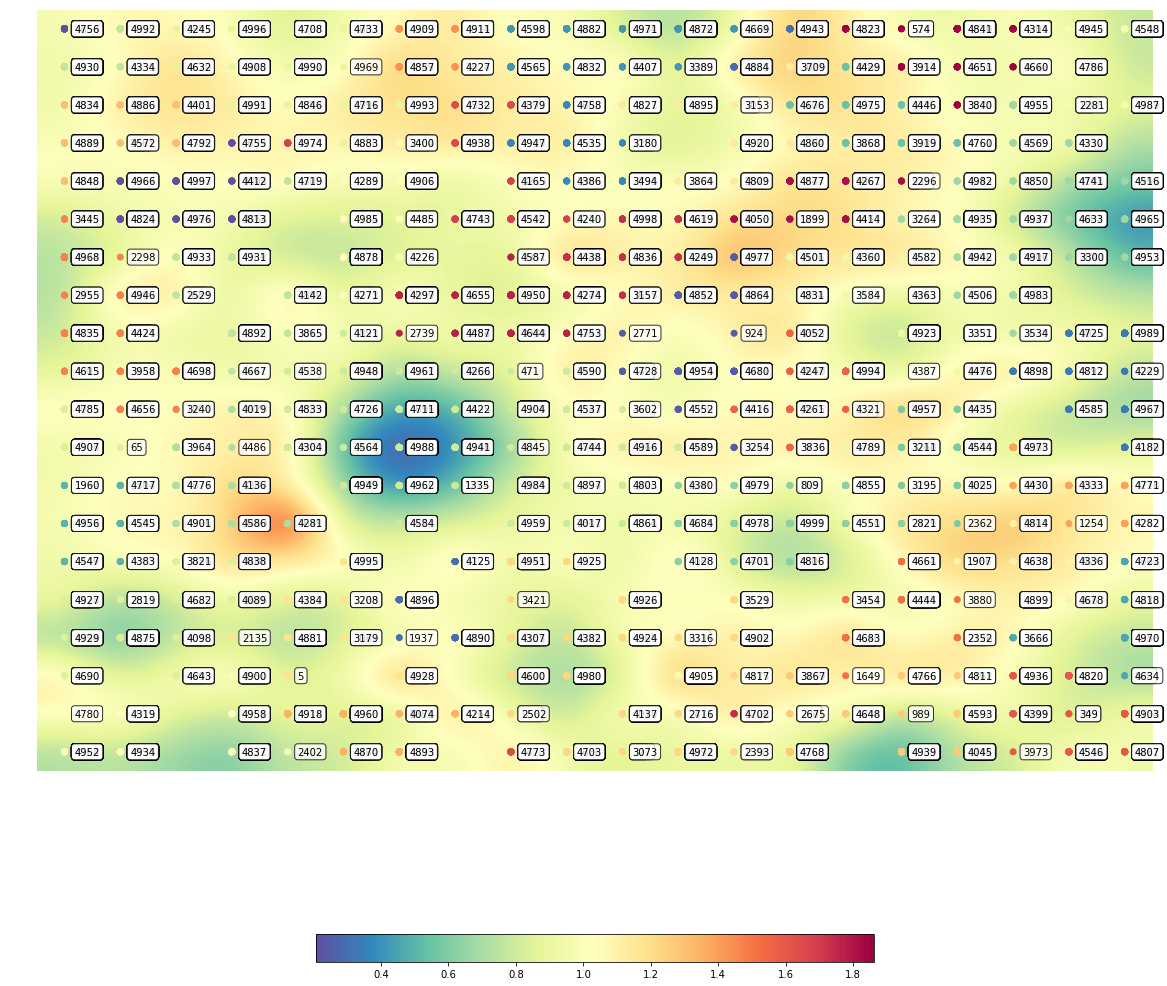

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [0]:
labels=range(5000)
som.view_umatrix(bestmatches=True,figsize=(20, 20),labels=labels,colorbar=True)

In [0]:
clusters = som.clusters 

clusters_unique = np.unique(clusters, return_index = True, return_counts = True)
clusters_sorted=np.argsort(clusters_unique[2])
print('Clusters sorted by increasing number of neurons:\n',clusters_sorted)
print('Number Of Neurons Per Cluster:\n',clusters_unique[2])

Clusters sorted by increasing number of neurons:
 [ 4 12 11 15 19 13 16  5  6 17 14 10  8 18  0  2  9  3  1  7]
Number Of Neurons Per Cluster:
 [24 49 26 29  8 14 14 67 16 27 15  9  8 11 15 10 12 15 20 11]


In [0]:
print(clusters)

[[ 0  0  8  8  8  8  8  9  9  9  9  9  9 15 15 15 15 15 19 19]
 [ 0  0  8  8  8  8  8  9  9  9  9  9  9  6 16 16 15  3 19  3]
 [13 13 13  8  8  8  8  9  9  9  6  6  6 16 16 16 16  3  3  3]
 [13 13 13 13  8  8  9  9  9  9  9  6  6  6 16 16 16  3  3  3]
 [13 13 13  0  0  0  9  9  9  9  9  6  6  6  6  6  3  3  3  3]
 [10 13  0  0  0  0  0  9  9  7  7  7  6  6  3  3  3  3  3  3]
 [10 10  0  0  0  0  0  7  7  7  7 16 16 16  2  2  3  3  3  3]
 [10 10  0  0  0  0  0  7  7  7  7  7  7  2  2  2  3  3  3  3]
 [10 10 10  0  0  7  7  7  7  7  7  7  2  2  2  2  2  3  3  3]
 [10 10 10 10  7  7  7  7  7  7  7  7  2  2  2  2  2 17 17 17]
 [18 10 10 10  7  7  7  7  7  7  7  7  2  2  2  2  2 17 17 17]
 [18 18  4  4  7  7  7  7  7  7  7  7 14  2  2  2  2 17 17 17]
 [18  4  4  4  7  7  7  7  7  7  7 14 14 14 14  2  2 17 17 17]
 [18 18  4  4  4  7  7  7  7  7  7 14 14 14 14 14 11 11 17 17]
 [18 18 18 18  7  7  7  1  1  1  7 14 14 14 14 12 12 11 11 17]
 [18 18 18 18  1  7  1  1  1  1  1  1  1 14 12 12 12 11


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]
```

   

In [0]:
def print_categories_stats(movies):
    total_cats = []

    for movie in movies:
        temp = categories[movie][0]
        temp = temp.split('"')
        temp = filter(lambda a: a != '', temp)
        temp = filter(lambda a: a != ',  ',temp)
        total_cats.extend(temp)

    cats_unique, count = np.unique(total_cats, return_counts = True)
    indices = np.argsort(count)
    indices = reversed(indices)
    tot = sum(count)

    print(' '*20,'Overall Cluster Genres stats: ',' '*20)
    print('{:<50} {:<20}'.format('Category', 'Percentage'))
    for i in indices:
        print('{:<50} {:<20}'.format(cats_unique[i], str(round(count[i]*100.0/tot,2))+'%'))
    return

In [0]:
def print_cluster_neurons_movies_report(curr):
    print('Report for Cluster =',curr)
    indices_y,indices_x = np.where(clusters == curr)
    indices1=np.column_stack((indices_x,indices_y))
    indices=[]
    #for x,y in zip(indices_x,indices_y):
     # indices.append(y*n_columns+x)
      
    total_bmus=[]
    for i in indices1:
      if i in bmus_unique:
        total_bmus.append(i)
    total_bmus=np.stack(total_bmus,axis=0)
    
    for i in range(0,len(indices_x)):
      indices.append(total_bmus[i][1]*n_columns+total_bmus[i][0])
   # print(indices)
    total_movies=[]
    total_movies=neuron_movies_report(indices)
    print_categories_stats(total_movies)
    
  
    return

In [0]:
def neuron_movies_report(total_bmus):
    total_movies=[]
    for neuron in total_bmus:
      for i in range(0,5000,1):
        if bmus_inverse[i]==neuron:
          total_movies.append(i)
   # print(total_movies)
    return total_movies

In [0]:
for i in range(0,n_clusters):
    print_cluster_neurons_movies_report(i)
    print("\n")

Report for Cluster = 0
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              32.14%              
Television movie                                   15.48%              
Biographical film                                  15.48%              
Film adaptation                                    4.76%               
Family Drama                                       3.57%               
Sports                                             3.57%               
Biopic [feature]                                   3.57%               
Political drama                                    2.38%               
Medical fiction                                    2.38%               
Teen                                               2.38%               
Docudrama                                          2.38%               
Courtroom Drama                         

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             27.62%              
Romance Film                                       13.97%              
Drama                                              11.05%              
Family Film                                        6.69%               
Short Film                                         6.11%               
Animation                                          3.85%               
Black-and-white                                    2.93%               
Slapstick                                          1.59%               
Crime Fiction                                      1.51%               
Indie                                              1.34%               
Comedy film                                        1.26%               
Romantic drama                                     1.09%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Animation                                          18.87%              
Short Film                                         18.68%              
Family Film                                        7.59%               
Comedy film                                        7.0%                
Thriller                                           6.81%               
Action                                             6.23%               
Drama                                              4.67%               
Crime Fiction                                      4.09%               
Action/Adventure                                   3.5%                
Crime Thriller                                     2.72%               
Mystery                                            2.33%               
Science Fiction                                    1.36%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Thriller                                           19.38%              
Mystery                                            12.04%              
Psychological thriller                             9.69%               
Crime Thriller                                     8.66%               
Drama                                              8.22%               
Crime Fiction                                      6.17%               
Suspense                                           3.96%               
Science Fiction                                    3.52%               
Horror                                             3.38%               
World cinema                                       1.91%               
Indie                                              1.91%               
Romance Film                                       1.32%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              16.83%              
Comedy                                             12.09%              
Romance Film                                       9.96%               
Romantic drama                                     5.42%               
World cinema                                       4.84%               
Family Film                                        3.68%               
Adventure                                          3.68%               
Comedy-drama                                       3.58%               
Action                                             2.51%               
Musical                                            2.51%               
Fantasy                                            2.22%               
Science Fiction                                    2.13%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              22.43%              
Thriller                                           12.5%               
Crime Thriller                                     11.03%              
Crime Fiction                                      9.44%               
Mystery                                            6.37%               
Action                                             2.82%               
Psychological thriller                             2.33%               
Horror                                             2.08%               
Action/Adventure                                   2.08%               
Black-and-white                                    1.84%               
Suspense                                           1.84%               
Film adaptation                                    1.84%       

Family & Personal Relationships                    0.14%               
Epic                                               0.14%               
Japanese Movies                                    0.14%               
Science Fiction                                    0.14%               
Docudrama                                          0.14%               
Latino                                             0.14%               
Slapstick                                          0.14%               
Illnesses & Disabilities                           0.14%               
Courtroom Drama                                    0.14%               
Costume drama                                      0.14%               
Zombie Film                                        0.14%               


Report for Cluster = 14
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Action                               

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              20.77%              
Action/Adventure                                   9.9%                
Action                                             9.58%               
World cinema                                       5.75%               
Musical                                            4.15%               
Western                                            3.83%               
Martial Arts Film                                  3.51%               
Chinese Movies                                     3.19%               
Sports                                             2.88%               
Thriller                                           2.56%               
Black-and-white                                    2.24%               
Crime Fiction                                      1.92%       

Detective                                          0.22%               
Cyberpunk                                          0.22%               
Cult                                               0.22%               
Crime Fiction                                      0.22%               
Japanese Movies                                    0.22%               
Martial Arts Film                                  0.22%               
Drama                                              0.22%               


Report for Cluster = 21
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             24.57%              
Indie                                              11.6%               
Romance Film                                       7.51%               
Musical                                            4.44%               
World cinema                         

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              32.75%              
Crime Fiction                                      17.09%              
Japanese Movies                                    5.06%               
Black-and-white                                    3.16%               
Mystery                                            2.06%               
Action                                             1.9%                
Thriller                                           1.9%                
Crime Drama                                        1.9%                
Film noir                                          1.9%                
Indie                                              1.74%               
Science Fiction                                    1.27%               
Comedy                                             1.27%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Short Film                                         28.68%              
Comedy                                             28.68%              
Black-and-white                                    28.68%              
Slapstick                                          6.98%               
Silent film                                        0.78%               
Screwball comedy                                   0.78%               
Science Fiction                                    0.78%               
Heaven-Can-Wait Fantasies                          0.78%               
Fantasy Comedy                                     0.78%               
Family-Oriented Adventure                          0.78%               
Comedy of Errors                                   0.78%               
Children's/Family                                  0.78%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Romantic drama                                     14.24%              
Drama                                              14.24%              
Romance Film                                       13.92%              
Period piece                                       13.59%              
Costume drama                                      4.53%               
Film adaptation                                    3.88%               
Biography                                          3.56%               
Biopic [feature]                                   2.91%               
Indie                                              2.59%               
Epic                                               1.94%               
Biographical film                                  1.62%               
Musical                                            1.29%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             15.51%              
Romance Film                                       15.51%              
Romantic comedy                                    15.51%              
Romantic drama                                     10.44%              
Drama                                              10.44%              
World cinema                                       6.33%               
Comedy-drama                                       4.11%               
Indie                                              4.11%               
Chinese Movies                                     1.58%               
Period piece                                       1.27%               
Satire                                             1.27%               
Costume drama                                      0.95%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             22.26%              
Romantic comedy                                    22.26%              
Romance Film                                       22.26%              
Black-and-white                                    4.59%               
Fantasy                                            2.47%               
Screwball comedy                                   2.12%               
Thriller                                           1.77%               
World cinema                                       1.41%               
Mystery                                            1.41%               
Television movie                                   1.41%               
Action/Adventure                                   1.06%               
Crime Fiction                                      1.06%       

                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Horror                                             24.24%              
Slasher                                            16.92%              
Thriller                                           10.35%              
Teen                                               5.56%               
Cult                                               4.8%                
B-movie                                            3.79%               
Psychological thriller                             3.79%               
World cinema                                       3.28%               
Comedy                                             3.03%               
Indie                                              2.78%               
Mystery                                            2.78%               
Supernatural                                       2.27%       


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



## Ανάλυση αποτελεσμάτων

Επιλέξαμε να χρησιμοποιήσουμε 20×20 νευρώνες καθώς για 5000 ταινίες ο χάρτης με 400 νευρώνες δίνουν καλή πληροφορία. Ήδη στην περίπτωση αυτή βλέπουμε ότι  δεν ανατίθενται σε όλους τους νευρώνες ταινίες.

Για να πάρουμε πληροφορία από τον umatrix και να τον αναλύσουμε επιλέξαμε να εμφανίζονται labels που αντιστοιχούν στο id της τελευταίας ταινίας που ανατέθηκε στον νευρώνα. Με το παρακάτω κομμάτι κώδικα υπολογίζουμε για κάθε νευρώνα, ποιά είναι η τελευταία ταινία που του ανατέθηκε, καθώς και σε ποιό cluster ανήκει. Με τον τρόπο αυτό μπορούμε να ξέρουμε σίγουρα(επειδή με τα χρώματα καμιά φορά δεν είναι ξεκάθαρο) κάθε νευρώνας που βλέπουμε στον χάρτη σε ποιό cluster ανήκει, συγκίνοντας το label του. 

In [0]:
for l in range(0,20):
    for k in range(0,20):
        neuron=l*20+k
        print("neuron "+str(neuron)+" belongs to cluster "+str(clusters[k][l])+" with last label:")
        last_label=-1
        for i in range(0,5000,1):   
            if bmus_inverse[i]==neuron:
                last_label=i
        print(last_label)

neuron 0 belongs to cluster 0 with last label:
4756
neuron 1 belongs to cluster 0 with last label:
4930
neuron 2 belongs to cluster 13 with last label:
4834
neuron 3 belongs to cluster 13 with last label:
4889
neuron 4 belongs to cluster 13 with last label:
4848
neuron 5 belongs to cluster 10 with last label:
3445
neuron 6 belongs to cluster 10 with last label:
4968
neuron 7 belongs to cluster 10 with last label:
2955
neuron 8 belongs to cluster 10 with last label:
4835
neuron 9 belongs to cluster 10 with last label:
4615
neuron 10 belongs to cluster 18 with last label:
4785
neuron 11 belongs to cluster 18 with last label:
4907
neuron 12 belongs to cluster 18 with last label:
1960
neuron 13 belongs to cluster 18 with last label:
4956
neuron 14 belongs to cluster 18 with last label:
4547
neuron 15 belongs to cluster 18 with last label:
4927
neuron 16 belongs to cluster 18 with last label:
4929
neuron 17 belongs to cluster 18 with last label:
4690
neuron 18 belongs to cluster 15 with las

4984
neuron 155 belongs to cluster 1 with last label:
4959
neuron 156 belongs to cluster 1 with last label:
4951
neuron 157 belongs to cluster 1 with last label:
3421
neuron 158 belongs to cluster 1 with last label:
4307
neuron 159 belongs to cluster 1 with last label:
4600
neuron 160 belongs to cluster 9 with last label:
2502
neuron 161 belongs to cluster 9 with last label:
4773
neuron 162 belongs to cluster 9 with last label:
4882
neuron 163 belongs to cluster 9 with last label:
4832
neuron 164 belongs to cluster 9 with last label:
4758
neuron 165 belongs to cluster 9 with last label:
4535
neuron 166 belongs to cluster 7 with last label:
4386
neuron 167 belongs to cluster 7 with last label:
4240
neuron 168 belongs to cluster 7 with last label:
4438
neuron 169 belongs to cluster 7 with last label:
4274
neuron 170 belongs to cluster 7 with last label:
4753
neuron 171 belongs to cluster 7 with last label:
4590
neuron 172 belongs to cluster 7 with last label:
4537
neuron 173 belongs to c

4945
neuron 329 belongs to cluster 2 with last label:
4786
neuron 330 belongs to cluster 2 with last label:
2281
neuron 331 belongs to cluster 2 with last label:
4330
neuron 332 belongs to cluster 2 with last label:
4741
neuron 333 belongs to cluster 11 with last label:
4633
neuron 334 belongs to cluster 12 with last label:
3300
neuron 335 belongs to cluster 12 with last label:
4725
neuron 336 belongs to cluster 11 with last label:
4812
neuron 337 belongs to cluster 5 with last label:
4585
neuron 338 belongs to cluster 5 with last label:
4333
neuron 339 belongs to cluster 7 with last label:
1254
neuron 340 belongs to cluster 15 with last label:
4336
neuron 341 belongs to cluster 3 with last label:
4678
neuron 342 belongs to cluster 3 with last label:
4820
neuron 343 belongs to cluster 3 with last label:
349
neuron 344 belongs to cluster 3 with last label:
4546
neuron 345 belongs to cluster 3 with last label:
4548
neuron 346 belongs to cluster 3 with last label:
4987
neuron 347 belongs 

Για το number of clusters στο kMeans, για χάρτη 20×20 δοκιμάσαμε τιμές 20,30,40 και συγκρίνοντας τα umatrix τον καλύτερο διαχωρισμό τον είχαμε για k=30. 

Στην συνέχεια γράψαμε τις ζητούμενες συναρτήσεις και παρακάτω φαίνονται για κάθε cluster οι κυριάρχες κατηγορίες που το περιγράφουν. (Το πλήρες output φαίνεται κάτω από τον κώδικα)

Report for Cluster = 0
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              30.0%               
Action                                             10.53%              
Action/Adventure                                   7.5%                
Comedy                                             7.5%                
Adventure                                          4.61%               


Report for Cluster = 1
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Romance Film                                       17.97%              
Drama                                              17.16%              
Comedy                                             12.91%              


Report for Cluster = 2
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             26.06%              
Musical                                            12.21%              
Indie                                              7.98%               
 


Report for Cluster = 3
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             21.07%              
Romantic comedy                                    15.13%              
Drama                                              14.54%              
Romance Film                                       11.87%              


Report for Cluster = 4
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             34.4%               
Romance Film                                       12.67%              
 


Report for Cluster = 5
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              24.89%              
Black-and-white                                    9.95%               


Report for Cluster = 6
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Horror                                             12.68%              
Thriller                                           8.88%               
Action                                             8.25%               
Science Fiction                                    8.03%               



Report for Cluster = 7
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Comedy                                             12.97%              
Family Film                                        10.13%              



Report for Cluster = 8
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              22.14%              
World cinema                                       9.93%               



Report for Cluster = 9
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Romantic comedy                                    10.91%              
Japanese Movies                                    10.91%              

Report for Cluster = 10
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Action                                             12.64%              
Action/Adventure                                   10.53%              
Short Film                                         9.79%               
Thriller                                           8.3%                

Report for Cluster = 11
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Horror                                             25.31%              
Thriller                                           23.12%              


Report for Cluster = 12
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Silent film                                        15.89%              
Drama                                              15.25%              
War film                                           14.62%              


Report for Cluster = 13
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Animation                                          14.5%               
Short Film                                         13.01%              



Report for Cluster = 14
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Adventure                                          11.85%              
Action                                             10.56%              



Report for Cluster = 15
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              36.33%              
Crime Fiction                                      17.13%              


Report for Cluster = 16
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Horror                                             22.47%              
Slasher                                            14.76%              


Report for Cluster = 17
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Crime Thriller                                     15.99%              
Thriller                                           15.5%               



Report for Cluster = 18
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              18.26%              
Comedy                                             13.01%              


Report for Cluster = 19
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              6.8%                
Animation                                          6.31%               
Comedy                                             5.99%               
Fantasy                                            5.83%               
Romance Film                                       5.5%                
Romantic drama                                     5.34%               
Adventure                                          5.34%               
Romantic comedy                                    5.34%               
Family Film                                        5.18%               
Action                                             5.02%               
Science Fiction                                    4.05%               
World cinema                                       3.72%               
Children's/Family                                  3.56%               
Japanese Movies                                    3.07%               
            
Report for Cluster = 20
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              21.21%              
Black-and-white                                    15.33%              
Action                                             11.05%              



Report for Cluster = 21
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              29.96%              
Comedy film                                        9.18%               
Science Fiction                                    8.8%                


Report for Cluster = 22
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Horror                                             22.74%              


Report for Cluster = 23
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Short Film                                         28.68%              
Comedy                                             28.68%              
Black-and-white                                    28.68%              


Report for Cluster = 24
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              15.15%              
Musical                                            10.94%              
Romance Film                                       10.14%              



Report for Cluster = 25
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              20.03%              
Thriller                                           18.27%              



Report for Cluster = 26
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Thriller                                           28.42%              
Mystery                                            11.75%              


Report for Cluster = 27
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Action                                             12.31%              
Adventure                                          11.28%              
Comedy                                             10.09%              



Report for Cluster = 28
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Drama                                              18.31%              
Romance Film                                       18.31%              
World cinema                                       16.28%              
Romantic drama                                     15.99%              



Report for Cluster = 29
                     Overall Cluster Genres stats:                      
Category                                           Percentage          
Documentary                                        25.05%              
Comedy film                                        17.2%               




Αυτό που παρατηρούμε είναι ότι με εξαίρεση το cluster 19, όλα τα υπόλοιπα έχουν μία με 3 κυρίαρχες κατηγορίες, οι οποίες συνδυάζονται. (π.χ Drama,Comedy | Action,Adventur | Drama,Romance). Από τον χάρτη πρατηρούμε ότι cluster με παρόμοιες κυρίαρχες κατηγορίες συνορεύουν στον χάρτη. 

Για παράδειγμα στον χάρτη μας, στην πάνω αριστερή γωνία έχουμε το cluster 17 (Crime Thriller,Thriller) που συνορεύει με το cluster 25 (Drama,Thriller) ενώ για παράδειγμα στην κάτω δεξία κατηγορία βλέπουμε το cluster 13 με categories animation και short film.

Ωστόσο κατηγορίες όπως Drama που εμφανίζονται σε πολλές ταινίες (μεγάλη πυκνότητα πιθανότητας στον χώρο εισόδου) εμφανίζονται σε παραπάνω από ένα σημείο στο χάρτη.
Γενικά οι ταινίες που έχουν κοινό περιεχόμενο είναι απεικονίζονται στον χάρτη.
 
 Ένα cluster που αποτυγχάνει να δώσει κυρίαρχες κατηγορίες είναι to cluster 19.
 
 Προφανώς δεν είναι τα γειτονικά clusters πάντα σχετικά μεταξύ τους. Αυτό είναι λογικό γιατί ο χάρτης είναι στις δύο διαστάσεις ενώ τα διαθέσιμα ήδη ταινιών είναι πάρα πολλά. 


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο mycourses το παρόν notebook επεξεργασμένο με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Προσέξτε ώστε να **απαντήσετε σε όλα τα σημεία όπου απαιτείται**.
- Μαζί Θα παραδώσετε τα joblib dumps των τελικών `corpus_tf_idf.pkl` και `som.pkl` (μεγάλος χάρτης - 5000 ταινίες) που θα χρησιμοποιήσετε. Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στο dump του χάρτη που θα μας παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. Οδηγίες για την αποθήκευση των dumps θα βρείτε στο [FAQ](https://docs.google.com/document/d/1jL4gRag_LHbVCYIt5XVJ53iJPb6RZWi02rT5mPXiqEU/edit?usp=sharing). 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.
- Στο **zip** που θα παραδώσετε πρέπει να βρίσκονται **4 αρχεία (το .ipynb και το .py του notebook καθώς και τα δύο .pkl)**
- **Το maximum upload filesize στο mycourses είναι 29MB**, εάν το zip σας είναι μεγαλύτερο, δεν έχετε βελτιστοποιήσει το tfidf.

<table>
  <tr>
    <td bgcolor="#FCF8E3"><font size="4">ΞΑΝΑ: Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!!</font>
</td>
  </tr>
</table>
